In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import matplotlib as mpl
from __future__ import unicode_literals
from matplotlib.gridspec import GridSpec
#matplotlib.rcParams['text.usetex'] = True
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import AutoMinorLocator
from scipy.signal import find_peaks
import matplotlib.patches as patches
from statistics import mean, stdev
from math import sqrt
from scipy.stats import f_oneway
from scipy.stats import tukey_hsd
from scipy import stats
import matplotlib
import matplotlib.cm as cm
import matplotlib as mpl
from __future__ import unicode_literals
from matplotlib.gridspec import GridSpec
matplotlib.rcParams['text.usetex'] = True
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import AutoMinorLocator
import matplotlib.gridspec as gridspec

from scipy.stats import f_oneway
from scipy.stats import tukey_hsd
from scipy import stats
from statistics import mean, stdev
import statsmodels.api as sm
from math import sqrt
plt.style.use(os.path.join('/home/daisy/Documentos', 'SinglePlot_2_axes.mplstyle'))

style = {'alpha': 0.75}
gridstyle = {'linewidth': 0.5, 'alpha': 0.5}
#plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{siunitx}')
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica-Normal']})

In [2]:
# Função para renomear colunas
def renomear_colunas(col_name):
    if col_name == "Time":
        return col_name  # Não altera a coluna 'Time'
    
    # Detecta a parte inicial e o número ao final
    if col_name[-1].isdigit() and col_name[-2].isdigit():
        base = col_name[:-1]  # Pega tudo menos o último dígito
        num = col_name[-1]    # Último dígito
        return f"{base}-{num}"
    elif col_name[-1].isdigit():
        base = col_name[:-2]  # Pega tudo menos os últimos dois dígitos
        num = col_name[-2:]   # Últimos dois dígitos
        return f"{base}-{num}"
    else:
        return col_name  # Retorna o nome original se não corresponder ao padrão
    
    
###################################################################################################   


def normalizacao_quimica(dados, inicio_pico_padrao, final_pico_padrao, altura_padrao_corrigida):
    dados_normalizado = np.zeros((len(dados.columns),len(dados))) #fazer uma matriz vazia com zeros
    colunas=[]
    for i in range(len(dados.columns)):#andei nas colunas
        colunas.append(dados.columns[i]) #salvar nome na lista colunas
        if dados.columns[i] =='Time': #se a coluna tiver Time
            dados_normalizado[i] = dados['Time'] #salve o Time
        else: #se nao...
            altura_pico_padrao = max(dados[dados.columns[i]][inicio_pico_padrao:final_pico_padrao])
            dados_normalizado[i] = dados[dados.columns[i]]/altura_pico_padrao*altura_padrao_corrigida
        
    dados_normalizados_transpose=dados_normalizado.T #transpose de coluna pra linha
    df_dados_normalizados = pd.DataFrame(dados_normalizados_transpose, columns=colunas) #gerar o data frame
    return df_dados_normalizados

    
###################################################################################################


def media_repbiologicas(dados):
    
    #FAZER LISTAS PARA ANOTAR NOMES UNICOS
    nomes_unicos=[]
    coluna=dados.columns[0] #nao quero que time apareca para colocar na lista
    nome_replicata=coluna.split('-')[0] #zero é tudo que vem antes do ponto

    nomes_unicos.append(nome_replicata)
    for i in range (1,len(dados.columns)):
        coluna=dados.columns[i]
        nome_replicata=coluna.split('-')[0]
        chave=0
        for j in range (len(nomes_unicos)):
            if nome_replicata == nomes_unicos[j]:
                chave=1
        if chave == 0:
            nomes_unicos.append(nome_replicata)
    print(nomes_unicos)

    #######CRIAR MATRIZ PARA FAZER MÉDIAS DAS BIOLÓGICAS
    contador=np.zeros(len(nomes_unicos))

    medias_replicatas=np.zeros((len(dados),len(nomes_unicos))) #np.zeros = criar matriz cujo numero de linhas e colunas sejam de water stresse e nomes_unicos, respectivamente
    for i in range (len(dados.columns)):
        coluna=dados.columns[i]
        nome_replicata=coluna.split('-')[0]
        lista_replicata=[]
        for j in range (len(nomes_unicos)):
            if nome_replicata == nomes_unicos[j]:
                lista_replicata.append(coluna)
                numero_j=j
        if len(lista_replicata)>0:
            medias_replicatas[:,numero_j]+=dados[coluna]
            contador[numero_j]+=1
            #print(lista_replicata)
    print(contador) #ver numero de replicatas biológicas
    for i in range(len(nomes_unicos)):
        medias_replicatas[:,i]=medias_replicatas[:,i]/contador[i]

    dados_media=pd.DataFrame.from_records(medias_replicatas,columns=nomes_unicos)
    return dados_media


###################################################################################################

def function_fig_chromatogram(plots_em_x, plots_em_y, h_size, v_size, 
                              tempo, lista_plots, lista_label, cores, linhas_por_painel,
                              alpha, lw, xlim_max, xlim_min, xticks, xticks_label, yticks, yticks_label,
                              ylabel, xlabel, dpi,
                              variacao_pontos, tempo_controle_asterisco, fontsize_asterisco,prominence,
                              loc, fontsize_legenda, fontsize_label, fontsize_letra, letra_painel,flag2,save_fig,formats):
    
    fig, axs = plt.subplots(plots_em_y,plots_em_x, figsize=(h_size*plots_em_x, v_size*plots_em_y),layout='constrained')
    
    if plots_em_x == 1 or plots_em_y == 1: #se tiver uma coluna ou linha
        numero_plot        = max(plots_em_x,plots_em_y)
        contador           = 0 
        contador_asterisco = 0
        
        for i in range (numero_plot):
            lista_media_painel = []
            contador_asterisco += 1
            for j in range(linhas_por_painel[i]):
                axs[i].plot(tempo, lista_plots[contador], label=lista_label[contador], 
                            lw=lw, alpha=alpha,c=cores[contador])
                contador+=1
                
            for l in range(1,linhas_por_painel[i] ):
                media_ct_tr = np.average([np.average(lista_plots[(contador_asterisco-1)*linhas_por_painel[i]]),
                                        np.average(lista_plots[(contador_asterisco-1)*linhas_por_painel[i] + l])])
                
                peaks, _    = find_peaks(lista_plots[(contador_asterisco-1)*linhas_por_painel[i] + l], prominence=prominence)  
#                 axs[i].scatter(tempo[peaks],lista_plots[(contador_asterisco-1)*linhas_por_painel[i] + l][peaks],s=2)
                sel = lista_plots[(contador_asterisco-1)*linhas_por_painel[i] + l][peaks] > media_ct_tr #selecionar os picos acima da média 
                for p in range (len(peaks[sel])):
                    maior_valor_controle = max(lista_plots[(contador_asterisco-1)*linhas_por_painel[i]][peaks[sel][p]-variacao_pontos:peaks[sel][p]+variacao_pontos]) #75 
                    razao = (lista_plots[(contador_asterisco-1)*linhas_por_painel[i] + l][peaks[sel][p]]) / (maior_valor_controle) #Fold Change
                    if razao >= 1.5 and tempo[peaks[sel][p]] < xlim_max: #limiar do fold - colcor o *
                        axs[i].text(tempo[peaks[sel][p]-tempo_controle_asterisco],
                                        1.01*lista_plots[(contador_asterisco-1)*linhas_por_painel[i] + l][peaks[sel][p]],
                                        '*',c=cores[l],fontsize=fontsize_asterisco) 
                    
            axs[i].set_ylabel(ylabel, fontsize = fontsize_label)
            axs[i].set_xlabel(xlabel, fontsize = fontsize_label)
            if len(xticks) > 0:
                axs[i].set_xticks(xticks, xticks_label, fontsize = fontsize_label)
            else:
                axs[i].tick_params(axis='x', labelsize=fontsize_label)
                
            if len(yticks[i]) > 0:
                axs[i].set_yticks(yticks[i], yticks_label[i], fontsize = fontsize_label)
            else:
                axs[i].tick_params(axis='y', labelsize=fontsize_label)
            axs[i].set_xlim(xlim_min, xlim_max)
            axs[i].legend(fontsize = fontsize_legenda, loc = "upper right", fancybox=False, frameon=False)
            axs[i].annotate(letra_painel[i], xy=(0.03, 0.95), xycoords='axes fraction', 
                            fontsize=fontsize_letra, horizontalalignment='left', verticalalignment='top')
            
    else:#se n tiver uma coluna ou linha
        contador_plot      = 0
        contador_letra     = 0
        contador_asterisco = 0
        for j in range (plots_em_y):
            for i in range (plots_em_x):
                contador_asterisco += 1
                for k in range(linhas_por_painel[contador_letra]):
                    axs[j,i].plot(tempo, lista_plots[contador_plot], label=lista_label[contador_plot],
                                  c=cores[contador_plot], lw=lw, alpha=alpha)
                    contador_plot += 1
                if i==1 or i==0 and flag2==True:
                    for l in range(1,linhas_por_painel[contador_letra]):
                        print(contador_plot - linhas_por_painel[contador_letra],cores[contador_plot-linhas_por_painel[contador_letra]],
                             contador_plot - linhas_por_painel[contador_letra]+l,cores[contador_plot-linhas_por_painel[contador_letra]+l])
                        media_ct_tr = np.average([np.average(lista_plots[contador_plot - linhas_por_painel[contador_letra]]),
                                                np.average(lista_plots[contador_plot - linhas_por_painel[contador_letra]+l])])              

                        peaks, _    = find_peaks(lista_plots[contador_plot - linhas_por_painel[contador_letra]+l], prominence=prominence)  
#                         axs[j,i].scatter(tempo[peaks],lista_plots[contador_plot - linhas_por_painel[contador_letra]+l][peaks],s=2)
                        sel         = lista_plots[contador_plot - linhas_por_painel[contador_letra]+l][peaks] > media_ct_tr #selecionar os picos acima da média 
                        for p in range (len(peaks[sel])):
                            maior_valor_controle = max(lista_plots[contador_plot - linhas_por_painel[contador_letra]][peaks[sel][p]-variacao_pontos:peaks[sel][p]+variacao_pontos]) #75 
                            razao = (lista_plots[contador_plot - linhas_por_painel[contador_letra]+l][peaks[sel][p]]) / (maior_valor_controle) #Fold Change
                            if razao >= 1.5 and tempo[peaks[sel][p]] < xlim_max: #limiar do fold - colcor o *
                                axs[j,i].text(tempo[peaks[sel][p]-tempo_controle_asterisco],
                                                1.01*lista_plots[contador_plot - linhas_por_painel[contador_letra]+l][peaks[sel][p]],
                                                '*',c=cores[contador_plot - linhas_por_painel[contador_letra]+l], fontsize=fontsize_asterisco) 
                            
                axs[j,i].set_ylabel(ylabel[contador_letra], fontsize = fontsize_label)
                axs[j,i].set_xlabel(xlabel, fontsize = fontsize_label)
                if len(xticks) > 0:
                    axs[j,i].set_xticks(xticks, xticks_label, fontsize = fontsize_label)
                else:
                    axs[j,i].tick_params(axis='x', labelsize=fontsize_label)
                if len(yticks[contador_letra]) > 0:
                    axs[j,i].set_yticks(yticks[contador_letra], yticks_label[contador_letra], fontsize = fontsize_label)
                else:
                    axs[j,i].tick_params(axis='y', labelsize=fontsize_label)
                axs[j,i].set_xlim(xlim_min, xlim_max)
                axs[j,i].legend(fontsize=fontsize_legenda, loc = loc[contador_letra], fancybox=False,frameon=False)
                axs[j,i].annotate(letra_painel[contador_letra], xy=(0.03, 0.95),xycoords='axes fraction',
                                  fontsize=fontsize_letra, horizontalalignment='left', verticalalignment='top')
                contador_letra+=1    
                
    for i in range(len(formats)):
        plt.savefig(save_fig+formats[i], bbox_inches='tight', pad_inches=0.1, transparent=True, dpi=dpi)     
#     plt.close()
    return None


##############################################################################################################3
def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    pooled_std = np.sqrt(((nx - 1)*np.var(x, ddof=1) + (ny - 1)*np.var(y, ddof=1)) / (nx + ny - 2))
    return (np.mean(x) - np.mean(y)) / pooled_std


def effect_size_r_mannwhitney(x, y, U):
    n1 = len(x)
    n2 = len(y)
    mean_u = n1 * n2 / 2
    std_u = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
    z = (U - mean_u) / std_u
    r = z / np.sqrt(n1 + n2)
    return r


def tamanho_efeito_d_cohen(x):
    if abs(x) < 0.2:
        resultado = "No effect"
    elif abs(x) >= 0.2 and abs(x) < 0.5:
        resultado = "S"
    elif abs(x) >= 0.5 and abs(x) < 0.8:
        resultado = "M"
    elif abs(x) >= 0.8:
        resultado = "L"
    return(resultado)


def tamanho_efeito_r(x):
    if abs(x) < 0.1:
        resultado = "No effect"
    elif abs(x) >= 0.1 and abs(x) < 0.3:
        resultado = "S"
    elif abs(x) >= 0.3 and abs(x) < 0.5:
        resultado = "M"
    elif abs(x) >= 0.5:
        resultado = "L"
    return(resultado)


def New_Plot(ax,tempo,lista_plots,df,lista_nomes,
             variacao_pontos,tempo_controle_asterisco,prominence,
             lista_label,cores,alpha,lw,
             ylabel,yticks, yticks_label,fontsize_label,
             fontsize_legenda,fontsize_circulo,fontsize_asterisco,fontsize_t_efeito,tempo_letra,letra_painel,
             fontsize_letra,position,
             ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom):
    
    df_pontos = pd.DataFrame(columns=['Sample', 'Retention time', 'Fold-change', 
                                      'Shapiro-test control stat', 'Shapiro-test control pvalue',
                                      'Shapiro-test trated stat', 'Shapiro-test trated pvalue',
                                      'Levene-test stat', 'Levene-test pvalue',
                                      't-test stat','t-test pvalue','D cohen',
                                      'Mann-whitney stat','Mann-whitney pvalue','r effect','Effect size'])
    
    ax.annotate(r'$\bullet\,\,\,\,\,\,\,$'+r'FC $>$ 1.5', xy=(position[18],position[19]), xycoords='axes fraction', 
                            fontsize=fontsize_asterisco, horizontalalignment='left', verticalalignment='top')
   
    ax.annotate(r'*', xy=(position[0],position[1]), xycoords='axes fraction', 
                            fontsize=fontsize_asterisco, horizontalalignment='left', verticalalignment='top') 
    ax.annotate(r'FC $>$ 1.5 and', xy=(position[2],position[3]), xycoords='axes fraction', 
                            fontsize=fontsize_asterisco, horizontalalignment='left', verticalalignment='top')    
    ax.annotate(r'pvalue $\leq$ 0.05', xy=(position[4],position[5]), xycoords='axes fraction', 
                            fontsize=fontsize_asterisco, horizontalalignment='left', verticalalignment='top')     
    
    ax.annotate('S', xy=(position[6],position[7]), xycoords='axes fraction', 
                           fontsize=fontsize_asterisco, horizontalalignment='left', verticalalignment='top')     
    ax.annotate('M', xy=(position[8],position[9]), xycoords='axes fraction', 
                            fontsize=fontsize_asterisco, horizontalalignment='left', verticalalignment='top')     
    ax.annotate('L', xy=(position[10],position[11]), xycoords='axes fraction', 
                            fontsize=fontsize_asterisco, horizontalalignment='left', verticalalignment='top')
    
    ax.annotate('small effect size', xy=(position[12],position[13]), xycoords='axes fraction', 
                            fontsize=fontsize_asterisco, horizontalalignment='left', verticalalignment='top')     
    ax.annotate('medium effect size', xy=(position[14],position[15]), xycoords='axes fraction', 
                            fontsize=fontsize_asterisco, horizontalalignment='left', verticalalignment='top')     
    ax.annotate('large effect size', xy=(position[16],position[17]), xycoords='axes fraction', 
                            fontsize=fontsize_asterisco, horizontalalignment='left', verticalalignment='top')    
   

    for j in range(len(lista_plots)):
        ax.plot(tempo, lista_plots[j], label=r'%s'%lista_label[j], 
                            lw=lw, alpha=alpha,c=cores[j])
        if j == 0:
            df_controle = df.filter(regex=lista_nomes[j])

        else:
            df_tratado = df.filter(regex=lista_nomes[j])  
            
            media_ct_tr = np.average([np.average(lista_plots[0]),np.average(lista_plots[j])])
            peaks, _    = find_peaks(lista_plots[j], prominence=prominence)
            sel = lista_plots[j][peaks] > media_ct_tr
            #selecionar os picos acima da média 
            for p in range (len(peaks[sel])):
                maior_valor_controle = max(lista_plots[0][peaks[sel][p]-variacao_pontos:peaks[sel][p]+variacao_pontos]) #75 
                razao = (lista_plots[j][peaks[sel][p]]) / (maior_valor_controle) #Fold Change
                if razao >= 1.5 and tempo[peaks[sel][p]] < xlim_max: #limiar do fold - colcor o *
                    pontos_maximo_controle = []
                    for o in range(len(df_controle.columns)):
                        ponto_maximo = max(df_controle[df_controle.columns[o]][peaks[sel][p]-variacao_pontos:peaks[sel][p]+variacao_pontos])
                        pontos_maximo_controle.append(ponto_maximo)

                    pontos_maximo_tratado = []
                    for o in range(len(df_tratado.columns)):
                        ponto_maximo = max(df_tratado[df_tratado.columns[o]][peaks[sel][p]-variacao_pontos:peaks[sel][p]+variacao_pontos])
                        pontos_maximo_tratado.append(ponto_maximo)   

                    if len(pontos_maximo_controle) > 2 and len(pontos_maximo_tratado) > 2:
                        stat_shapiro_controle, pvalue_shapiro_controle = stats.shapiro(pontos_maximo_controle)
                        stat_shapiro_tratado, pvalue_shapiro_tratado  = stats.shapiro(pontos_maximo_tratado)     
                        stat_levene, pvalue_levene = stats.levene(pontos_maximo_controle, pontos_maximo_tratado)

                        if pvalue_shapiro_controle > 0.05 and pvalue_shapiro_tratado > 0.05 and pvalue_levene > 0.05:
                            stat_teste_t, pvalue_teste_t = stats.ttest_ind(pontos_maximo_controle,pontos_maximo_tratado)
                            D_cohen = cohens_d(pontos_maximo_controle, pontos_maximo_tratado)  
                            result = tamanho_efeito_d_cohen(D_cohen)
                            
                            if pvalue_teste_t < 0.05:
                                ax.text(tempo[peaks[sel][p]-tempo_controle_asterisco],
                                    lista_plots[j][peaks[sel][p]]-0.01*max(yticks), #,+ 0.005*max(yticks),
                                    '*',c=cores[j],fontsize=fontsize_asterisco)
                                ax.text(tempo[peaks[sel][p]-tempo_letra],
                                    lista_plots[j][peaks[sel][p]] + 0.03*max(yticks),
                                    result,c=cores[j],fontsize=fontsize_t_efeito)                                
                            else:
                                ax.text(tempo[peaks[sel][p]-tempo_controle_asterisco],
                                    lista_plots[j][peaks[sel][p]] + 0.01*max(yticks),
                                    r'$\bullet$',c=cores[j],fontsize=fontsize_circulo)
                                ax.text(tempo[peaks[sel][p]-tempo_letra],
                                    lista_plots[j][peaks[sel][p]] + 0.03*max(yticks),
                                    result,c=cores[j],fontsize=fontsize_t_efeito)  
                            nova_linha = {'Sample': lista_label[j],      
                                          'Retention time': tempo[peaks[sel][p]-tempo_letra],
                                          'Fold-change': razao,
                                          'Shapiro-test control stat':stat_shapiro_controle,
                                          'Shapiro-test control pvalue':pvalue_shapiro_controle,
                                          'Shapiro-test trated stat':stat_shapiro_tratado,
                                          'Shapiro-test trated pvalue':pvalue_shapiro_tratado,
                                          'Levene-test stat':stat_levene,
                                          'Levene-test pvalue':pvalue_levene,
                                          't-test stat':stat_teste_t,  
                                          't-test pvalue':pvalue_teste_t,
                                          'D cohen':D_cohen,
                                          'Mann-whitney stat':None,
                                          'Mann-whitney pvalue':None,
                                          'r effect':None,
                                          'Effect size':result}
                            df_pontos = pd.concat([df_pontos, pd.DataFrame([nova_linha])], ignore_index=True)              
                            
                            
                        else:
                            stat_teste_MW, pvalue_MW = stats.mannwhitneyu(pontos_maximo_controle, pontos_maximo_tratado, alternative='two-sided')
                            efeito_r = effect_size_r_mannwhitney(pontos_maximo_controle, pontos_maximo_tratado, stat_teste_MW)
                            result = tamanho_efeito_r(efeito_r)
                            if pvalue_MW < 0.05:
                                ax.text(tempo[peaks[sel][p]-tempo_controle_asterisco],
                                    lista_plots[j][peaks[sel][p]]-0.01*max(yticks),# + 0.005*max(yticks),
                                    '*',c=cores[j],fontsize=fontsize_asterisco) 
                                ax.text(tempo[peaks[sel][p]-tempo_letra],
                                    lista_plots[j][peaks[sel][p]] + 0.03*max(yticks),
                                    result,c=cores[j],fontsize=fontsize_t_efeito)  
                            else:
                                ax.text(tempo[peaks[sel][p]-tempo_controle_asterisco],
                                    lista_plots[j][peaks[sel][p]] + 0.01*max(yticks),
                                    r'$\bullet$',c=cores[j],fontsize=fontsize_circulo)                            
                                ax.text(tempo[peaks[sel][p]-tempo_letra],
                                    lista_plots[j][peaks[sel][p]] + 0.03*max(yticks),
                                    result,c=cores[j],fontsize=fontsize_t_efeito)  
                                
                            nova_linha = {'Sample': lista_label[j],   
                                          'Retention time': tempo[peaks[sel][p]-tempo_letra],
                                          'Fold-change': razao,
                                          'Shapiro-test control stat':stat_shapiro_controle,
                                          'Shapiro-test control pvalue':pvalue_shapiro_controle,
                                          'Shapiro-test trated stat':stat_shapiro_tratado,
                                          'Shapiro-test trated pvalue':pvalue_shapiro_tratado,
                                          'Levene-test stat':stat_levene,
                                          'Levene-test pvalue':pvalue_levene,
                                          't-test stat':None,  
                                          't-test pvalue':None,
                                          'D cohen':None,
                                          'Mann-whitney stat':stat_teste_MW,
                                          'Mann-whitney pvalue':pvalue_MW,
                                          'r effect':efeito_r,
                                          'Effect size':result}
                            df_pontos = pd.concat([df_pontos, pd.DataFrame([nova_linha])], ignore_index=True)
                    else:
                        ax.text(tempo[peaks[sel][p]-tempo_controle_asterisco],
                                     lista_plots[j][peaks[sel][p]] + 0.01*max(yticks),
                                    r'$\bullet$',c=cores[j],fontsize=fontsize_circulo)  
                        print(j)
                        nova_linha = {'Sample': lista_label[j],   
                                      'Retention time': tempo[peaks[sel][p]-tempo_letra],
                                      'Fold-change': razao,
                                      'Shapiro-test control stat':None,
                                      'Shapiro-test control pvalue':None,
                                      'Shapiro-test trated stat':None,
                                      'Shapiro-test trated pvalue':None,
                                      'Levene-test stat':None,
                                      'Levene-test pvalue':None,
                                      't-test stat':None,  
                                      't-test pvalue':None,
                                      'D cohen':None,
                                      'Mann-whitney stat':None,
                                      'Mann-whitney pvalue':None,
                                      'r effect':None,
                                      'Effect size':None}
                        df_pontos = pd.concat([df_pontos, pd.DataFrame([nova_linha])], ignore_index=True)

    ax.yaxis.get_major_formatter()._usetex = False               
    ax.set_ylabel(ylabel, fontsize = fontsize_label)
    ax.set_xlim(xlim_min, xlim_max)
    ax.set_ylim(0, None)
    ax.tick_params(bottom=False, labelbottom=False)
    
    if len(yticks) > 0:
        ax.set_yticks(yticks, yticks_label, fontsize = fontsize_label)
    else:
        ax.tick_params(axis='y', labelsize=fontsize_label)

    ax.legend(fontsize = fontsize_legenda, loc = "upper right", fancybox=False, frameon=False)
    ax.annotate(letra_painel, xy=(0.03, 0.95), xycoords='axes fraction', 
                            fontsize=fontsize_letra, horizontalalignment='left', verticalalignment='top')
    New_Plot2(ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom)
    return df_pontos  


def New_Plot2(ax, df, cores, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom):
    for i in range(1,len(df_pad.columns)):
        ax.fill_between(df['time'],df[df.columns[i]]/np.max(df[df.columns[i]]),lw=0.,
                        color=cores[i-1],alpha=alpha_bottom,
                label = df.columns[i])
        
        
    ax.set_xlabel(xlabel, fontsize = fontsize_label)
    if len(xticks) > 0:
        ax.set_xticks(xticks, xticks_label, fontsize = fontsize_label)
    else:
        ax.tick_params(axis='x', labelsize=fontsize_label)
    ax.tick_params(left=False, labelleft=False)            
    ax.set_xlim(xlim_min, xlim_max)
    ax.set_ylim(0, 1)
    ax.xaxis.get_major_formatter()._usetex = False
    ax.legend(fontsize = 3.5, ncol = 2,loc = "upper center",
              bbox_to_anchor=(0.5,1.05),columnspacing=29.5, fancybox=False, frameon=False)
    
    

In [3]:
### padroes
arquivo='/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/padroes/standard_Evelu_abs.xlsx'

df_pad = pd.read_excel(arquivo,sheet_name='metabolites')
df_pad

,time,Licorine,Montanine,Tazetine,Formononetin,Isomers,Erythraline,Hidroxiflavona,Daidzein,Quercetin,Genistein,Kaempferol
0,2.501628,0.000041,0.000041,0.000060,0.000059,0.000031,0.000043,0.000032,0.000054,0.000028,0.000039,0.000056
1,2.503294,0.000045,0.000040,0.000060,0.000059,0.000032,0.000041,0.000032,0.000058,0.000029,0.000041,0.000053
2,2.504961,0.000047,0.000037,0.000056,0.000057,0.000033,0.000042,0.000031,0.000060,0.000034,0.000040,0.000054
3,2.506628,0.000051,0.000033,0.000053,0.000055,0.000032,0.000039,0.000033,0.000060,0.000039,0.000040,0.000057
4,2.508294,0.000056,0.000030,0.000048,0.000054,0.000033,0.000036,0.000034,0.000058,0.000043,0.000036,0.000057
...,...,...,...,...,...,...,...,...,...,...,...,...
28490,49.993530,0.002259,0.002181,0.002227,0.002240,0.002240,0.000000,0.001134,0.002348,0.002261,0.002370,0.002192
28491,49.995200,0.002258,0.002183,0.002227,0.002241,0.002238,0.000000,0.001137,0.002346,0.002257,0.002366,0.002190
28492,49.996860,0.002255,0.002185,0.002221,0.002244,0.002235,0.000000,0.001137,0.002345,0.002251,0.002364,0.002191
28493,49.998530,0.002257,0.002184,0.002217,0.002246,0.002236,0.000000,0.001141,0.002347,0.002249,0.002361,0.002193


# TEMPERATURA

In [4]:
# caminho_arquivo = r'E:\Doc\Cap 2 - Tratadas_HPLC_Evelu\Analise_HPLC\RESULTADOS_PROCESSADOS\Manuscrito\Plant_Biology\Re-submission\Final_figures\new\Figures\all_treatmens_final_normalizado2.xlsx'
caminho_arquivo = r'/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/Final_figures/new/Figures/all_treatmens_final_normalizado2.xlsx'
df_T = pd.read_excel(caminho_arquivo,sheet_name='temp')
df_T

df_T.columns

Index(['Time', 'FT24-1', 'FT24-2', 'FT24-3', 'FT24-4', 'FT24-5', 'FT50-1',
       'FT50-2', 'FT50-3', 'FT50-4', 'FT50-5', 'RT24-1', 'RT24-2', 'RT24-3',
       'RT24-4', 'RT24-5', 'RT50-1', 'RT50-2', 'RT50-3', 'RT50-4', 'RT50-5'],
      dtype='object')

In [5]:
# for i in range(1,5):
#     plt.plot(df_T['Time'][4080:4379],df_T[df_T.columns[i]][4080:4379]) 

############# NORMALIZAÇÃO ###################
# temp_ori_normalizado = normalizacao_quimica(df_T, 4080, 4379, 0.0942)
############# CRIAR DATA FRAME ###################
# caminho=r'E:\Doc\Cap 2 - Tratadas_HPLC_Evelu\Analise_HPLC\RESULTADOS_PROCESSADOS\Manuscrito\Plant_Biology\Re-submission\Final_figures\new'
# nome_arquivo=r'\temp_ori_normalizado.xlsx'
# arquivo=caminho+nome_arquivo

# temp_ori_normalizado.to_excel(arquivo, index=False)
temp_ori_normalizado = df_T

############# FAZER MÉDIAS DAS REPLICATAS ###################
temp_ori_normalizado_media = media_repbiologicas(temp_ori_normalizado)
temp_ori_normalizado_media

['Time', 'FT24', 'FT50', 'RT24', 'RT50']
[1. 5. 5. 5. 5.]


,Time,FT24,FT50,RT24,RT50
0,2.501628,0.000151,0.000007,0.000271,-0.000013
1,2.503294,0.000150,0.000007,0.000274,-0.000018
2,2.504961,0.000150,0.000008,0.000275,-0.000024
3,2.506628,0.000149,0.000008,0.000272,-0.000025
4,2.508294,0.000150,0.000008,0.000268,-0.000023
...,...,...,...,...,...
28490,49.993530,0.004042,0.001280,0.002955,0.000043
28491,49.995200,0.004051,0.001284,0.002959,0.000041
28492,49.996860,0.004060,0.001286,0.002965,0.000044
28493,49.998530,0.004069,0.001288,0.002972,0.000040


<>:39: SyntaxWarning: invalid escape sequence '\c'
<>:39: SyntaxWarning: invalid escape sequence '\c'
<>:109: SyntaxWarning: invalid escape sequence '\c'
<>:109: SyntaxWarning: invalid escape sequence '\c'
<>:39: SyntaxWarning: invalid escape sequence '\c'
<>:39: SyntaxWarning: invalid escape sequence '\c'
<>:109: SyntaxWarning: invalid escape sequence '\c'
<>:109: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_46820/2705445867.py:39: SyntaxWarning: invalid escape sequence '\c'
  lista_label   = ['Leaves 24$^{\circ}$C','Leaves 50$^{\circ}$C',
/tmp/ipykernel_46820/2705445867.py:39: SyntaxWarning: invalid escape sequence '\c'
  lista_label   = ['Leaves 24$^{\circ}$C','Leaves 50$^{\circ}$C',
/tmp/ipykernel_46820/2705445867.py:109: SyntaxWarning: invalid escape sequence '\c'
  lista_label   = ['Roots 24$^{\circ}$C','Roots 50$^{\circ}$C',
/tmp/ipykernel_46820/2705445867.py:109: SyntaxWarning: invalid escape sequence '\c'
  lista_label   = ['Roots 24$^{\circ}$C','Roots 50$^{\circ

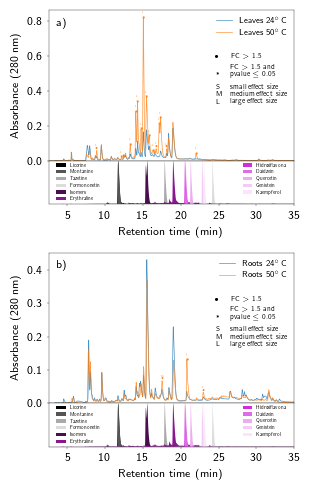

In [96]:
plots_em_x = 1
plots_em_y = 2
h_size     = 3.2 #tamanho horizontal do painel em polegadas
v_size     = 2.5 #tamanho vertical do painel em polegadas #h_size/1.618  #2.5
dpi = 700
tempo         = temp_ori_normalizado_media['Time']

fig = plt.figure(figsize=(h_size * plots_em_x, v_size * plots_em_y))

lista_cores   = ['C0', 'C1']
alpha = 0.8
lw=0.5
xlim_max     = 35
xlim_min     = 2.5
xticks       = [5, 10, 15, 20, 25, 30, 35]  #se lista vazia, python escolhe os numeros
xticks_label = ['5','10','15','20','25','30','35'] #se lista vazia, python escolhe os numeros
ylabel       = r'Absorbance (280 nm)'
xlabel       = r'Retention time (min)'
fontsize_legenda   = 6
fontsize_label     = 8 # tamanho das legendas e dos números do eixo
fontsize_letra     = 8 # tamanho da letra do painel
fontsize_circulo   = 3
fontsize_asterisco = 5
fontsize_t_efeito  = 2



yticks       = [0.0, 0.2,0.4,0.6,0.8] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0', '0.2','0.4','0.6','0.8']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 100 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'a)'
lista_nomes = ['FT24','FT50']
lista_plots   = [temp_ori_normalizado_media['FT24'],temp_ori_normalizado_media['FT50']]

lista_label   = ['Leaves 24$^{\circ}$C','Leaves 50$^{\circ}$C',             
       
                 ]


alpha_bottom = 1

cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']   


A = 0 #mudar o painel
# B = 0 #mudar o painel

outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)
inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A],
            height_ratios=[3.5, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])

position = [
0.68, 0.6,
0.74, 0.64,
0.74, 0.59,
0.68, 0.51,
0.68, 0.46,
0.68, 0.41,
0.74, 0.51,
0.74, 0.46,
0.74, 0.41,
0.675, 0.71]
#mudar o df!!!
df_func=df_T
df_painel_a = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom)



###########################################################


yticks       = [0.0, 0.1,0.2,0.3,0.4] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0', '0.1','0.2','0.3','0.4']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 100 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'b)'
lista_nomes = ['RT24','RT50']
lista_plots   = [temp_ori_normalizado_media['RT24'],temp_ori_normalizado_media['RT50']

                 
                 
]
lista_label   = ['Roots 24$^{\circ}$C','Roots 50$^{\circ}$C',                         
        
                 ]

cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']  

A = 1 #mudar o painel
# B = 1 #mudar o painel

outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)
inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A], 
            height_ratios=[3.5, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])


#mudar o df!!!
position = [
0.68, 0.6,
0.74, 0.64,
0.74, 0.59,
0.68, 0.51,
0.68, 0.46,
0.68, 0.41,
0.74, 0.51,
0.74, 0.46,
0.74, 0.41,
0.675, 0.71]
df_func=df_T
df_painel_b = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom)





# ###########################################################

df_concatenado_temp = pd.concat([df_painel_a, df_painel_b], axis=0)


# plt.savefig('/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/graficos_suplementar/temp.pdf', bbox_inches='tight', pad_inches=0.1, transparent=True, dpi=dpi)

# plt.savefig('/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/graficos_suplementar/temp.tiff', bbox_inches='tight', pad_inches=0.1, transparent=True, dpi=dpi)

# plt.savefig('/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/graficos_suplementar/temp.pdf', bbox_inches='tight', pad_inches=0.1, transparent=True, dpi=dpi)

plt.savefig('/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/graficos_suplementar/temp.png', bbox_inches='tight', pad_inches=0.1, transparent=False, dpi=dpi)


In [ ]:
df_concatenado_temp

# UV

In [6]:
caminho_arquivo = r'/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/Final_figures/new/Figures/all_treatmens_final_normalizado2.xlsx'
df_uv = pd.read_excel(caminho_arquivo,sheet_name='uv')
df_uv

# Aplica a função a todas as colunas do DataFrame
# df_uv.columns = [renomear_colunas(col) for col in df_uv.columns]

# # Exibir as colunas renomeadas
# df_uv

,Time,FCUV24-1,FCUV24-2,FCUV24-3,FCUV24-4,FCUV24-5,FCUV48-1,FCUV48-2,FCUV48-3,FCUV48-4,...,RCUV48-4,RCUV48-5,RUV24-1,RUV24-3,RUV24-4,RUV24-5,RUV48-1,RUV48-3,RUV48-4,RUV48-5
0,2.501628,0.000014,0.000066,0.000077,0.000073,0.000084,0.000075,0.000066,0.000078,0.000089,...,0.000061,0.000054,-4.096732e-06,0.000023,0.000049,0.000049,0.000025,0.000027,0.000048,0.000057
1,2.503294,0.000013,0.000071,0.000077,0.000076,0.000076,0.000077,0.000066,0.000080,0.000090,...,0.000061,0.000056,8.453574e-07,0.000022,0.000050,0.000046,0.000021,0.000028,0.000048,0.000056
2,2.504961,0.000017,0.000071,0.000079,0.000075,0.000068,0.000081,0.000065,0.000080,0.000094,...,0.000060,0.000062,2.275962e-06,0.000023,0.000048,0.000043,0.000017,0.000030,0.000047,0.000056
3,2.506628,0.000024,0.000072,0.000079,0.000075,0.000061,0.000085,0.000059,0.000079,0.000095,...,0.000060,0.000067,5.527337e-06,0.000024,0.000042,0.000042,0.000018,0.000032,0.000047,0.000056
4,2.508294,0.000033,0.000073,0.000081,0.000075,0.000060,0.000088,0.000055,0.000079,0.000094,...,0.000061,0.000073,3.966677e-06,0.000028,0.000035,0.000040,0.000016,0.000035,0.000048,0.000055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28490,49.993530,0.003266,0.004530,0.005207,0.004834,0.004588,0.002836,0.003233,0.003185,0.003410,...,0.002739,0.002731,2.331041e-03,0.002931,0.002703,0.003088,0.003352,0.001957,0.002137,0.002027
28491,49.995200,0.003266,0.004528,0.005207,0.004836,0.004580,0.002836,0.003233,0.003180,0.003412,...,0.002734,0.002733,2.331171e-03,0.002927,0.002705,0.003085,0.003355,0.001957,0.002135,0.002027
28492,49.996860,0.003265,0.004529,0.005208,0.004838,0.004570,0.002834,0.003237,0.003178,0.003412,...,0.002727,0.002736,2.331561e-03,0.002922,0.002705,0.003084,0.003360,0.001958,0.002135,0.002026
28493,49.998530,0.003264,0.004528,0.005208,0.004840,0.004566,0.002834,0.003241,0.003175,0.003410,...,0.002721,0.002738,2.333967e-03,0.002920,0.002704,0.003083,0.003367,0.001960,0.002133,0.002022


In [7]:
# for i in range(10,11): #numero das amostras
#     plt.plot(df_uv['Time'][4200:4499],df_uv[df_uv.columns[i]][4200:4499], lw=0.4) 

############# NORMALIZAÇÃO ###################
# uv_ori_normalizado = normalizacao_quimica(df_uv, 4200, 4499, 0.0942)
############# CRIAR DATA FRAME ###################
# caminho=r'E:\Doc\Cap 2 - Tratadas_HPLC_Evelu\Analise_HPLC\RESULTADOS_PROCESSADOS\Manuscrito\Plant_Biology\Re-submission\Final_figures\new'
# nome_arquivo=r'\uv_ori_normalizado.xlsx'
# arquivo=caminho+nome_arquivo
uv_ori_normalizado = df_uv
# uv_ori_normalizado.to_excel(arquivo, index=False)
uv_ori_normalizado_media = media_repbiologicas(uv_ori_normalizado)
uv_ori_normalizado_media

['Time', 'FCUV24', 'FCUV48', 'FUV24', 'FUV48', 'RCUV24', 'RCUV48', 'RUV24', 'RUV48']
[1. 5. 5. 5. 5. 4. 5. 4. 4.]


,Time,FCUV24,FCUV48,FUV24,FUV48,RCUV24,RCUV48,RUV24,RUV48
0,2.501628,0.000063,0.000079,0.000054,0.000050,0.000074,0.000041,0.000029,0.000039
1,2.503294,0.000063,0.000079,0.000055,0.000050,0.000072,0.000042,0.000030,0.000038
2,2.504961,0.000062,0.000080,0.000055,0.000049,0.000071,0.000043,0.000029,0.000038
3,2.506628,0.000062,0.000079,0.000055,0.000048,0.000071,0.000045,0.000028,0.000038
4,2.508294,0.000065,0.000078,0.000053,0.000047,0.000072,0.000046,0.000027,0.000039
...,...,...,...,...,...,...,...,...,...
28490,49.993530,0.004485,0.003239,0.003377,0.002950,0.004997,0.002724,0.002763,0.002368
28491,49.995200,0.004484,0.003238,0.003376,0.002950,0.004994,0.002725,0.002762,0.002369
28492,49.996860,0.004482,0.003237,0.003374,0.002952,0.004991,0.002725,0.002761,0.002370
28493,49.998530,0.004481,0.003237,0.003372,0.002953,0.004990,0.002724,0.002760,0.002370


/tmp/ipykernel_46820/173820660.py:377: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pontos = pd.concat([df_pontos, pd.DataFrame([nova_linha])], ignore_index=True)
/tmp/ipykernel_46820/173820660.py:339: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pontos = pd.concat([df_pontos, pd.DataFrame([nova_linha])], ignore_index=True)
/tmp/ipykernel_46820/173820660.py:339: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this wi

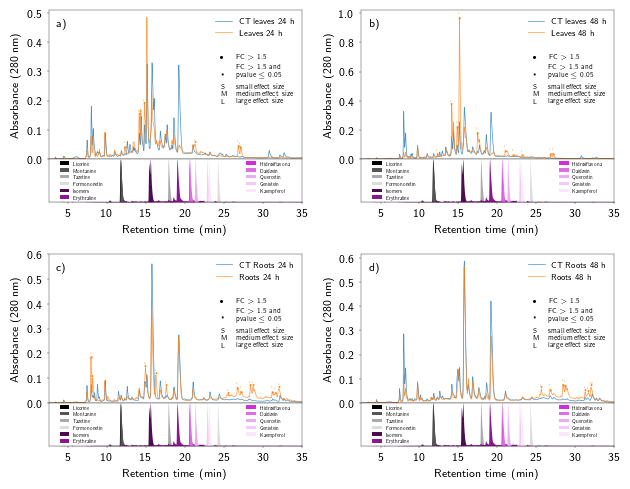

In [97]:
plots_em_x = 2
plots_em_y = 2
h_size     = 3.2 #tamanho horizontal do painel em polegadas
v_size     = 2.5 #tamanho vertical do painel em polegadas #h_size/1.618  #2.5
dpi = 700
tempo         = uv_ori_normalizado_media['Time']

fig = plt.figure(figsize=(h_size * plots_em_x, v_size * plots_em_y))

lista_cores   = ['C0', 'C1']
alpha = 0.8
lw=0.5
xlim_max     = 35
xlim_min     = 2.5
xticks       = [5, 10, 15, 20, 25, 30, 35]  #se lista vazia, python escolhe os numeros
xticks_label = ['5','10','15','20','25','30','35'] #se lista vazia, python escolhe os numeros
ylabel       = r'Absorbance (280 nm)'
xlabel       = r'Retention time (min)'
fontsize_legenda   = 6
fontsize_label     = 8 # tamanho das legendas e dos números do eixo
fontsize_letra     = 8 # tamanho da letra do painel
fontsize_circulo   = 3
fontsize_asterisco = 5
fontsize_t_efeito  = 2



yticks       = [0.0, 0.1,0.2,0.3,0.4,0.5] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0', '0.1','0.2','0.3','0.4','0.5']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 100 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'a)'
lista_nomes = ['FCUV24','FUV24']
lista_plots   = [uv_ori_normalizado_media['FCUV24'],uv_ori_normalizado_media['FUV24']]

lista_label   = ['CT leaves 24 h','Leaves 24 h',             
       
                 ]


alpha_bottom = 1

cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']   


A = 0 #mudar o painel
B = 0 #mudar o painel

outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)
inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A,B],
            height_ratios=[3.5, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])

position = [
0.68, 0.6,
0.74, 0.64,
0.74, 0.59,
0.68, 0.51,
0.68, 0.46,
0.68, 0.41,
0.74, 0.51,
0.74, 0.46,
0.74, 0.41,
0.675, 0.71]
#mudar o df!!!
df_func=df_uv
df_painel_a = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom)



###########################################################


yticks       = [0.0, 0.2,0.4,0.6,0.8,1.0] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0', '0.2','0.4','0.6','0.8','1.0']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 100 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'b)'
lista_nomes = ['FCUV48','FUV48']
lista_plots   = [uv_ori_normalizado_media['FCUV48'],uv_ori_normalizado_media['FUV48']

                 
                 
]
lista_label   = ['CT leaves 48 h','Leaves 48 h',                         
        
                 ]

cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']  

A = 0 #mudar o painel
B = 1 #mudar o painel

outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)
inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A,B], 
            height_ratios=[3.5, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])


#mudar o df!!!
position = [
0.68, 0.6,
0.74, 0.64,
0.74, 0.59,
0.68, 0.51,
0.68, 0.46,
0.68, 0.41,
0.74, 0.51,
0.74, 0.46,
0.74, 0.41,
0.675, 0.71]
df_func=df_uv
df_painel_b = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom)



###########################################################


yticks       = [0.0, 0.1,0.2,0.3,0.4,0.5, 0.6] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0', '0.1','0.2','0.3','0.4','0.5','0.6']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 100 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'c)'
lista_nomes = ['RCUV24','RUV24']
lista_plots   = [uv_ori_normalizado_media['RCUV24'],uv_ori_normalizado_media['RUV24']

                 
                 
]
lista_label   = ['CT Roots 24 h','Roots 24 h',                         
        
                 ]

cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']  

A = 1 #mudar o painel
B = 0 #mudar o painel

outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)
inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A,B], 
            height_ratios=[3.5, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])


#mudar o df!!!
position = [
0.68, 0.6,
0.74, 0.64,
0.74, 0.59,
0.68, 0.51,
0.68, 0.46,
0.68, 0.41,
0.74, 0.51,
0.74, 0.46,
0.74, 0.41,
0.675, 0.71]
df_func=df_uv
df_painel_c = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom)


###########################################################


yticks       = [0.0, 0.1,0.2,0.3,0.4,0.5, 0.6] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0', '0.1','0.2','0.3','0.4','0.5','0.6']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 100 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'd)'
lista_nomes = ['RCUV48','RUV48']
lista_plots   = [uv_ori_normalizado_media['RCUV48'],uv_ori_normalizado_media['RUV48']

                 
                 
]
lista_label   = ['CT Roots 48 h','Roots 48 h',                         
        
                 ]

cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']  

A = 1 #mudar o painel
B = 1 #mudar o painel

outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)
inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A,B], 
            height_ratios=[3.5, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])


#mudar o df!!!
position = [
0.68, 0.6,
0.74, 0.64,
0.74, 0.59,
0.68, 0.51,
0.68, 0.46,
0.68, 0.41,
0.74, 0.51,
0.74, 0.46,
0.74, 0.41,
0.675, 0.71]
df_func=df_uv
df_painel_d = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom)


# ###########################################################

df_concatenado_uv = pd.concat([df_painel_a, df_painel_b,df_painel_c,df_painel_d], axis=0)


# plt.savefig('/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/graficos_suplementar/uv.pdf', bbox_inches='tight', pad_inches=0.1, transparent=True, dpi=dpi)

# plt.savefig('/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/graficos_suplementar/uv.tiff', bbox_inches='tight', pad_inches=0.1, transparent=True, dpi=dpi)

plt.savefig('/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/graficos_suplementar/uv.png', bbox_inches='tight', pad_inches=0.1, transparent=False, dpi=dpi)



# HIDRICO

In [8]:
caminho_arquivo = r'/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/Final_figures/new/Figures/all_treatmens_final_normalizado2.xlsx'
df_h = pd.read_excel(caminho_arquivo,sheet_name='hidrico')
df_h

# # Aplica a função a todas as colunas do DataFrame
# df_uv.columns = [renomear_colunas(col) for col in df_uv.columns]

# # Exibir as colunas renomeadas
# df_uv

,Time,FTH0-1,FTH0-2,FTH0-3,FTH0-4,FTH0-5,FTH02-1,FTH02-2,FTH02-3,FTH02-4,...,RCTH1-5,RCTH2-1,RCTH2-2,RCTH2-3,RCTH2-4,RCTH3-1,RCTH3-2,RCTH3-3,RCTH3-4,RCTH3-5
0,2.501628,0.000071,0.000057,0.000059,0.000045,0.000048,0.000071,0.000060,0.000060,0.000045,...,0.000043,8.410582e-06,0.000072,0.000021,0.000060,0.000061,0.000107,0.000071,0.000044,0.000028
1,2.503294,0.000072,0.000059,0.000061,0.000045,0.000050,0.000071,0.000063,0.000059,0.000045,...,0.000044,5.689511e-06,0.000074,0.000022,0.000059,0.000061,0.000111,0.000065,0.000040,0.000029
2,2.504961,0.000075,0.000058,0.000060,0.000045,0.000048,0.000071,0.000064,0.000060,0.000046,...,0.000044,3.957921e-06,0.000082,0.000023,0.000062,0.000063,0.000106,0.000062,0.000034,0.000029
3,2.506628,0.000075,0.000060,0.000059,0.000046,0.000048,0.000071,0.000064,0.000061,0.000045,...,0.000045,1.236850e-06,0.000081,0.000024,0.000064,0.000066,0.000101,0.000064,0.000030,0.000032
4,2.508294,0.000075,0.000063,0.000060,0.000045,0.000046,0.000072,0.000064,0.000062,0.000043,...,0.000046,4.947401e-07,0.000080,0.000025,0.000062,0.000068,0.000095,0.000065,0.000024,0.000034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28490,49.993530,0.002484,0.002448,0.002630,0.002566,0.002584,0.002488,0.002449,0.002633,0.002563,...,0.001854,3.040920e-03,0.002709,0.001004,0.002062,0.002420,0.004594,0.003535,0.002223,0.002401
28491,49.995200,0.002484,0.002449,0.002632,0.002563,0.002582,0.002487,0.002443,0.002633,0.002563,...,0.001854,3.035725e-03,0.002707,0.001006,0.002064,0.002419,0.004603,0.003530,0.002230,0.002402
28492,49.996860,0.002484,0.002449,0.002633,0.002563,0.002579,0.002485,0.002443,0.002637,0.002563,...,0.001855,3.032015e-03,0.002706,0.001007,0.002064,0.002419,0.004611,0.003526,0.002233,0.002405
28493,49.998530,0.002485,0.002449,0.002633,0.002563,0.002575,0.002484,0.002443,0.002637,0.002562,...,0.001855,3.033746e-03,0.002704,0.001009,0.002065,0.002419,0.004615,0.003520,0.002237,0.002409


In [9]:
# for i in range(1,71): #numero das amostras
#     plt.plot(df_h['Time'][4140:4499],df_h[df_h.columns[i]][4140:4499], lw=0.4) 

# r-4158:4469
# f-4140:4499

############# NORMALIZAÇÃO ###################
# hidrico_ori_normalizado = normalizacao_quimica(df_h, 4140, 4499, 0.0942)
############# CRIAR DATA FRAME ###################
# caminho=r'E:\Doc\Cap 2 - Tratadas_HPLC_Evelu\Analise_HPLC\RESULTADOS_PROCESSADOS\Manuscrito\Plant_Biology\Re-submission\Final_figures\new'
# nome_arquivo=r'\hidrico_ori_normalizado.xlsx'
# arquivo=caminho+nome_arquivo

# hidrico_ori_normalizado.to_excel(arquivo, index=False)
hidrico_ori_normalizado = df_h

hidrico_ori_normalizado_media = media_repbiologicas(hidrico_ori_normalizado)
hidrico_ori_normalizado_media

['Time', 'FTH0', 'FTH02', 'FTH1', 'FTH002', 'FTH2', 'FTH3', 'FCTH1', 'FCTH2', 'FCTH3', 'RTH0', 'RTH1', 'RTH2', 'RTH3', 'RCTH1', 'RCTH2', 'RCTH3']
[1. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 3. 5. 4. 4. 5.]


,Time,FTH0,FTH02,FTH1,FTH002,FTH2,FTH3,FCTH1,FCTH2,FCTH3,RTH0,RTH1,RTH2,RTH3,RCTH1,RCTH2,RCTH3
0,2.501628,0.000056,0.000057,0.000045,0.000058,0.000058,0.000048,0.000051,0.000022,0.000054,0.000048,0.000043,0.000066,0.000033,0.000040,0.000041,0.000062
1,2.503294,0.000057,0.000057,0.000045,0.000058,0.000061,0.000048,0.000051,0.000021,0.000055,0.000049,0.000044,0.000073,0.000033,0.000041,0.000040,0.000061
2,2.504961,0.000058,0.000058,0.000045,0.000058,0.000065,0.000048,0.000051,0.000021,0.000056,0.000049,0.000043,0.000078,0.000032,0.000042,0.000043,0.000059
3,2.506628,0.000058,0.000058,0.000045,0.000058,0.000069,0.000048,0.000051,0.000020,0.000057,0.000050,0.000042,0.000085,0.000033,0.000042,0.000042,0.000058
4,2.508294,0.000058,0.000058,0.000045,0.000058,0.000070,0.000048,0.000051,0.000019,0.000058,0.000049,0.000042,0.000090,0.000034,0.000044,0.000042,0.000057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28490,49.993530,0.002543,0.002542,0.002175,0.003411,0.003419,0.002973,0.002637,0.000906,0.002855,0.002267,0.001865,0.003319,0.001696,0.001861,0.002204,0.003035
28491,49.995200,0.002542,0.002542,0.002176,0.003411,0.003417,0.002975,0.002642,0.000906,0.002856,0.002268,0.001864,0.003317,0.001697,0.001861,0.002203,0.003037
28492,49.996860,0.002541,0.002542,0.002177,0.003409,0.003416,0.002978,0.002645,0.000906,0.002858,0.002268,0.001863,0.003313,0.001698,0.001861,0.002202,0.003039
28493,49.998530,0.002541,0.002542,0.002179,0.003407,0.003418,0.002981,0.002647,0.000907,0.002859,0.002268,0.001862,0.003311,0.001699,0.001861,0.002203,0.003040


/tmp/ipykernel_46820/173820660.py:377: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pontos = pd.concat([df_pontos, pd.DataFrame([nova_linha])], ignore_index=True)
/tmp/ipykernel_46820/173820660.py:339: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pontos = pd.concat([df_pontos, pd.DataFrame([nova_linha])], ignore_index=True)
/tmp/ipykernel_46820/173820660.py:377: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this wi

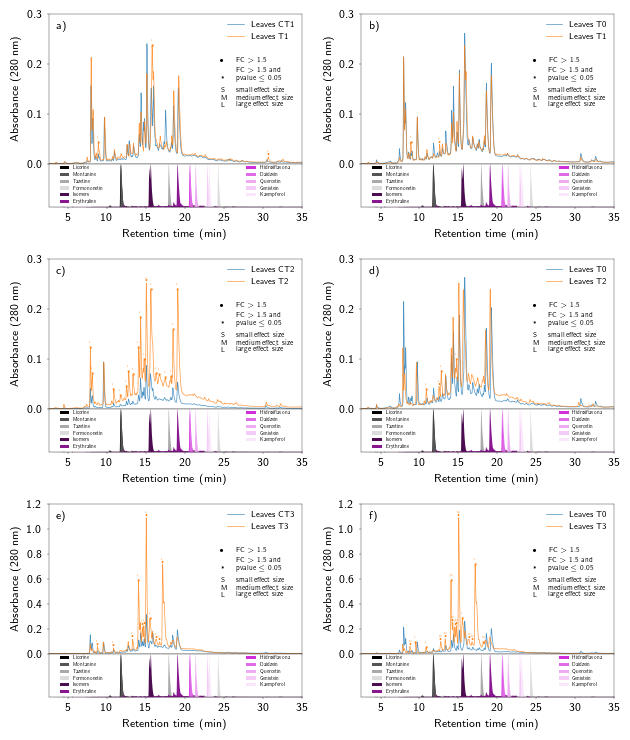

In [98]:
plots_em_x = 2
plots_em_y = 3
h_size     = 3.2 #tamanho horizontal do painel em polegadas
v_size     = 2.5 #tamanho vertical do painel em polegadas #h_size/1.618  #2.5
dpi = 700
tempo         = hidrico_ori_normalizado_media['Time']

fig = plt.figure(figsize=(h_size * plots_em_x, v_size * plots_em_y))

lista_cores   = ['C0', 'C1']
alpha = 0.8
lw=0.5
xlim_max     = 35
xlim_min     = 2.5
xticks       = [5, 10, 15, 20, 25, 30, 35]  #se lista vazia, python escolhe os numeros
xticks_label = ['5','10','15','20','25','30','35'] #se lista vazia, python escolhe os numeros
ylabel       = r'Absorbance (280 nm)'
xlabel       = r'Retention time (min)'
fontsize_legenda   = 6
fontsize_label     = 8 # tamanho das legendas e dos números do eixo
fontsize_letra     = 8 # tamanho da letra do painel
fontsize_circulo   = 3
fontsize_asterisco = 5
fontsize_t_efeito  = 2



yticks       = [0.0, 0.1,0.2,0.3] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0', '0.1','0.2','0.3']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 100 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'a)'
lista_nomes = ['FCTH1','FTH1']
lista_plots   = [hidrico_ori_normalizado_media['FCTH1'],hidrico_ori_normalizado_media['FTH1']]

lista_label   = ['Leaves CT1','Leaves T1',             
       
                 ]


alpha_bottom = 1

cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']   


A = 0 #mudar o painel
B = 0 #mudar o painel

outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)
inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A,B],
            height_ratios=[3.5, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])

position = [
0.68, 0.6,
0.74, 0.64,
0.74, 0.59,
0.68, 0.51,
0.68, 0.46,
0.68, 0.41,
0.74, 0.51,
0.74, 0.46,
0.74, 0.41,
0.675, 0.71]
#mudar o df!!!
df_func=df_h
df_painel_a = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom)



###########################################################


yticks       = [0.0, 0.1,0.2,0.3] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0', '0.1','0.2','0.3']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 100 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'b)'
lista_nomes = ['FTH0','FTH1']
lista_plots   = [hidrico_ori_normalizado_media['FTH0'],hidrico_ori_normalizado_media['FTH1']

                 
                 
]
lista_label   = ['Leaves T0','Leaves T1',                         
        
                 ]

cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']  

A = 0 #mudar o painel
B = 1 #mudar o painel

outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)
inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A,B], 
            height_ratios=[3.5, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])


#mudar o df!!!
position = [
0.68, 0.6,
0.74, 0.64,
0.74, 0.59,
0.68, 0.51,
0.68, 0.46,
0.68, 0.41,
0.74, 0.51,
0.74, 0.46,
0.74, 0.41,
0.675, 0.71]
df_func=df_h
df_painel_b = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom)



###########################################################


yticks       = [0.0, 0.1,0.2,0.3] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0', '0.1','0.2','0.3']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 100 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'c)'
lista_nomes = ['FCTH2','FTH2']
lista_plots   = [hidrico_ori_normalizado_media['FCTH2'],hidrico_ori_normalizado_media['FTH2']

                 
                 
]
lista_label   = ['Leaves CT2','Leaves T2',                         
        
                 ]

cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']  

A = 1 #mudar o painel
B = 0 #mudar o painel

outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)
inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A,B], 
            height_ratios=[3.5, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])


#mudar o df!!!
position = [
0.68, 0.6,
0.74, 0.64,
0.74, 0.59,
0.68, 0.51,
0.68, 0.46,
0.68, 0.41,
0.74, 0.51,
0.74, 0.46,
0.74, 0.41,
0.675, 0.71]
df_func=df_h
df_painel_c = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom)


###########################################################


yticks       = [0.0, 0.1,0.2,0.3] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0', '0.1','0.2','0.3']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 100 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'd)'
lista_nomes = ['FTH02','FTH2']
lista_plots   = [hidrico_ori_normalizado_media['FTH02'],hidrico_ori_normalizado_media['FTH2']

                 
                 
]
lista_label   = ['Leaves T0','Leaves T2',                         
        
                 ]

cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']  

A = 1 #mudar o painel
B = 1 #mudar o painel

outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)
inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A,B], 
            height_ratios=[3.5, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])


#mudar o df!!!
position = [
0.68, 0.6,
0.74, 0.64,
0.74, 0.59,
0.68, 0.51,
0.68, 0.46,
0.68, 0.41,
0.74, 0.51,
0.74, 0.46,
0.74, 0.41,
0.675, 0.71]
df_func=df_h
df_painel_d = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom)


# ###########################################################
###########################################################


yticks       = [0.0, 0.2,0.4,0.6,0.8,1.0,1.2]
yticks_label = ['0.0', '0.2','0.4','0.6','0.8','1.0','1.2']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 100 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'e)'
lista_nomes = ['FCTH3','FTH3']
lista_plots   = [hidrico_ori_normalizado_media['FCTH3'],hidrico_ori_normalizado_media['FTH3']

                 
                 
]
lista_label   = ['Leaves CT3','Leaves T3',                         
        
                 ]

cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']  

A = 2 #mudar o painel
B = 0 #mudar o painel

outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)
inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A,B], 
            height_ratios=[3.5, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])


#mudar o df!!!
position = [
0.68, 0.6,
0.74, 0.64,
0.74, 0.59,
0.68, 0.51,
0.68, 0.46,
0.68, 0.41,
0.74, 0.51,
0.74, 0.46,
0.74, 0.41,
0.675, 0.71]
df_func=df_h
df_painel_e = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom)


###########################################################


yticks       = [0.0, 0.2,0.4,0.6,0.8,1.0,1.2]
yticks_label = ['0.0', '0.2','0.4','0.6','0.8','1.0','1.2']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 100 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'f)'
lista_nomes = ['FTH0','FTH3']
lista_plots   = [hidrico_ori_normalizado_media['FTH0'],hidrico_ori_normalizado_media['FTH3']

                 
                 
]
lista_label   = ['Leaves T0','Leaves T3',                         
        
                 ]

cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']  

A = 2 #mudar o painel
B = 1 #mudar o painel

outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)
inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A,B], 
            height_ratios=[3.5, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])


#mudar o df!!!
position = [
0.68, 0.6,
0.74, 0.64,
0.74, 0.59,
0.68, 0.51,
0.68, 0.46,
0.68, 0.41,
0.74, 0.51,
0.74, 0.46,
0.74, 0.41,
0.675, 0.71]
df_func=df_h
df_painel_f= New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom)


df_concatenado_hidrico_folhas = pd.concat([df_painel_a, df_painel_b,df_painel_c,df_painel_d,
                                          df_painel_e,df_painel_f], axis=0)


# plt.savefig('/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/graficos_suplementar/hidrico_leaves.pdf', bbox_inches='tight', pad_inches=0.1, transparent=True, dpi=dpi)

# plt.savefig('/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/graficos_suplementar/hidrico_leaves.tiff', bbox_inches='tight', pad_inches=0.1, transparent=True, dpi=dpi)

plt.savefig('/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/graficos_suplementar/hidrico_leaves.png', bbox_inches='tight', pad_inches=0.1, transparent=False, dpi=dpi)



/tmp/ipykernel_46820/173820660.py:339: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pontos = pd.concat([df_pontos, pd.DataFrame([nova_linha])], ignore_index=True)
/tmp/ipykernel_46820/173820660.py:377: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pontos = pd.concat([df_pontos, pd.DataFrame([nova_linha])], ignore_index=True)
/tmp/ipykernel_46820/173820660.py:377: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this wi

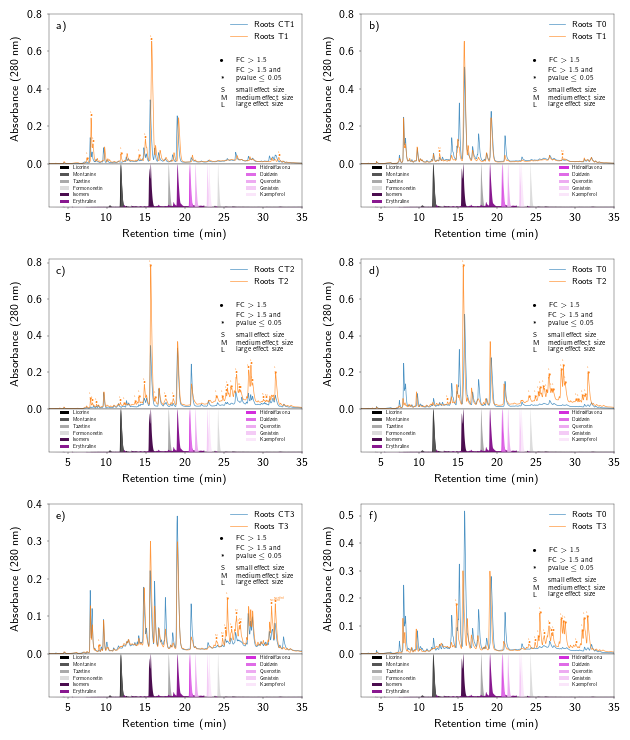

In [99]:
plots_em_x = 2
plots_em_y = 3
h_size     = 3.2 #tamanho horizontal do painel em polegadas
v_size     = 2.5 #tamanho vertical do painel em polegadas #h_size/1.618  #2.5
dpi = 700
tempo         = hidrico_ori_normalizado_media['Time']

fig = plt.figure(figsize=(h_size * plots_em_x, v_size * plots_em_y))

lista_cores   = ['C0', 'C1']
alpha = 0.8
lw=0.5
xlim_max     = 35
xlim_min     = 2.5
xticks       = [5, 10, 15, 20, 25, 30, 35]  #se lista vazia, python escolhe os numeros
xticks_label = ['5','10','15','20','25','30','35'] #se lista vazia, python escolhe os numeros
ylabel       = r'Absorbance (280 nm)'
xlabel       = r'Retention time (min)'
fontsize_legenda   = 6
fontsize_label     = 8 # tamanho das legendas e dos números do eixo
fontsize_letra     = 8 # tamanho da letra do painel
fontsize_circulo   = 3
fontsize_asterisco = 5
fontsize_t_efeito  = 2



yticks       = [0.0,0.2,0.4,0.6,0.8] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0','0.2','0.4','0.6','0.8']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 100 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'a)'
lista_nomes = ['RCTH1','RTH1']
lista_plots   = [hidrico_ori_normalizado_media['RCTH1'],hidrico_ori_normalizado_media['RTH1']]

lista_label   = ['Roots CT1','Roots T1',             
       
                 ]


alpha_bottom = 1

cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']   


A = 0 #mudar o painel
B = 0 #mudar o painel

outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)
inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A,B],
            height_ratios=[3.5, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])

position = [
0.68, 0.6,
0.74, 0.64,
0.74, 0.59,
0.68, 0.51,
0.68, 0.46,
0.68, 0.41,
0.74, 0.51,
0.74, 0.46,
0.74, 0.41,
0.675, 0.71]
#mudar o df!!!
df_func=df_h
df_painel_a = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom)



###########################################################


yticks       = [0.0,0.2,0.4,0.6,0.8] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0','0.2','0.4','0.6','0.8']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 100 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'b)'
lista_nomes = ['RTH0','RTH1']
lista_plots   = [hidrico_ori_normalizado_media['RTH0'],hidrico_ori_normalizado_media['RTH1']

                 
                 
]
lista_label   = ['Roots T0','Roots T1',                         
        
                 ]

cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']  

A = 0 #mudar o painel
B = 1 #mudar o painel

outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)
inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A,B], 
            height_ratios=[3.5, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])


#mudar o df!!!
position = [
0.68, 0.6,
0.74, 0.64,
0.74, 0.59,
0.68, 0.51,
0.68, 0.46,
0.68, 0.41,
0.74, 0.51,
0.74, 0.46,
0.74, 0.41,
0.675, 0.71]
df_func=df_h
df_painel_b = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom)



###########################################################


yticks       = [0.0,0.2,0.4,0.6,0.8] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0','0.2','0.4','0.6','0.8']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 100 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'c)'
lista_nomes = ['RCTH2','RTH2']
lista_plots   = [hidrico_ori_normalizado_media['RCTH2'],hidrico_ori_normalizado_media['RTH2']

                 
                 
]
lista_label   = ['Roots CT2','Roots T2',                         
        
                 ]

cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']  

A = 1 #mudar o painel
B = 0 #mudar o painel

outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)
inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A,B], 
            height_ratios=[3.5, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])


#mudar o df!!!
position = [
0.68, 0.6,
0.74, 0.64,
0.74, 0.59,
0.68, 0.51,
0.68, 0.46,
0.68, 0.41,
0.74, 0.51,
0.74, 0.46,
0.74, 0.41,
0.675, 0.71]
df_func=df_h
df_painel_c = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom)


###########################################################


yticks       = [0.0,0.2,0.4,0.6,0.8] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0','0.2','0.4','0.6','0.8']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 100 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'd)'
lista_nomes = ['RTH0','RTH2']
lista_plots   = [hidrico_ori_normalizado_media['RTH0'],hidrico_ori_normalizado_media['RTH2']

                 
                 
]
lista_label   = ['Roots T0','Roots T2',                         
        
                 ]

cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']  

A = 1 #mudar o painel
B = 1 #mudar o painel

outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)
inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A,B], 
            height_ratios=[3.5, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])


#mudar o df!!!
position = [
0.68, 0.6,
0.74, 0.64,
0.74, 0.59,
0.68, 0.51,
0.68, 0.46,
0.68, 0.41,
0.74, 0.51,
0.74, 0.46,
0.74, 0.41,
0.675, 0.71]
df_func=df_h
df_painel_d = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom)


# ###########################################################
###########################################################


yticks       = [0.0,0.1,0.2,0.3,0.4]
yticks_label = ['0.0','0.1','0.2','0.3','0.4']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 100 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'e)'
lista_nomes = ['RCTH3','RTH3']
lista_plots   = [hidrico_ori_normalizado_media['RCTH3'],hidrico_ori_normalizado_media['RTH3']

                 
                 
]
lista_label   = ['Roots CT3','Roots T3',                         
        
                 ]

cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']  

A = 2 #mudar o painel
B = 0 #mudar o painel

outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)
inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A,B], 
            height_ratios=[3.5, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])


#mudar o df!!!
position = [
0.68, 0.6+0.08,
0.74, 0.64+0.08,
0.74, 0.59+0.08,
0.68, 0.51+0.08,
0.68, 0.46+0.08,
0.68, 0.41+0.08,
0.74, 0.51+0.08,
0.74, 0.46+0.08,
0.74, 0.41+0.08,
0.675, 0.71+0.08]
df_func=df_h
df_painel_e = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom)


###########################################################


yticks       = [0.0,0.1,0.2,0.3,0.4,0.5]
yticks_label = ['0.0','0.1','0.2','0.3','0.4','0.5']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 100 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'f)'
lista_nomes = ['RTH0','RTH3']
lista_plots   = [hidrico_ori_normalizado_media['RTH0'],hidrico_ori_normalizado_media['RTH3']

                 
                 
]
lista_label   = ['Roots T0','Roots T3',                         
        
                 ]

cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']  

A = 2 #mudar o painel
B = 1 #mudar o painel

outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)
inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A,B], 
            height_ratios=[3.5, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])


#mudar o df!!!
position = [
0.68, 0.6,
0.74, 0.64,
0.74, 0.59,
0.68, 0.51,
0.68, 0.46,
0.68, 0.41,
0.74, 0.51,
0.74, 0.46,
0.74, 0.41,
0.675, 0.71]
df_func=df_h
df_painel_f= New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom)


df_concatenado_hidrico_raizes = pd.concat([df_painel_a, df_painel_b,df_painel_c,df_painel_d,
                                          df_painel_e, df_painel_f], axis=0)


# plt.savefig('/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/graficos_suplementar/hidrico_roots.pdf', bbox_inches='tight', pad_inches=0.1, transparent=True, dpi=dpi)
# plt.savefig('/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/graficos_suplementar/hidrico_roots.tiff', bbox_inches='tight', pad_inches=0.1, transparent=True, dpi=dpi)

plt.savefig('/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/graficos_suplementar/hidrico_roots.png', bbox_inches='tight', pad_inches=0.1, transparent=False, dpi=dpi)



# SALINO

In [10]:
caminho_arquivo = r'/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/Final_figures/new/Figures/all_treatmens_final_normalizado2.xlsx'
df_nacl = pd.read_excel(caminho_arquivo,sheet_name='salino')
df_nacl

# df_nacl = df_nacl.drop(columns=["RC2441"])
# df_nacl = df_nacl.drop(columns=["RC2443"])

# # Aplica a função a todas as colunas do DataFrame
# df_nacl.columns = [renomear_colunas(col) for col in df_nacl.columns]

# #Exibir as colunas renomeadas
# df_nacl
df_nacl.columns

Index(['Time', 'FC242-1', 'FC242-2', 'FC242-3', 'FC242-4', 'FC242-5',
       'FC244-1', 'FC244-2', 'FC244-3', 'FC244-4', 'FC244-5', 'FS252-4',
       'FS252-5', 'FS502-1', 'FS502-2', 'FS502-3', 'FS502-4', 'FS502-5',
       'FS254-1', 'FS254-2', 'FS254-3', 'FS254-4', 'FS254-5', 'FS504-1',
       'FS504-2', 'FS504-3', 'FS504-4', 'FS504-5', 'RC242-1', 'RC242-2',
       'RC242-3', 'RC242-4', 'RC242-5', 'RC244-2', 'RC244-4', 'RC244-5',
       'RS252-3', 'RS252-4', 'RS252-5', 'RS502-1', 'RS502-2', 'RS502-3',
       'RS502-4', 'RS502-5', 'RS254-1', 'RS254-2', 'RS254-3', 'RS254-4',
       'RS254-5', 'RS504-2', 'RS504-3', 'RS504-4'],
      dtype='object')

In [11]:
# for i in range(1,56): #numero das amostras
#     plt.plot(df_nacl['Time'][4330:4738],df_nacl[df_nacl.columns[i]][4330:4738], lw=0.4) 

############# NORMALIZAÇÃO ###################
# nacl_ori_normalizado = normalizacao_quimica(df_nacl, 4330, 4738, 0.0942)
############# CRIAR DATA FRAME ###################
# caminho=r'E:\Doc\Cap 2 - Tratadas_HPLC_Evelu\Analise_HPLC\RESULTADOS_PROCESSADOS\Manuscrito\Plant_Biology\Re-submission\Final_figures\new'
# nome_arquivo=r'\nacl_ori_normalizado.xlsx'
# arquivo=caminho+nome_arquivo

# nacl_ori_normalizado.to_excel(arquivo, index=False)
nacl_ori_normalizado = df_nacl

# print(np.argmax(df_nacl[df_nacl.columns[51]][4400:4738]))

nacl_ori_normalizado_media = media_repbiologicas(nacl_ori_normalizado)
nacl_ori_normalizado_media

['Time', 'FC242', 'FC244', 'FS252', 'FS502', 'FS254', 'FS504', 'RC242', 'RC244', 'RS252', 'RS502', 'RS254', 'RS504']
[1. 5. 5. 2. 5. 5. 5. 5. 3. 3. 5. 5. 3.]


,Time,FC242,FC244,FS252,FS502,FS254,FS504,RC242,RC244,RS252,RS502,RS254,RS504
0,2.501628,0.000039,0.000042,0.000037,0.000016,0.000033,0.000036,0.000054,0.000150,0.000050,0.000052,0.000031,0.000041
1,2.503294,0.000040,0.000043,0.000037,0.000017,0.000033,0.000035,0.000055,0.000142,0.000050,0.000051,0.000030,0.000041
2,2.504961,0.000040,0.000043,0.000037,0.000017,0.000031,0.000035,0.000055,0.000138,0.000049,0.000051,0.000030,0.000041
3,2.506628,0.000040,0.000044,0.000037,0.000017,0.000030,0.000036,0.000055,0.000134,0.000049,0.000049,0.000029,0.000042
4,2.508294,0.000041,0.000043,0.000037,0.000017,0.000030,0.000037,0.000055,0.000134,0.000048,0.000048,0.000028,0.000041
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28490,49.993530,0.002165,0.002462,0.002346,0.001969,0.002324,0.002398,0.001951,0.013813,0.002333,0.002395,0.002202,0.002449
28491,49.995200,0.002165,0.002463,0.002346,0.001969,0.002323,0.002398,0.001951,0.013816,0.002333,0.002395,0.002202,0.002451
28492,49.996860,0.002165,0.002464,0.002346,0.001968,0.002323,0.002397,0.001951,0.013820,0.002333,0.002394,0.002201,0.002452
28493,49.998530,0.002165,0.002463,0.002346,0.001968,0.002322,0.002396,0.001951,0.013832,0.002333,0.002394,0.002200,0.002453


1
1
1


/tmp/ipykernel_46820/173820660.py:399: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pontos = pd.concat([df_pontos, pd.DataFrame([nova_linha])], ignore_index=True)
/tmp/ipykernel_46820/173820660.py:339: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pontos = pd.concat([df_pontos, pd.DataFrame([nova_linha])], ignore_index=True)
/tmp/ipykernel_46820/173820660.py:377: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this wi

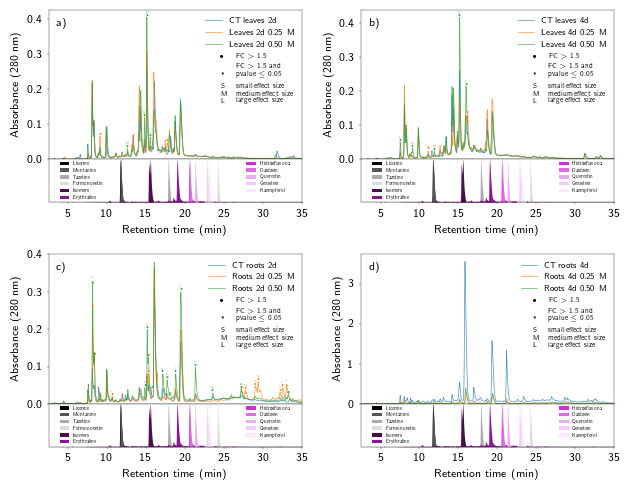

In [100]:
plots_em_x = 2
plots_em_y = 2
h_size     = 3.2 #tamanho horizontal do painel em polegadas
v_size     = 2.5 #tamanho vertical do painel em polegadas #h_size/1.618  #2.5
dpi = 700
tempo         = nacl_ori_normalizado_media['Time']

fig = plt.figure(figsize=(h_size * plots_em_x, v_size * plots_em_y))

lista_cores   = ['C0', 'C1','C2']
alpha = 0.8
lw=0.5
xlim_max     = 35
xlim_min     = 2.5
xticks       = [5, 10, 15, 20, 25, 30, 35]  #se lista vazia, python escolhe os numeros
xticks_label = ['5','10','15','20','25','30','35'] #se lista vazia, python escolhe os numeros
ylabel       = r'Absorbance (280 nm)'
xlabel       = r'Retention time (min)'
fontsize_legenda   = 6
fontsize_label     = 8 # tamanho das legendas e dos números do eixo
fontsize_letra     = 8 # tamanho da letra do painel
fontsize_circulo   = 3
fontsize_asterisco = 5
fontsize_t_efeito  = 2



yticks       = [ 0.0,0.1,0.2,0.3,0.4] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0','0.1','0.2','0.3','0.4']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 100 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'a)'
lista_nomes = ['FC242','FS252','FS502']
lista_plots   = [nacl_ori_normalizado_media['FC242'],
                 nacl_ori_normalizado_media['FS252'],
                 nacl_ori_normalizado_media['FS502'],]
         
#                  nacl_ori_normalizado_media['FC244'],
#                  nacl_ori_normalizado_media['FS254'],                 
#                  nacl_ori_normalizado_media['FS504'],
                 
#                  nacl_ori_normalizado_media['RC242'],
#                  nacl_ori_normalizado_media['RS252'],
#                  nacl_ori_normalizado_media['RS502'],
                
#                  nacl_ori_normalizado_media['RC244'],
#                  nacl_ori_normalizado_media['RS254'],
#                  nacl_ori_normalizado_media['RS504']]

lista_label   = ['CT leaves 2d','Leaves 2d 0.25 M','Leaves 2d 0.50 M',              
#                  'CT leaves 4d','Leaves 4d 0.25 M','Leaves 4d 0.50 M',             
#                  'CT roots 2d','Roots 2d 0.25 M','Roots 2d 0.50 M',             
#                  'CT roots 4d','Roots 4d 0.25 M','Roots 4d 0.50 M'            
                 ]


alpha_bottom = 1

cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']   


A = 0 #mudar o painel
B = 0 #mudar o painel

outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)
inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A, B],
            height_ratios=[3.5, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])

position = [
0.68, 0.6,
0.74, 0.64,
0.74, 0.59,
0.68, 0.51,
0.68, 0.46,
0.68, 0.41,
0.74, 0.51,
0.74, 0.46,
0.74, 0.41,
0.675, 0.71]
df_func=df_nacl
#mudar o df!!!
df_painel_a = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom)



###########################################################


yticks       = [ 0.0,0.1,0.2,0.3,0.4] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0','0.1','0.2','0.3','0.4']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 100 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'b)'
lista_nomes = ['FC244','FS254','FS504']
lista_plots   = [
                    #nacl_ori_normalizado_media['FC242'],
#                  nacl_ori_normalizado_media['FS252'],
#                  nacl_ori_normalizado_media['FS502'],]
         
                 nacl_ori_normalizado_media['FC244'],
                 nacl_ori_normalizado_media['FS254'],                 
                 nacl_ori_normalizado_media['FS504'],
                 
#                  nacl_ori_normalizado_media['RC242'],
#                  nacl_ori_normalizado_media['RS252'],
#                  nacl_ori_normalizado_media['RS502'],
                
#                  nacl_ori_normalizado_media['RC244'],
#                  nacl_ori_normalizado_media['RS254'],
#                  nacl_ori_normalizado_media['RS504']]
]
lista_label   = [#'CT leaves 2d','Leaves 2d 0.25 M','Leaves 2d 0.50 M',  
#                     'CT roots 2d','Roots 2d 0.25 M','Roots 2d 0.50 M',
                 'CT leaves 4d','Leaves 4d 0.25 M','Leaves 4d 0.50 M',                         
#                  'CT roots 4d','Roots 4d 0.25 M','Roots 4d 0.50 M'            
                 ]

cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']  

A = 0 #mudar o painel
B = 1 #mudar o painel

outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)
inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A, B], 
            height_ratios=[3.5, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])

position = [
0.68, 0.6,
0.74, 0.64,
0.74, 0.59,
0.68, 0.51,
0.68, 0.46,
0.68, 0.41,
0.74, 0.51,
0.74, 0.46,
0.74, 0.41,
0.675, 0.71]
df_func=df_nacl
#mudar o df!!!
df_painel_b = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom)





###########################################################


yticks       = [ 0.0,0.1,0.2,0.3,0.4] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0','0.1','0.2','0.3','0.4']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 100 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'c)'
lista_nomes = ['RC242','RS252','RS502']
lista_plots   = [
                    #nacl_ori_normalizado_media['FC242'],
#                  nacl_ori_normalizado_media['FS252'],
#                  nacl_ori_normalizado_media['FS502'],]
         
#                  nacl_ori_normalizado_media['FC244'],
#                  nacl_ori_normalizado_media['FS254'],                 
#                  nacl_ori_normalizado_media['FS504'],
                 
                 nacl_ori_normalizado_media['RC242'],
                 nacl_ori_normalizado_media['RS252'],
                 nacl_ori_normalizado_media['RS502'],
                
#                  nacl_ori_normalizado_media['RC244'],
#                  nacl_ori_normalizado_media['RS254'],
#                  nacl_ori_normalizado_media['RS504']]
]
lista_label   = [#'CT leaves 2d','Leaves 2d 0.25 M','Leaves 2d 0.50 M', 
                    'CT roots 2d','Roots 2d 0.25 M','Roots 2d 0.50 M',
#                  'CT leaves 4d','Leaves 4d 0.25 M','Leaves 4d 0.50 M',                                          
#                  'CT roots 4d','Roots 4d 0.25 M','Roots 4d 0.50 M'            
                 ]

cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']  

A = 1 #mudar o painel
B = 0 #mudar o painel

outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)
inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A, B],  
            height_ratios=[3.5, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])

position = [
0.68, 0.6,
0.74, 0.64,
0.74, 0.59,
0.68, 0.51,
0.68, 0.46,
0.68, 0.41,
0.74, 0.51,
0.74, 0.46,
0.74, 0.41,
0.675, 0.71]
df_func=df_nacl
#mudar o df!!!
df_painel_c = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom)




###########################################################


yticks       = [] #se lista vazia, python escolhe os numeros
yticks_label = []
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 100 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'd)'
lista_nomes = ['RC244','RS254','RS504']
lista_plots   = [
                    #nacl_ori_normalizado_media['FC242'],
#                  nacl_ori_normalizado_media['FS252'],
#                  nacl_ori_normalizado_media['FS502'],]
         
#                  nacl_ori_normalizado_media['FC244'],
#                  nacl_ori_normalizado_media['FS254'],                 
#                  nacl_ori_normalizado_media['FS504'],
                 
#                  nacl_ori_normalizado_media['RC242'],
#                  nacl_ori_normalizado_media['RS252'],
#                  nacl_ori_normalizado_media['RS502'],
                
                 nacl_ori_normalizado_media['RC244'],
                 nacl_ori_normalizado_media['RS254'],
                 nacl_ori_normalizado_media['RS504']
]
lista_label   = [#'CT leaves 2d','Leaves 2d 0.25 M','Leaves 2d 0.50 M',     
#                      'CT roots 2d','Roots 2d 0.25 M','Roots 2d 0.50 M', 
#                  'CT leaves 4d','Leaves 4d 0.25 M','Leaves 4d 0.50 M',             
                 'CT roots 4d','Roots 4d 0.25 M','Roots 4d 0.50 M'            
                 ]

cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']  

A = 1 #mudar o painel
B = 1 #mudar o painel

outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)
inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A, B],  
            height_ratios=[3.5, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])

position = [
0.68, 0.6,
0.74, 0.64,
0.74, 0.59,
0.68, 0.51,
0.68, 0.46,
0.68, 0.41,
0.74, 0.51,
0.74, 0.46,
0.74, 0.41,
0.675, 0.71]
df_func=df_nacl
#mudar o df!!!
df_painel_d = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom)


df_concatenado_nacl = pd.concat([df_painel_a, df_painel_b, df_painel_c, df_painel_d], axis=0)
df_concatenado_nacl

# plt.savefig('/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/graficos_suplementar/salino.pdf', bbox_inches='tight', pad_inches=0.1, transparent=True, dpi=dpi)
# plt.savefig('/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/graficos_suplementar/salino.tiff', bbox_inches='tight', pad_inches=0.1, transparent=True, dpi=dpi)


plt.savefig('/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/graficos_suplementar/salino.png', bbox_inches='tight', pad_inches=0.1, transparent=False, dpi=dpi)

# df_concatenado_nacl

# DANO MECÂNICO - DM

In [13]:
caminho_arquivo = r'/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/Final_figures/new/Figures/all_treatmens_final_normalizado2.xlsx'
df_dm = pd.read_excel(caminho_arquivo,sheet_name='dm')
df_dm

# df_dm = df_dm.drop(columns=["RC2441"])
# df_dm = df_dm.drop(columns=["RC2443"])
# df_dm.columns

# # Aplica a função a todas as colunas do DataFrame
# df_dm.columns = [renomear_colunas(col) for col in df_dm.columns]

# # Exibir as colunas renomeadas
# df_dm.columns


,Time,FC242-1,FC242-2,FC242-3,FC242-4,FC242-5,FC244-1,FC244-2,FC244-3,FC244-4,...,RDM32-4,RDM32-5,RDM14-2,RDM14-4,RDM14-5,RDM34-1,RDM34-2,RDM34-3,RDM34-4,RDM34-5
0,2.501628,0.000034,0.000034,0.000039,0.000049,0.000036,0.000066,0.000015,0.000054,0.000041,...,0.000050,0.000066,0.000080,0.000029,0.000041,0.000032,0.000036,0.000045,0.000038,0.000051
1,2.503294,0.000035,0.000035,0.000038,0.000051,0.000035,0.000067,0.000016,0.000051,0.000041,...,0.000050,0.000066,0.000077,0.000028,0.000042,0.000037,0.000036,0.000046,0.000037,0.000053
2,2.504961,0.000037,0.000035,0.000036,0.000053,0.000037,0.000068,0.000016,0.000048,0.000042,...,0.000050,0.000066,0.000071,0.000027,0.000041,0.000041,0.000035,0.000045,0.000037,0.000052
3,2.506628,0.000039,0.000035,0.000034,0.000053,0.000039,0.000069,0.000017,0.000048,0.000044,...,0.000050,0.000066,0.000071,0.000025,0.000040,0.000044,0.000034,0.000045,0.000039,0.000051
4,2.508294,0.000042,0.000032,0.000034,0.000051,0.000041,0.000070,0.000017,0.000045,0.000043,...,0.000050,0.000066,0.000068,0.000027,0.000040,0.000044,0.000032,0.000046,0.000042,0.000053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28490,49.993530,0.002079,0.002169,0.002202,0.002117,0.002260,0.002915,0.001634,0.002727,0.002406,...,0.002066,0.002076,0.006952,0.002042,0.001883,0.002246,0.002095,0.002033,0.002019,0.002623
28491,49.995200,0.002080,0.002167,0.002200,0.002119,0.002259,0.002915,0.001636,0.002726,0.002406,...,0.002065,0.002075,0.006954,0.002040,0.001882,0.002244,0.002097,0.002034,0.002020,0.002623
28492,49.996860,0.002081,0.002166,0.002200,0.002121,0.002259,0.002913,0.001638,0.002726,0.002407,...,0.002065,0.002075,0.006959,0.002040,0.001880,0.002242,0.002097,0.002036,0.002022,0.002624
28493,49.998530,0.002079,0.002167,0.002201,0.002123,0.002257,0.002910,0.001639,0.002725,0.002408,...,0.002066,0.002077,0.006964,0.002040,0.001879,0.002239,0.002098,0.002038,0.002027,0.002629


In [14]:
############# NORMALIZAÇÃO ###################
# dm_ori_normalizado = normalizacao_quimica(df_dm, 4260, 4738, 0.0942)
############# CRIAR DATA FRAME ###################
# caminho=r'E:\Doc\Cap 2 - Tratadas_HPLC_Evelu\Analise_HPLC\RESULTADOS_PROCESSADOS\Manuscrito\Plant_Biology\Re-submission\Final_figures\new'
# nome_arquivo=r'\dm_ori_normalizado.xlsx'
# arquivo=caminho+nome_arquivo

# dm_ori_normalizado.to_excel(arquivo, index=False)
dm_ori_normalizado = df_dm


dm_ori_normalizado_media = media_repbiologicas(dm_ori_normalizado)
dm_ori_normalizado_media


['Time', 'FC242', 'FC244', 'FDM12', 'FDM32', 'FDM14', 'FDM34', 'RC242', 'RC244', 'RDM12', 'RDM32', 'RDM14', 'RDM34']
[1. 5. 5. 5. 5. 5. 5. 5. 3. 5. 5. 3. 5.]


,Time,FC242,FC244,FDM12,FDM32,FDM14,FDM34,RC242,RC244,RDM12,RDM32,RDM14,RDM34
0,2.501628,0.000038,0.000042,0.000043,0.000046,0.000005,0.000044,0.000055,0.000150,0.000039,0.000051,0.000050,0.000041
1,2.503294,0.000039,0.000043,0.000042,0.000046,0.000005,0.000043,0.000055,0.000142,0.000039,0.000051,0.000049,0.000042
2,2.504961,0.000039,0.000043,0.000042,0.000046,0.000005,0.000042,0.000055,0.000138,0.000039,0.000051,0.000047,0.000042
3,2.506628,0.000040,0.000044,0.000042,0.000045,0.000006,0.000040,0.000055,0.000134,0.000039,0.000051,0.000046,0.000043
4,2.508294,0.000040,0.000043,0.000043,0.000045,0.000008,0.000039,0.000056,0.000134,0.000039,0.000051,0.000045,0.000043
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28490,49.993530,0.002166,0.002462,0.002058,0.002248,0.002406,0.002525,0.001955,0.013813,0.001793,0.001973,0.003626,0.002203
28491,49.995200,0.002165,0.002463,0.002058,0.002249,0.002406,0.002525,0.001955,0.013816,0.001794,0.001972,0.003625,0.002203
28492,49.996860,0.002165,0.002464,0.002058,0.002248,0.002407,0.002525,0.001955,0.013820,0.001795,0.001972,0.003626,0.002204
28493,49.998530,0.002165,0.002463,0.002058,0.002247,0.002407,0.002525,0.001954,0.013832,0.001796,0.001973,0.003628,0.002206


/tmp/ipykernel_46820/173820660.py:377: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pontos = pd.concat([df_pontos, pd.DataFrame([nova_linha])], ignore_index=True)
/tmp/ipykernel_46820/173820660.py:339: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pontos = pd.concat([df_pontos, pd.DataFrame([nova_linha])], ignore_index=True)
/tmp/ipykernel_46820/173820660.py:377: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this wi

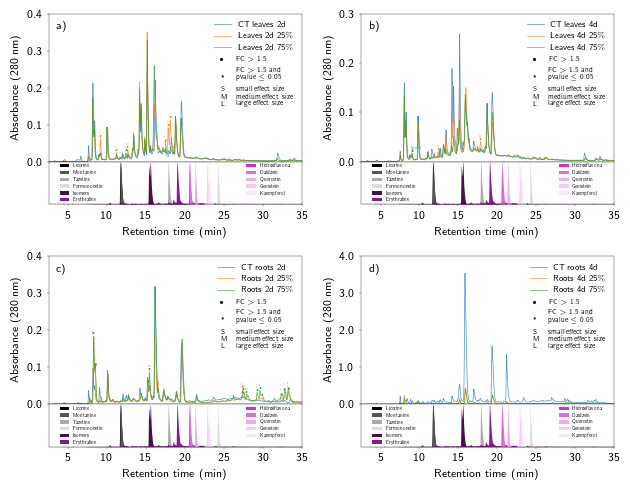

In [101]:
plots_em_x = 2
plots_em_y = 2
h_size     = 3.2 #tamanho horizontal do painel em polegadas
v_size     = 2.5 #tamanho vertical do painel em polegadas #h_size/1.618  #2.5
dpi = 700
tempo         = dm_ori_normalizado_media['Time']

fig = plt.figure(figsize=(h_size * plots_em_x, v_size * plots_em_y))

lista_cores   = ['C0', 'C1','C2']
alpha = 0.8
lw=0.5
xlim_max     = 35
xlim_min     = 2.5
xticks       = [5, 10, 15, 20, 25, 30, 35]  #se lista vazia, python escolhe os numeros
xticks_label = ['5','10','15','20','25','30','35'] #se lista vazia, python escolhe os numeros
ylabel       = r'Absorbance (280 nm)'
xlabel       = r'Retention time (min)'
fontsize_legenda   = 6
fontsize_label     = 8 # tamanho das legendas e dos números do eixo
fontsize_letra     = 8 # tamanho da letra do painel
fontsize_circulo   = 3
fontsize_asterisco = 5
fontsize_t_efeito  = 2



yticks       = [ 0.0,0.1,0.2,0.3,0.4] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0','0.1','0.2','0.3','0.4']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 100 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'a)'
lista_nomes = ['FC242','FDM12','FDM32']
lista_plots   = [dm_ori_normalizado_media['FC242'],
                dm_ori_normalizado_media['FDM12'],
                dm_ori_normalizado_media['FDM32']]

lista_label   = ['CT leaves 2d',r'Leaves 2d 25$\%$',r'Leaves 2d 75$\%$'
                 
                 ]


alpha_bottom = 1

cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']   


A = 0 #mudar o painel
B = 0 #mudar o painel

outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)
inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A, B],
            height_ratios=[3.5, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])

position = [
0.68, 0.6,
0.74, 0.64,
0.74, 0.59,
0.68, 0.51,
0.68, 0.46,
0.68, 0.41,
0.74, 0.51,
0.74, 0.46,
0.74, 0.41,
0.675, 0.71]
df_func=df_dm
#mudar o df!!!
df_painel_a = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom)



###########################################################


yticks       = [ 0.0,0.1,0.2,0.3] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0','0.1','0.2','0.3']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 100 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'b)'
lista_nomes = ['FC244','FDM14','FDM34']
lista_plots   = [dm_ori_normalizado_media['FC244'],
                 dm_ori_normalizado_media['FDM14'],                 
                 dm_ori_normalizado_media['FDM34']
]
lista_label   = ['CT leaves 4d',r'Leaves 4d 25$\%$',r'Leaves 4d 75$\%$',         
                 ]

cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']  

A = 0 #mudar o painel
B = 1 #mudar o painel

outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)
inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A, B], 
            height_ratios=[3.5, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])

position = [
0.68, 0.6,
0.74, 0.64,
0.74, 0.59,
0.68, 0.51,
0.68, 0.46,
0.68, 0.41,
0.74, 0.51,
0.74, 0.46,
0.74, 0.41,
0.675, 0.71]
df_func=df_dm
#mudar o df!!!
df_painel_b = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom)





###########################################################


yticks       = [ 0.0,0.1,0.2,0.3,0.4] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0','0.1','0.2','0.3','0.4']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 100 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'c)'
lista_nomes = ['RC242','RDM12','RDM32']
lista_plots   = [dm_ori_normalizado_media['RC242'],
                 dm_ori_normalizado_media['RDM12'],
                 dm_ori_normalizado_media['RDM32'],
]
lista_label   = ['CT roots 2d',r'Roots 2d 25$\%$',r'Roots 2d 75$\%$'            
                 ]

cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']  

A = 1 #mudar o painel
B = 0 #mudar o painel

outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)
inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A, B],  
            height_ratios=[3.5, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])

position = [
0.68, 0.6,
0.74, 0.64,
0.74, 0.59,
0.68, 0.51,
0.68, 0.46,
0.68, 0.41,
0.74, 0.51,
0.74, 0.46,
0.74, 0.41,
0.675, 0.71]
df_func=df_dm
#mudar o df!!!
df_painel_c = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom)




###########################################################


yticks       = [0.0,1.0,2.0,3.0,4.0] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0','1.0','2.0','3.0','4.0']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 100 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'd)'
lista_nomes = ['RC244','RDM14','RDM34']
lista_plots   = [dm_ori_normalizado_media['RC244'],
                 dm_ori_normalizado_media['RDM14'],
                 dm_ori_normalizado_media['RDM34']
]
lista_label   = ['CT roots 4d',r'Roots 4d 25$\%$',r'Roots 4d 75$\%$'          
                 ]

cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']  

A = 1 #mudar o painel
B = 1 #mudar o painel

outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)
inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A, B],  
            height_ratios=[3.5, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])

position = [
0.68, 0.6,
0.74, 0.64,
0.74, 0.59,
0.68, 0.51,
0.68, 0.46,
0.68, 0.41,
0.74, 0.51,
0.74, 0.46,
0.74, 0.41,
0.675, 0.71]
df_func=df_dm
#mudar o df!!!
df_painel_d = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom)


df_concatenado_dm = pd.concat([df_painel_a, df_painel_b, df_painel_c, df_painel_d], axis=0)
df_concatenado_dm

# plt.savefig('/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/graficos_suplementar/dm.pdf', bbox_inches='tight', pad_inches=0.1, transparent=True, dpi=dpi)
# plt.savefig('/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/graficos_suplementar/dm.tiff', bbox_inches='tight', pad_inches=0.1, transparent=True, dpi=dpi)

plt.savefig('/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/graficos_suplementar/dm.png', bbox_inches='tight', pad_inches=0.1, transparent=False, dpi=dpi)

# df_concatenado_nacl

# MEJA

In [15]:
caminho_arquivo = r'/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/Final_figures/new/Figures/all_treatmens_final_normalizado2.xlsx'
df_meja = pd.read_excel(caminho_arquivo,sheet_name='meja')
df_meja

# # Aplica a função a todas as colunas do DataFrame
# df_meja.columns = [renomear_colunas(col) for col in df_meja.columns]

# # Exibir as colunas renomeadas
# df_meja


,Time,FC682-1,FC682-2,FC682-3,FC682-4,FC682-5,FC684-1,FC684-2,FC684-3,FC684-4,...,RMJ404-1,RMJ404-2,RMJ404-3,RMJ404-4,RMJ404-5,RMJ1004-1,RMJ1004-2,RMJ1004-3,RMJ1004-4,RMJ1004-5
0,2.501628,0.000051,0.000032,0.000042,0.000031,0.000028,0.000044,0.000034,0.000024,0.000034,...,0.000053,0.000053,0.000060,0.000042,0.000036,0.000072,0.000082,0.000040,0.000049,0.000053
1,2.503294,0.000052,0.000030,0.000042,0.000031,0.000028,0.000045,0.000033,0.000025,0.000035,...,0.000051,0.000050,0.000061,0.000041,0.000035,0.000068,0.000081,0.000040,0.000052,0.000054
2,2.504961,0.000051,0.000029,0.000042,0.000031,0.000028,0.000045,0.000034,0.000025,0.000034,...,0.000051,0.000050,0.000063,0.000041,0.000034,0.000064,0.000082,0.000038,0.000055,0.000051
3,2.506628,0.000050,0.000028,0.000042,0.000031,0.000030,0.000044,0.000033,0.000025,0.000034,...,0.000051,0.000049,0.000062,0.000040,0.000033,0.000062,0.000081,0.000039,0.000054,0.000050
4,2.508294,0.000049,0.000029,0.000042,0.000031,0.000031,0.000043,0.000034,0.000026,0.000034,...,0.000051,0.000047,0.000063,0.000039,0.000033,0.000061,0.000082,0.000037,0.000052,0.000051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28490,49.993530,0.001856,0.001929,0.001966,0.001830,0.001827,0.001590,0.001818,0.001131,0.001653,...,0.000842,0.001572,0.001231,0.001366,0.001267,0.001870,0.002674,0.001779,0.001702,0.001745
28491,49.995200,0.001856,0.001929,0.001969,0.001829,0.001827,0.001590,0.001813,0.001131,0.001652,...,0.000841,0.001574,0.001230,0.001367,0.001268,0.001870,0.002676,0.001780,0.001702,0.001744
28492,49.996860,0.001856,0.001929,0.001971,0.001828,0.001827,0.001589,0.001806,0.001132,0.001650,...,0.000839,0.001577,0.001229,0.001365,0.001268,0.001871,0.002681,0.001780,0.001701,0.001745
28493,49.998530,0.001856,0.001929,0.001972,0.001829,0.001827,0.001589,0.001803,0.001132,0.001647,...,0.000838,0.001576,0.001227,0.001364,0.001269,0.001869,0.002686,0.001782,0.001699,0.001744


In [16]:
# for i in range(1,61): #numero das amostras
#     plt.plot(df_meja['Time'][4470:4738],df_meja[df_meja.columns[i]][4470:4738], lw=0.4) 

############# NORMALIZAÇÃO ###################
# meja_ori_normalizado = normalizacao_quimica(df_meja, 4470, 4738, 0.0942)
# ############# CRIAR DATA FRAME ###################
# caminho=r'E:\Doc\Cap 2 - Tratadas_HPLC_Evelu\Analise_HPLC\RESULTADOS_PROCESSADOS\Manuscrito\Plant_Biology\Re-submission\Final_figures\new'
# nome_arquivo=r'\meja_ori_normalizado.xlsx'
# arquivo=caminho+nome_arquivo

# meja_ori_normalizado.to_excel(arquivo, index=False)
meja_ori_normalizado = df_meja

meja_ori_normalizado_media = media_repbiologicas(meja_ori_normalizado)
meja_ori_normalizado_media


['Time', 'FC682', 'FC684', 'FMJ402', 'FMJ1002', 'FMJ404', 'FMJ1004', 'RC682', 'RC684', 'RMJ402', 'RMJ1002', 'RMJ404', 'RMJ1004']
[1. 5. 5. 5. 5. 5. 5. 4. 5. 5. 5. 5. 5.]


,Time,FC682,FC684,FMJ402,FMJ1002,FMJ404,FMJ1004,RC682,RC684,RMJ402,RMJ1002,RMJ404,RMJ1004
0,2.501628,0.000037,0.000036,0.000033,0.000034,0.000041,0.000005,0.000033,0.000059,0.000030,0.000045,0.000049,0.000059
1,2.503294,0.000037,0.000036,0.000033,0.000034,0.000042,0.000005,0.000034,0.000059,0.000031,0.000044,0.000048,0.000059
2,2.504961,0.000036,0.000037,0.000033,0.000033,0.000043,0.000006,0.000035,0.000058,0.000031,0.000044,0.000048,0.000058
3,2.506628,0.000036,0.000036,0.000034,0.000033,0.000043,0.000007,0.000034,0.000056,0.000031,0.000044,0.000047,0.000057
4,2.508294,0.000037,0.000036,0.000035,0.000034,0.000043,0.000009,0.000033,0.000055,0.000031,0.000045,0.000047,0.000057
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28490,49.993530,0.001882,0.001613,0.001493,0.001661,0.001946,0.002066,0.002249,0.001677,0.001049,0.001259,0.001256,0.001954
28491,49.995200,0.001882,0.001612,0.001493,0.001661,0.001946,0.002067,0.002248,0.001676,0.001049,0.001259,0.001256,0.001954
28492,49.996860,0.001882,0.001610,0.001493,0.001661,0.001946,0.002068,0.002248,0.001675,0.001048,0.001259,0.001256,0.001956
28493,49.998530,0.001882,0.001610,0.001493,0.001661,0.001945,0.002068,0.002250,0.001673,0.001050,0.001259,0.001255,0.001956


/tmp/ipykernel_46820/173820660.py:377: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pontos = pd.concat([df_pontos, pd.DataFrame([nova_linha])], ignore_index=True)
/tmp/ipykernel_46820/173820660.py:339: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pontos = pd.concat([df_pontos, pd.DataFrame([nova_linha])], ignore_index=True)
/tmp/ipykernel_46820/173820660.py:339: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this wi

1
2


/tmp/ipykernel_46820/173820660.py:339: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pontos = pd.concat([df_pontos, pd.DataFrame([nova_linha])], ignore_index=True)
/tmp/ipykernel_46820/173820660.py:377: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pontos = pd.concat([df_pontos, pd.DataFrame([nova_linha])], ignore_index=True)
/tmp/ipykernel_46820/173820660.py:377: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this wi

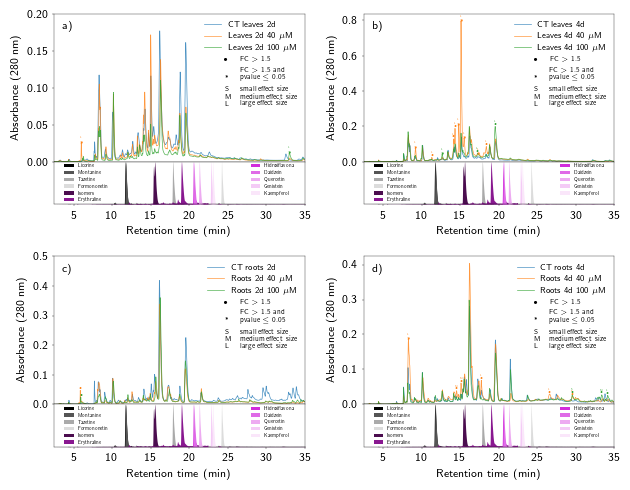

In [102]:
plots_em_x = 2
plots_em_y = 2
h_size     = 3.2 #tamanho horizontal do painel em polegadas
v_size     = 2.5 #tamanho vertical do painel em polegadas #h_size/1.618  #2.5
dpi = 700
tempo         = meja_ori_normalizado_media['Time']

fig = plt.figure(figsize=(h_size * plots_em_x, v_size * plots_em_y))

lista_cores   = ['C0', 'C1','C2']
alpha = 0.8
lw=0.5
xlim_max     = 35
xlim_min     = 2.5
xticks       = [5, 10, 15, 20, 25, 30, 35]  #se lista vazia, python escolhe os numeros
xticks_label = ['5','10','15','20','25','30','35'] #se lista vazia, python escolhe os numeros
ylabel       = r'Absorbance (280 nm)'
xlabel       = r'Retention time (min)'
fontsize_legenda   = 6
fontsize_label     = 8 # tamanho das legendas e dos números do eixo
fontsize_letra     = 8 # tamanho da letra do painel
fontsize_circulo   = 3
fontsize_asterisco = 5
fontsize_t_efeito  = 2



yticks       = [ 0.00,0.05,0.10,0.15,0.20] #se lista vazia, python escolhe os numeros
yticks_label = ['0.00','0.05','0.10','0.15','0.20']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 100 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'a)'
lista_nomes = ['FC682','FMJ402','FMJ1002']
lista_plots   = [meja_ori_normalizado_media['FC682'],
                meja_ori_normalizado_media['FMJ402'],
                meja_ori_normalizado_media['FMJ1002']]

lista_label   = ['CT leaves 2d','Leaves 2d 40 $\\mu$M','Leaves 2d 100 $\\mu$M'
                 
                 ]


alpha_bottom = 1

cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']   


A = 0 #mudar o painel
B = 0 #mudar o painel

outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)
inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A, B],
            height_ratios=[3.5, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])

position = [
0.68, 0.6,
0.74, 0.64,
0.74, 0.59,
0.68, 0.51,
0.68, 0.46,
0.68, 0.41,
0.74, 0.51,
0.74, 0.46,
0.74, 0.41,
0.675, 0.71]
df_func=df_meja
#mudar o df!!!
df_painel_a = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom)



###########################################################


yticks       = [ 0.0,0.2,0.4,0.6,0.8] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0','0.2','0.4','0.6','0.8']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 100 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'b)'
lista_nomes = ['FC684','FMJ404','FMJ1004']
lista_plots   = [meja_ori_normalizado_media['FC684'],
                 meja_ori_normalizado_media['FMJ404'],                 
                 meja_ori_normalizado_media['FMJ1004'],
]
lista_label   = ['CT leaves 4d','Leaves 4d 40 $\\mu$M','Leaves 4d 100 $\\mu$M',         
                 ]

cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']  

A = 0 #mudar o painel
B = 1 #mudar o painel

outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)
inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A, B], 
            height_ratios=[3.5, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])

position = [
0.68, 0.6,
0.74, 0.64,
0.74, 0.59,
0.68, 0.51,
0.68, 0.46,
0.68, 0.41,
0.74, 0.51,
0.74, 0.46,
0.74, 0.41,
0.675, 0.71]
df_func=df_meja
#mudar o df!!!
df_painel_b = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom)





###########################################################


yticks       = [ 0.0,0.1,0.2,0.3,0.4,0.5] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0','0.1','0.2','0.3','0.4','0.5']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 100 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'c)'
lista_nomes = ['RC242','RDM12','RDM32']
lista_plots   = [meja_ori_normalizado_media['RC682'],
                 meja_ori_normalizado_media['RMJ402'],
                 meja_ori_normalizado_media['RMJ1002'],
]
lista_label   = ['CT roots 2d','Roots 2d 40 $\\mu$M','Roots 2d 100 $\\mu$M'            
                 ]

cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']  

A = 1 #mudar o painel
B = 0 #mudar o painel

outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)
inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A, B],  
            height_ratios=[3.5, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])

position = [
0.68, 0.6,
0.74, 0.64,
0.74, 0.59,
0.68, 0.51,
0.68, 0.46,
0.68, 0.41,
0.74, 0.51,
0.74, 0.46,
0.74, 0.41,
0.675, 0.71]
df_func=df_meja
#mudar o df!!!
df_painel_c = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom)




###########################################################


yticks       = [0.0,0.1,0.2,0.3,0.4] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0','0.1','0.2','0.3','0.4']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 100 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'd)'
lista_nomes = ['RC684','RMJ404','RMJ1004']
lista_plots   = [meja_ori_normalizado_media['RC684'],
                 meja_ori_normalizado_media['RMJ404'],
                 meja_ori_normalizado_media['RMJ1004']
]
lista_label   = ['CT roots 4d','Roots 4d 40 $\\mu$M','Roots 4d 100 $\\mu$M'          
                 ]

cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']  

A = 1 #mudar o painel
B = 1 #mudar o painel

outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)
inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A, B],  
            height_ratios=[3.5, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])

position = [
0.68, 0.6,
0.74, 0.64,
0.74, 0.59,
0.68, 0.51,
0.68, 0.46,
0.68, 0.41,
0.74, 0.51,
0.74, 0.46,
0.74, 0.41,
0.675, 0.71]
df_func=df_meja
#mudar o df!!!
df_painel_d = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom)


df_concatenado_meja = pd.concat([df_painel_a, df_painel_b, df_painel_c, df_painel_d], axis=0)
df_concatenado_meja

# plt.savefig('/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/graficos_suplementar/meja.pdf', bbox_inches='tight', pad_inches=0.1, transparent=True, dpi=dpi)
# plt.savefig('/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/graficos_suplementar/meja.tiff', bbox_inches='tight', pad_inches=0.1, transparent=True, dpi=dpi)

plt.savefig('/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/graficos_suplementar/meja.png', bbox_inches='tight', pad_inches=0.1, transparent=False, dpi=dpi)

# df_concatenado_nacl

# ACIDO SALICÍLICO

In [17]:
caminho_arquivo = r'/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/Final_figures/new/Figures/all_treatmens_final_normalizado2.xlsx'
df_as = pd.read_excel(caminho_arquivo,sheet_name='as')
df_as

# # Aplica a função a todas as colunas do DataFrame
# df_as.columns = [renomear_colunas(col) for col in df_as.columns]

# # Exibir as colunas renomeadas
# df_as


,Time,FC682-1,FC682-2,FC682-3,FC682-4,FC682-5,FC684-1,FC684-2,FC684-3,FC684-4,...,RAS22-4,RAS22-5,RAS14-1,RAS14-2,RAS14-3,RAS14-4,RAS14-5,RAS24-1,RAS24-2,RAS24-4
0,2.501628,0.000042,0.000034,0.000042,0.000031,0.000040,0.000044,0.000034,0.000024,0.000034,...,0.000045,0.000062,0.000033,0.000048,0.000044,0.000075,0.000052,0.000059,0.000053,0.000056
1,2.503294,0.000044,0.000031,0.000041,0.000030,0.000037,0.000045,0.000033,0.000025,0.000035,...,0.000046,0.000063,0.000031,0.000051,0.000043,0.000072,0.000053,0.000059,0.000053,0.000055
2,2.504961,0.000045,0.000030,0.000038,0.000027,0.000035,0.000045,0.000034,0.000025,0.000034,...,0.000045,0.000064,0.000027,0.000052,0.000043,0.000070,0.000054,0.000059,0.000053,0.000057
3,2.506628,0.000046,0.000029,0.000037,0.000024,0.000032,0.000044,0.000033,0.000025,0.000034,...,0.000044,0.000064,0.000028,0.000050,0.000043,0.000069,0.000056,0.000057,0.000051,0.000059
4,2.508294,0.000045,0.000029,0.000036,0.000023,0.000029,0.000043,0.000034,0.000026,0.000034,...,0.000043,0.000064,0.000028,0.000049,0.000044,0.000067,0.000056,0.000056,0.000050,0.000061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28490,49.993530,0.001858,0.001932,0.001956,0.001822,0.001822,0.001590,0.001818,0.001131,0.001653,...,0.001405,0.001640,0.001247,0.001438,0.001546,0.001670,0.001526,0.001800,0.001545,0.001675
28491,49.995200,0.001857,0.001933,0.001954,0.001822,0.001823,0.001590,0.001813,0.001131,0.001652,...,0.001406,0.001641,0.001246,0.001440,0.001547,0.001669,0.001528,0.001801,0.001548,0.001679
28492,49.996860,0.001858,0.001932,0.001954,0.001822,0.001825,0.001589,0.001806,0.001132,0.001650,...,0.001405,0.001641,0.001246,0.001441,0.001549,0.001667,0.001529,0.001801,0.001548,0.001680
28493,49.998530,0.001858,0.001930,0.001954,0.001822,0.001826,0.001589,0.001803,0.001132,0.001647,...,0.001404,0.001640,0.001246,0.001442,0.001551,0.001668,0.001528,0.001800,0.001549,0.001681


In [18]:
# for i in range(50,61): #numero das amostras
#     plt.plot(df_as['Time'][4440:4738],df_as[df_as.columns[i]][4440:4738], lw=0.4) 

############# NORMALIZAÇÃO ###################
# as_ori_normalizado = normalizacao_quimica(df_as, 4440, 4738, 0.0942)
############# CRIAR DATA FRAME ###################
# caminho=r'E:\Doc\Cap 2 - Tratadas_HPLC_Evelu\Analise_HPLC\RESULTADOS_PROCESSADOS\Manuscrito\Plant_Biology\Re-submission\Final_figures\new'
# nome_arquivo=r'\as_ori_normalizado.xlsx'
# arquivo=caminho+nome_arquivo

# as_ori_normalizado.to_excel(arquivo, index=False)
as_ori_normalizado = df_as


as_ori_normalizado_media = media_repbiologicas(as_ori_normalizado)
as_ori_normalizado_media

['Time', 'FC682', 'FC684', 'FAS12', 'FAS22', 'FAS14', 'FAS24', 'RC682', 'RC684', 'RAS12', 'RAS22', 'RAS14', 'RAS24']
[1. 5. 5. 5. 5. 5. 5. 4. 5. 5. 4. 5. 3.]


,Time,FC682,FC684,FAS12,FAS22,FAS14,FAS24,RC682,RC684,RAS12,RAS22,RAS14,RAS24
0,2.501628,0.000038,0.000036,0.000044,0.000046,0.000045,0.000040,0.000033,0.000059,0.000111,0.000047,0.000051,0.000056
1,2.503294,0.000037,0.000036,0.000044,0.000046,0.000043,0.000040,0.000034,0.000059,0.000110,0.000047,0.000050,0.000056
2,2.504961,0.000035,0.000037,0.000044,0.000045,0.000042,0.000040,0.000035,0.000058,0.000109,0.000048,0.000049,0.000056
3,2.506628,0.000034,0.000036,0.000044,0.000045,0.000040,0.000040,0.000034,0.000056,0.000110,0.000049,0.000049,0.000056
4,2.508294,0.000032,0.000036,0.000043,0.000044,0.000040,0.000040,0.000033,0.000055,0.000112,0.000050,0.000049,0.000056
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28490,49.993530,0.001878,0.001613,0.002127,0.001984,0.001703,0.001995,0.002249,0.001677,0.002573,0.001878,0.001485,0.001674
28491,49.995200,0.001878,0.001612,0.002128,0.001984,0.001701,0.001995,0.002248,0.001676,0.002572,0.001877,0.001486,0.001676
28492,49.996860,0.001878,0.001610,0.002129,0.001984,0.001699,0.001993,0.002248,0.001675,0.002571,0.001875,0.001486,0.001677
28493,49.998530,0.001878,0.001610,0.002130,0.001984,0.001698,0.001991,0.002250,0.001673,0.002570,0.001874,0.001487,0.001677


/tmp/ipykernel_46820/173820660.py:377: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pontos = pd.concat([df_pontos, pd.DataFrame([nova_linha])], ignore_index=True)
/tmp/ipykernel_46820/173820660.py:339: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pontos = pd.concat([df_pontos, pd.DataFrame([nova_linha])], ignore_index=True)
/tmp/ipykernel_46820/173820660.py:339: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this wi

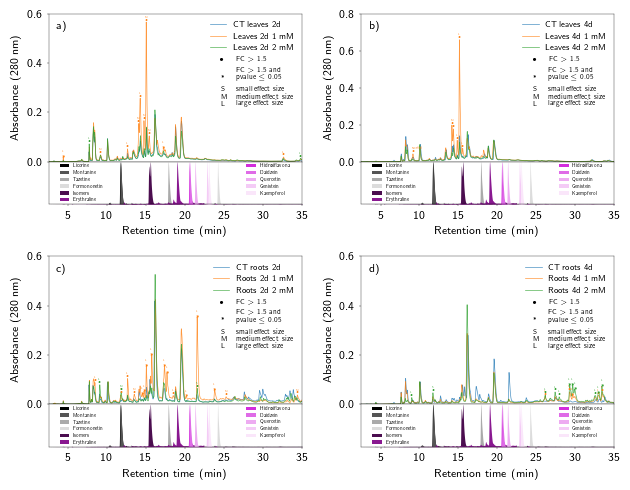

In [103]:
plots_em_x = 2
plots_em_y = 2
h_size     = 3.2 #tamanho horizontal do painel em polegadas
v_size     = 2.5 #tamanho vertical do painel em polegadas #h_size/1.618  #2.5
dpi = 700
tempo         = as_ori_normalizado_media['Time']

fig = plt.figure(figsize=(h_size * plots_em_x, v_size * plots_em_y))

lista_cores   = ['C0', 'C1','C2']
alpha = 0.8
lw=0.5
xlim_max     = 35
xlim_min     = 2.5
xticks       = [5, 10, 15, 20, 25, 30, 35]  #se lista vazia, python escolhe os numeros
xticks_label = ['5','10','15','20','25','30','35'] #se lista vazia, python escolhe os numeros
ylabel       = r'Absorbance (280 nm)'
xlabel       = r'Retention time (min)'
fontsize_legenda   = 6
fontsize_label     = 8 # tamanho das legendas e dos números do eixo
fontsize_letra     = 8 # tamanho da letra do painel
fontsize_circulo   = 3
fontsize_asterisco = 5
fontsize_t_efeito  = 2



yticks       = [ 0.0,0.2,0.4,0.6] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0','0.2','0.4','0.6']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 100 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'a)'
lista_nomes = ['FC682','FAS12','FAS22']
lista_plots   = [as_ori_normalizado_media['FC682'],
                 as_ori_normalizado_media['FAS12'],
                 as_ori_normalizado_media['FAS22'],
                ]
lista_label   = ['CT leaves 2d','Leaves 2d 1 mM','Leaves 2d 2 mM'
                 
                 ]


alpha_bottom = 1

cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']   


A = 0 #mudar o painel
B = 0 #mudar o painel

outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)
inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A, B],
            height_ratios=[3.5, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])

position = [
0.68, 0.6,
0.74, 0.64,
0.74, 0.59,
0.68, 0.51,
0.68, 0.46,
0.68, 0.41,
0.74, 0.51,
0.74, 0.46,
0.74, 0.41,
0.675, 0.71]
df_func=df_as
#mudar o df!!!
df_painel_a = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom)



###########################################################


yticks       = [ 0.0,0.2,0.4,0.6,0.8] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0','0.2','0.4','0.6','0.8']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 100 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'b)'
lista_nomes = ['FC684','FAS14','FAS24']
lista_plots   = [as_ori_normalizado_media['FC684'],
                 as_ori_normalizado_media['FAS14'],                 
                 as_ori_normalizado_media['FAS24'],
]
lista_label   = ['CT leaves 4d','Leaves 4d 1 mM','Leaves 4d 2 mM'         
                 ]

cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']  

A = 0 #mudar o painel
B = 1 #mudar o painel

outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)
inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A, B], 
            height_ratios=[3.5, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])

position = [
0.68, 0.6,
0.74, 0.64,
0.74, 0.59,
0.68, 0.51,
0.68, 0.46,
0.68, 0.41,
0.74, 0.51,
0.74, 0.46,
0.74, 0.41,
0.675, 0.71]
df_func=df_as
#mudar o df!!!
df_painel_b = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom)





###########################################################


yticks       = [0.0,0.2,0.4,0.6] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0','0.2','0.4','0.6']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 100 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'c)'
lista_nomes = ['RC682','RAS12','RAS22']
lista_plots   = [as_ori_normalizado_media['RC682'],
                 as_ori_normalizado_media['RAS12'],
                 as_ori_normalizado_media['RAS22'],
]
lista_label   = ['CT roots 2d','Roots 2d 1 mM','Roots 2d 2 mM'          
                 ]

cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']  

A = 1 #mudar o painel
B = 0 #mudar o painel

outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)
inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A, B],  
            height_ratios=[3.5, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])

position = [
0.68, 0.6,
0.74, 0.64,
0.74, 0.59,
0.68, 0.51,
0.68, 0.46,
0.68, 0.41,
0.74, 0.51,
0.74, 0.46,
0.74, 0.41,
0.675, 0.71]
df_func=df_as
#mudar o df!!!
df_painel_c = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom)




###########################################################


yticks       = [0.0,0.2,0.4,0.6] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0','0.2','0.4','0.6']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 100 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'd)'
lista_nomes = ['RC684','RAS14','RAS24']
lista_plots   = [as_ori_normalizado_media['RC684'],
                 as_ori_normalizado_media['RAS14'],
                 as_ori_normalizado_media['RAS24']
]
lista_label   = ['CT roots 4d','Roots 4d 1 mM','Roots 4d 2 mM'          
                 ]

cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']  

A = 1 #mudar o painel
B = 1 #mudar o painel

outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)
inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A, B],  
            height_ratios=[3.5, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])

position = [
0.68, 0.6,
0.74, 0.64,
0.74, 0.59,
0.68, 0.51,
0.68, 0.46,
0.68, 0.41,
0.74, 0.51,
0.74, 0.46,
0.74, 0.41,
0.675, 0.71]
df_func=df_as
#mudar o df!!!
df_painel_d = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom)


df_concatenado_as = pd.concat([df_painel_a, df_painel_b, df_painel_c, df_painel_d], axis=0)
df_concatenado_as

# plt.savefig('/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/graficos_suplementar/as.pdf', bbox_inches='tight', pad_inches=0.1, transparent=True, dpi=dpi)
# plt.savefig('/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/graficos_suplementar/as.tiff', bbox_inches='tight', pad_inches=0.1, transparent=True, dpi=dpi)

plt.savefig('/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/graficos_suplementar/as.png', bbox_inches='tight', pad_inches=0.1, transparent=False, dpi=dpi)

# df_concatenado_nacl

# SNP

In [19]:
caminho_arquivo = r'/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/Final_figures/new/Figures/all_treatmens_final_normalizado2.xlsx'
df_snp = pd.read_excel(caminho_arquivo,sheet_name='snp')
df_snp

# Aplica a função a todas as colunas do DataFrame
# df_snp.columns = [renomear_colunas(col) for col in df_snp.columns]

# # Exibir as colunas renomeadas
# df_snp

,Time,FC682-1,FC682-2,FC682-3,FC682-4,FC682-5,FC684-1,FC684-2,FC684-3,FC684-4,...,RSNP1004-1,RSNP1004-2,RSNP1004-3,RSNP1004-4,RSNP1004-5,RSNP2004-1,RSNP2004-2,RSNP2004-3,RSNP2004-4,RSNP2004-5
0,2.501628,0.000042,0.000034,0.000042,0.000031,0.000040,0.000044,0.000034,0.000025,0.000034,...,0.000032,0.000044,0.000040,0.000062,0.000177,0.000232,0.000061,0.000089,0.000047,0.000057
1,2.503294,0.000044,0.000031,0.000041,0.000030,0.000037,0.000044,0.000035,0.000026,0.000034,...,0.000032,0.000045,0.000041,0.000068,0.000183,0.000251,0.000062,0.000094,0.000049,0.000056
2,2.504961,0.000045,0.000030,0.000038,0.000027,0.000035,0.000044,0.000038,0.000025,0.000034,...,0.000033,0.000048,0.000041,0.000075,0.000187,0.000271,0.000062,0.000099,0.000049,0.000057
3,2.506628,0.000046,0.000029,0.000037,0.000024,0.000032,0.000045,0.000040,0.000025,0.000034,...,0.000034,0.000049,0.000041,0.000080,0.000192,0.000291,0.000062,0.000103,0.000050,0.000057
4,2.508294,0.000045,0.000029,0.000036,0.000023,0.000029,0.000045,0.000044,0.000026,0.000034,...,0.000033,0.000052,0.000040,0.000084,0.000198,0.000310,0.000060,0.000107,0.000048,0.000058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28490,49.993530,0.001858,0.001932,0.001956,0.001822,0.001822,0.001590,0.001818,0.001131,0.001653,...,0.001432,0.001599,0.001182,0.001281,0.001228,0.001280,0.001305,0.001112,0.001158,0.001283
28491,49.995200,0.001857,0.001933,0.001954,0.001822,0.001823,0.001590,0.001813,0.001131,0.001652,...,0.001431,0.001600,0.001180,0.001279,0.001228,0.001279,0.001306,0.001112,0.001158,0.001283
28492,49.996860,0.001858,0.001932,0.001954,0.001822,0.001825,0.001589,0.001806,0.001132,0.001650,...,0.001431,0.001600,0.001178,0.001277,0.001228,0.001277,0.001306,0.001112,0.001160,0.001281
28493,49.998530,0.001858,0.001930,0.001954,0.001822,0.001826,0.001589,0.001803,0.001132,0.001647,...,0.001432,0.001600,0.001178,0.001277,0.001228,0.001276,0.001306,0.001111,0.001164,0.001278


In [20]:

# for i in range(50,60): #numero das amostras
#     plt.plot(df_snp['Time'][4440:4738],df_snp[df_snp.columns[i]][4440:4738], lw=0.4) 

############# NORMALIZAÇÃO ###################
# snp_ori_normalizado = normalizacao_quimica(df_snp, 4440, 4738, 0.0942)
############# CRIAR DATA FRAME ###################
# caminho=r'E:\Doc\Cap 2 - Tratadas_HPLC_Evelu\Analise_HPLC\RESULTADOS_PROCESSADOS\Manuscrito\Plant_Biology\Re-submission\Final_figures\new'
# nome_arquivo=r'\snp_ori_normalizado.xlsx'
# arquivo=caminho+nome_arquivo

# snp_ori_normalizado.to_excel(arquivo, index=False)
snp_ori_normalizado = df_snp

snp_ori_normalizado_media = media_repbiologicas(snp_ori_normalizado)
snp_ori_normalizado_media

['Time', 'FC682', 'FC684', 'FSNP1002', 'FSNP2002', 'FSNP1004', 'FSNP2004', 'RC682', 'RC684', 'RSNP1002', 'RSNP2002', 'RSNP1004', 'RSNP2004']
[1. 5. 5. 5. 5. 5. 5. 4. 5. 4. 4. 5. 5.]


,Time,FC682,FC684,FSNP1002,FSNP2002,FSNP1004,FSNP2004,RC682,RC684,RSNP1002,RSNP2002,RSNP1004,RSNP2004
0,2.501628,0.000038,0.000036,0.000078,0.000173,0.000055,0.000321,0.000033,0.000059,0.000066,0.000270,0.000071,0.000097
1,2.503294,0.000037,0.000036,0.000078,0.000170,0.000055,0.000323,0.000034,0.000059,0.000068,0.000277,0.000074,0.000102
2,2.504961,0.000035,0.000037,0.000079,0.000168,0.000055,0.000323,0.000035,0.000058,0.000069,0.000284,0.000077,0.000108
3,2.506628,0.000034,0.000037,0.000079,0.000166,0.000056,0.000323,0.000034,0.000056,0.000070,0.000290,0.000079,0.000113
4,2.508294,0.000032,0.000038,0.000081,0.000165,0.000056,0.000323,0.000033,0.000055,0.000071,0.000293,0.000081,0.000117
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28490,49.993530,0.001878,0.001613,0.002155,0.002101,0.001875,0.001839,0.002249,0.001677,0.001744,0.003073,0.001344,0.001228
28491,49.995200,0.001878,0.001612,0.002156,0.002101,0.001874,0.001840,0.002248,0.001676,0.001745,0.003073,0.001344,0.001228
28492,49.996860,0.001878,0.001610,0.002156,0.002101,0.001874,0.001840,0.002248,0.001675,0.001745,0.003073,0.001343,0.001227
28493,49.998530,0.001878,0.001610,0.002158,0.002100,0.001874,0.001840,0.002250,0.001673,0.001745,0.003073,0.001343,0.001227


/tmp/ipykernel_46820/173820660.py:377: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pontos = pd.concat([df_pontos, pd.DataFrame([nova_linha])], ignore_index=True)
/tmp/ipykernel_46820/173820660.py:339: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pontos = pd.concat([df_pontos, pd.DataFrame([nova_linha])], ignore_index=True)
/tmp/ipykernel_46820/173820660.py:377: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this wi

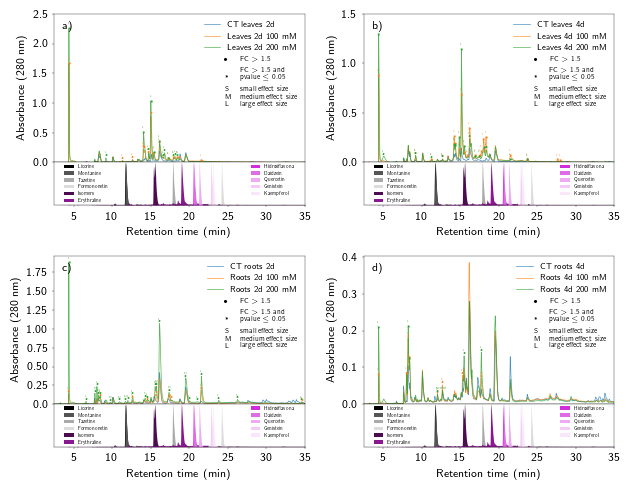

In [104]:
plots_em_x = 2
plots_em_y = 2
h_size     = 3.2 #tamanho horizontal do painel em polegadas
v_size     = 2.5 #tamanho vertical do painel em polegadas #h_size/1.618  #2.5
dpi = 700
tempo         = snp_ori_normalizado_media['Time']

fig = plt.figure(figsize=(h_size * plots_em_x, v_size * plots_em_y))

lista_cores   = ['C0', 'C1','C2']
alpha = 0.8
lw=0.5
xlim_max     = 35
xlim_min     = 2.5
xticks       = [5, 10, 15, 20, 25, 30, 35]  #se lista vazia, python escolhe os numeros
xticks_label = ['5','10','15','20','25','30','35'] #se lista vazia, python escolhe os numeros
ylabel       = r'Absorbance (280 nm)'
xlabel       = r'Retention time (min)'
fontsize_legenda   = 6
fontsize_label     = 8 # tamanho das legendas e dos números do eixo
fontsize_letra     = 8 # tamanho da letra do painel
fontsize_circulo   = 3
fontsize_asterisco = 5
fontsize_t_efeito  = 2



yticks       = [0.0,0.5,1.0,1.5,2.0,2.5] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0','0.5','1.0','1.5','2.0','2.5']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 100 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'a)'
lista_nomes = ['FC682','FSNP1002','FSNP2002']
lista_plots   = [snp_ori_normalizado_media['FC682'],
                 snp_ori_normalizado_media['FSNP1002'],
                 snp_ori_normalizado_media['FSNP2002'],
                 
                ]
lista_label   = ['CT leaves 2d','Leaves 2d 100 mM','Leaves 2d 200 mM'
                 
                 ]


alpha_bottom = 1

cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']   


A = 0 #mudar o painel
B = 0 #mudar o painel

outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)
inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A, B],
            height_ratios=[3.5, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])

position = [
0.68, 0.6,
0.74, 0.64,
0.74, 0.59,
0.68, 0.51,
0.68, 0.46,
0.68, 0.41,
0.74, 0.51,
0.74, 0.46,
0.74, 0.41,
0.675, 0.71]
df_func=df_snp
#mudar o df!!!
df_painel_a = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom)



###########################################################


yticks       = [0.0,0.5,1.0,1.5] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0','0.5','1.0','1.5']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 100 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'b)'
lista_nomes = ['FC684','FSNP1004','FSNP2004']
lista_plots   = [snp_ori_normalizado_media['FC684'],
                 snp_ori_normalizado_media['FSNP1004'],                 
                 snp_ori_normalizado_media['FSNP2004'],
]
lista_label   = [ 'CT leaves 4d','Leaves 4d 100 mM','Leaves 4d 200 mM'        
                 ]

cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']  

A = 0 #mudar o painel
B = 1 #mudar o painel

outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)
inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A, B], 
            height_ratios=[3.5, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])

position = [
0.68, 0.6,
0.74, 0.64,
0.74, 0.59,
0.68, 0.51,
0.68, 0.46,
0.68, 0.41,
0.74, 0.51,
0.74, 0.46,
0.74, 0.41,
0.675, 0.71]
df_func=df_snp
#mudar o df!!!
df_painel_b = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom)





###########################################################


yticks       = [0.0,0.25,0.50, 0.75, 1.00, 1.25,1.50, 1.75] 
yticks_label = ['0.0','0.25','0.50', '0.75', '1.00', '1.25','1.50', '1.75']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 100 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'c)'
lista_nomes = ['RC682','RSNP1002','RSNP2002']
lista_plots   = [snp_ori_normalizado_media['RC682'],
                 snp_ori_normalizado_media['RSNP1002'],
                 snp_ori_normalizado_media['RSNP2002'],
]
lista_label   = ['CT roots 2d','Roots 2d 100 mM','Roots 2d 200 mM'          
                 ]

cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']  

A = 1 #mudar o painel
B = 0 #mudar o painel

outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)
inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A, B],  
            height_ratios=[3.5, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])

position = [
0.68, 0.6,
0.74, 0.64,
0.74, 0.59,
0.68, 0.51,
0.68, 0.46,
0.68, 0.41,
0.74, 0.51,
0.74, 0.46,
0.74, 0.41,
0.675, 0.71]
df_func=df_snp
#mudar o df!!!
df_painel_c = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom)




###########################################################


yticks       = [0.0,0.1,0.2,0.3,0.4] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0','0.1','0.2','0.3','0.4']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 100 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'd)'
lista_nomes = ['RC684','RSNP1004','RSNP2004']
lista_plots   = [snp_ori_normalizado_media['RC684'],
                 snp_ori_normalizado_media['RSNP1004'],
                 snp_ori_normalizado_media['RSNP2004']
]
lista_label   = ['CT roots 4d','Roots 4d 100 mM','Roots 4d 200 mM'        
                 ]

cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']  

A = 1 #mudar o painel
B = 1 #mudar o painel

outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)
inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A, B],  
            height_ratios=[3.5, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])

position = [
0.68, 0.6,
0.74, 0.64,
0.74, 0.59,
0.68, 0.51,
0.68, 0.46,
0.68, 0.41,
0.74, 0.51,
0.74, 0.46,
0.74, 0.41,
0.675, 0.71]
df_func=df_snp
#mudar o df!!!
df_painel_d = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom)


df_concatenado_snp = pd.concat([df_painel_a, df_painel_b, df_painel_c, df_painel_d], axis=0)
df_concatenado_snp

# plt.savefig('/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/graficos_suplementar/snp.pdf', bbox_inches='tight', pad_inches=0.1, transparent=True, dpi=dpi)
# plt.savefig('/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/graficos_suplementar/snp.tiff', bbox_inches='tight', pad_inches=0.1, transparent=True, dpi=dpi)

plt.savefig('/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/graficos_suplementar/snp.png', bbox_inches='tight', pad_inches=0.1, transparent=False, dpi=dpi)

# df_concatenado_nacl

# ABA

In [21]:
caminho_arquivo = r'/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/Final_figures/new/Figures/all_treatmens_final_normalizado2.xlsx'
df_aba = pd.read_excel(caminho_arquivo,sheet_name='aba')
df_aba

# df_aba = df_aba.drop(columns=["RC2441"])
# df_aba = df_aba.drop(columns=["RC2443"])
# df_aba.columns

# # Aplica a função a todas as colunas do DataFrame
# df_aba.columns = [renomear_colunas(col) for col in df_aba.columns]

# # Exibir as colunas renomeadas
# df_aba.columns

,Time,FC242-1,FC242-2,FC242-3,FC242-4,FC242-5,FC244-1,FC244-2,FC244-3,FC244-4,...,RABA254-1,RABA254-2,RABA254-3,RABA254-4,RABA254-5,RABA504-1,RABA504-2,RABA504-3,RABA504-4,RABA504-5
0,2.501628,0.000034,0.000034,0.000039,0.000049,0.000036,0.000066,0.000015,0.000054,0.000041,...,6.065740e-06,0.000036,0.000032,0.000044,0.000038,0.000043,0.000052,0.000051,0.000052,0.000050
1,2.503294,0.000035,0.000035,0.000038,0.000051,0.000035,0.000067,0.000016,0.000051,0.000041,...,3.100267e-06,0.000035,0.000031,0.000045,0.000037,0.000042,0.000051,0.000052,0.000054,0.000054
2,2.504961,0.000037,0.000035,0.000036,0.000053,0.000037,0.000068,0.000016,0.000048,0.000042,...,6.065740e-07,0.000035,0.000032,0.000045,0.000038,0.000040,0.000051,0.000050,0.000055,0.000055
3,2.506628,0.000039,0.000035,0.000034,0.000053,0.000039,0.000069,0.000017,0.000048,0.000044,...,-1.280545e-06,0.000036,0.000035,0.000043,0.000038,0.000037,0.000052,0.000048,0.000057,0.000055
4,2.508294,0.000042,0.000032,0.000034,0.000051,0.000041,0.000070,0.000017,0.000045,0.000043,...,-9.435596e-07,0.000038,0.000035,0.000039,0.000038,0.000034,0.000055,0.000048,0.000058,0.000055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28490,49.993530,0.002079,0.002169,0.002202,0.002117,0.002260,0.002915,0.001634,0.002727,0.002406,...,2.224172e-03,0.002119,0.002078,0.002514,0.002296,0.002127,0.002162,0.002391,0.002105,0.002152
28491,49.995200,0.002080,0.002167,0.002200,0.002119,0.002259,0.002915,0.001636,0.002726,0.002406,...,2.225453e-03,0.002118,0.002080,0.002515,0.002295,0.002126,0.002163,0.002391,0.002103,0.002150
28492,49.996860,0.002081,0.002166,0.002200,0.002121,0.002259,0.002913,0.001638,0.002726,0.002407,...,2.228957e-03,0.002117,0.002080,0.002516,0.002295,0.002125,0.002164,0.002388,0.002103,0.002148
28493,49.998530,0.002079,0.002167,0.002201,0.002123,0.002257,0.002910,0.001639,0.002725,0.002408,...,2.231316e-03,0.002114,0.002079,0.002517,0.002295,0.002126,0.002165,0.002384,0.002101,0.002146


In [22]:
# inicio=16
# fim=19
# for i in range(inicio,fim): #numero das amostras
#     plt.plot(df_aba['Time'][4320:4738],df_aba[df_aba.columns[i]][4320:4738], lw=0.4) 
#     print(df_aba.columns[i],i-inicio)

############# NORMALIZAÇÃO ###################
# aba_ori_normalizado = normalizacao_quimica(df_aba, 4320, 4738, 0.0942)
# ############# CRIAR DATA FRAME ###################
# caminho=r'E:\Doc\Cap 2 - Tratadas_HPLC_Evelu\Analise_HPLC\RESULTADOS_PROCESSADOS\Manuscrito\Plant_Biology\Re-submission\Final_figures\new'
# nome_arquivo=r'\aba_ori_normalizado.xlsx'
# arquivo=caminho+nome_arquivo

# aba_ori_normalizado.to_excel(arquivo, index=False)
aba_ori_normalizado = df_aba

aba_ori_normalizado_media = media_repbiologicas(aba_ori_normalizado)
aba_ori_normalizado_media

['Time', 'FC242', 'FC244', 'FABA252', 'FABA502', 'FABA254', 'FABA504', 'RC242', 'RC244', 'RABA252', 'RABA502', 'RABA254', 'RABA504']
[1. 5. 5. 5. 5. 5. 5. 5. 3. 5. 3. 5. 5.]


,Time,FC242,FC244,FABA252,FABA502,FABA254,FABA504,RC242,RC244,RABA252,RABA502,RABA254,RABA504
0,2.501628,0.000038,0.000042,0.000057,0.000044,0.000036,0.000036,0.000055,0.000150,0.000050,0.000062,0.000031,0.000050
1,2.503294,0.000039,0.000043,0.000058,0.000045,0.000037,0.000036,0.000055,0.000142,0.000051,0.000063,0.000030,0.000050
2,2.504961,0.000039,0.000043,0.000060,0.000044,0.000037,0.000036,0.000055,0.000138,0.000052,0.000064,0.000030,0.000050
3,2.506628,0.000040,0.000044,0.000061,0.000045,0.000037,0.000036,0.000055,0.000134,0.000053,0.000066,0.000030,0.000050
4,2.508294,0.000040,0.000043,0.000061,0.000045,0.000038,0.000037,0.000055,0.000134,0.000054,0.000067,0.000030,0.000050
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28490,49.993530,0.002166,0.002462,0.001820,0.002192,0.002454,0.002511,0.001955,0.013813,0.001841,0.002340,0.002246,0.002187
28491,49.995200,0.002165,0.002463,0.001820,0.002190,0.002454,0.002512,0.001953,0.013816,0.001841,0.002338,0.002247,0.002187
28492,49.996860,0.002165,0.002464,0.001820,0.002189,0.002454,0.002511,0.001952,0.013820,0.001840,0.002338,0.002247,0.002185
28493,49.998530,0.002165,0.002463,0.001819,0.002187,0.002453,0.002510,0.001951,0.013832,0.001840,0.002337,0.002247,0.002184


/tmp/ipykernel_46820/173820660.py:339: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pontos = pd.concat([df_pontos, pd.DataFrame([nova_linha])], ignore_index=True)
/tmp/ipykernel_46820/173820660.py:339: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pontos = pd.concat([df_pontos, pd.DataFrame([nova_linha])], ignore_index=True)
/tmp/ipykernel_46820/173820660.py:377: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this wi

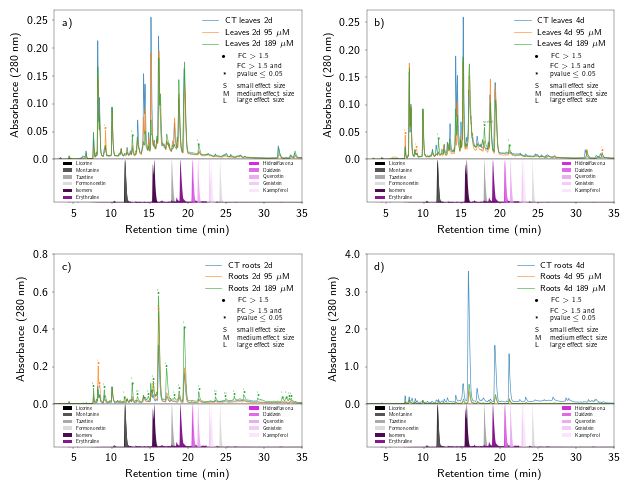

In [105]:
plots_em_x = 2
plots_em_y = 2
h_size     = 3.2 #tamanho horizontal do painel em polegadas
v_size     = 2.5 #tamanho vertical do painel em polegadas #h_size/1.618  #2.5
dpi = 700
tempo         = aba_ori_normalizado_media['Time']

fig = plt.figure(figsize=(h_size * plots_em_x, v_size * plots_em_y))

lista_cores   = ['C0', 'C1','C2']
alpha = 0.8
lw=0.5
xlim_max     = 35
xlim_min     = 2.5
xticks       = [5, 10, 15, 20, 25, 30, 35]  #se lista vazia, python escolhe os numeros
xticks_label = ['5','10','15','20','25','30','35'] #se lista vazia, python escolhe os numeros
ylabel       = r'Absorbance (280 nm)'
xlabel       = r'Retention time (min)'
fontsize_legenda   = 6
fontsize_label     = 8 # tamanho das legendas e dos números do eixo
fontsize_letra     = 8 # tamanho da letra do painel
fontsize_circulo   = 3
fontsize_asterisco = 5
fontsize_t_efeito  = 2



yticks       = [0.0,0.05,0.10,0.15,0.20,0.25] 
yticks_label = ['0.0','0.05','0.10','0.15','0.20','0.25']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 100 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'a)'
lista_nomes = ['FC242','FABA252','FABA502']
lista_plots   = [aba_ori_normalizado_media['FC242'],
                 aba_ori_normalizado_media['FABA252'],
                 aba_ori_normalizado_media['FABA502']
                ]
lista_label   = ['CT leaves 2d','Leaves 2d 95 $\\mu$M','Leaves 2d 189 $\\mu$M'
                 
                 ]


alpha_bottom = 1

cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']   


A = 0 #mudar o painel
B = 0 #mudar o painel

outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)
inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A, B],
            height_ratios=[3.5, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])

position = [
0.68, 0.6,
0.74, 0.64,
0.74, 0.59,
0.68, 0.51,
0.68, 0.46,
0.68, 0.41,
0.74, 0.51,
0.74, 0.46,
0.74, 0.41,
0.675, 0.71]
df_func=df_aba
#mudar o df!!!
df_painel_a = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom)



###########################################################


yticks       = [0.0,0.05,0.10,0.15,0.20,0.25] 
yticks_label = ['0.0','0.05','0.10','0.15','0.20','0.25']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 100 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'b)'
lista_nomes = ['FC244','FABA254','FABA504']
lista_plots   = [aba_ori_normalizado_media['FC244'],
                 aba_ori_normalizado_media['FABA254'],                 
                 aba_ori_normalizado_media['FABA504']
]
lista_label   = [ 'CT leaves 4d','Leaves 4d 95 $\\mu$M','Leaves 4d 189 $\\mu$M'        
                 ]

cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']  

A = 0 #mudar o painel
B = 1 #mudar o painel

outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)
inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A, B], 
            height_ratios=[3.5, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])

position = [
0.68, 0.6,
0.74, 0.64,
0.74, 0.59,
0.68, 0.51,
0.68, 0.46,
0.68, 0.41,
0.74, 0.51,
0.74, 0.46,
0.74, 0.41,
0.675, 0.71]
df_func=df_aba
#mudar o df!!!
df_painel_b = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom)





###########################################################


yticks       = [0.0,0.2,0.4,0.6,0.8] 
yticks_label = ['0.0','0.2','0.4','0.6','0.8']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 100 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'c)'
lista_nomes = ['RC242','RABA252','RABA502']
lista_plots   = [aba_ori_normalizado_media['RC242'],
                 aba_ori_normalizado_media['RABA252'],
                 aba_ori_normalizado_media['RABA502']
]
lista_label   = ['CT roots 2d','Roots 2d 95 $\\mu$M','Roots 2d 189 $\\mu$M'        
                 ]

cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']  

A = 1 #mudar o painel
B = 0 #mudar o painel

outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)
inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A, B],  
            height_ratios=[3.5, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])

position = [
0.68, 0.6,
0.74, 0.64,
0.74, 0.59,
0.68, 0.51,
0.68, 0.46,
0.68, 0.41,
0.74, 0.51,
0.74, 0.46,
0.74, 0.41,
0.675, 0.71]
df_func=df_aba
#mudar o df!!!
df_painel_c = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom)




###########################################################


yticks       = [0.0,1.0,2.0,3.0,4.0] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0','1.0','2.0','3.0','4.0']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 100 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'd)'
lista_nomes = ['RC244','RABA254','RABA504']
lista_plots   = [aba_ori_normalizado_media['RC244'],
                 aba_ori_normalizado_media['RABA254'],
                 aba_ori_normalizado_media['RABA504']
]
lista_label   = ['CT roots 4d','Roots 4d 95 $\\mu$M','Roots 4d 189 $\\mu$M'       
                 ]

cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']  

A = 1 #mudar o painel
B = 1 #mudar o painel

outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)
inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A, B],  
            height_ratios=[3.5, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])

position = [
0.68, 0.6,
0.74, 0.64,
0.74, 0.59,
0.68, 0.51,
0.68, 0.46,
0.68, 0.41,
0.74, 0.51,
0.74, 0.46,
0.74, 0.41,
0.675, 0.71]
df_func=df_aba
#mudar o df!!!
df_painel_d = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom)


df_concatenado_aba = pd.concat([df_painel_a, df_painel_b, df_painel_c, df_painel_d], axis=0)
df_concatenado_aba

# plt.savefig('/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/graficos_suplementar/aba.pdf', bbox_inches='tight', pad_inches=0.1, transparent=True, dpi=dpi)
# plt.savefig('/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/graficos_suplementar/aba.tiff', bbox_inches='tight', pad_inches=0.1, transparent=True, dpi=dpi)

plt.savefig('/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/graficos_suplementar/aba.png', bbox_inches='tight', pad_inches=0.1, transparent=False, dpi=dpi)

# df_concatenado_nacl

In [ ]:
base = "/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/graficos_suplementar"

fname = f"{base}/Statistic_treatments.xlsx"

with pd.ExcelWriter(fname) as writer: 
    df_concatenado_temp.to_excel(writer, sheet_name="Temp", index=False)
    df_concatenado_uv.to_excel(writer, sheet_name="UV", index=False)
    df_concatenado_hidrico_folhas.to_excel(writer, sheet_name="Water_stress_leaves", index=False)
    df_concatenado_hidrico_raizes.to_excel(writer, sheet_name="Water_stress_roots", index=False)
    df_concatenado_nacl.to_excel(writer, sheet_name="NaCl", index=False)
    df_concatenado_dm.to_excel(writer, sheet_name="Mechanical_damage", index=False)
    df_concatenado_meja.to_excel(writer, sheet_name="MeJA", index=False)
    df_concatenado_as.to_excel(writer, sheet_name="Salicylic acid", index=False)
    df_concatenado_snp.to_excel(writer, sheet_name="SNP", index=False)
    df_concatenado_aba.to_excel(writer, sheet_name="ABA", index=False)
    

# FUNÇÃO PARA FIGURAS PRINCIPAIS

<!-- #[A-Za-z]: Os colchetes indicam uma classe de caracteres. A-Z captura letras maiúsculas, a-z captura letras minúsculas.
#+: O sinal de mais significa "um ou mais" dos caracteres que estão especificados antes dele. Portanto, [A-Za-z]+ corresponde
     #a uma sequência de uma ou mais letras, como FT, RT, FTT, etc.
#\d: O \d é um atalho para representar qualquer dígito de 0 a 9
    #\d+ corresponde a uma sequência de um ou mais dígitos, como 24, 50, etc.
    
    

# # Calcular a média da soma para cada grupo
# media_por_grupo = somas_df.groupby('Grupo')['Soma'].mean() -->

In [23]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:



###################################################################################################

def function_fig_chromatogram_v2(plots_em_x, plots_em_y, h_size, v_size, 
                              tempo, lista_plots, lista_label, cores, linhas_por_painel,
                              alpha, lw, xlim_max, xlim_min, xticks, xticks_label, yticks, yticks_label,
                              ylabel, xlabel, dpi,
                              variacao_pontos, tempo_controle_asterisco, fontsize_asterisco,prominence,
                              loc, fontsize_legenda, fontsize_label, fontsize_letra, letra_painel,flag2,save_fig,formats):
    
    fig, axs = plt.subplots(plots_em_y,plots_em_x, figsize=(h_size*plots_em_x, v_size*plots_em_y),layout='constrained')
    
    if plots_em_x == 1 or plots_em_y == 1: #se tiver uma coluna ou linha
        numero_plot        = max(plots_em_x,plots_em_y)
        contador           = 0 
        contador_asterisco = 0
        
        for i in range (numero_plot):
            lista_media_painel = []
            contador_asterisco += 1
            for j in range(linhas_por_painel[i]):
                axs[i].plot(tempo, lista_plots[contador], label=lista_label[contador], 
                            lw=lw, alpha=alpha,c=cores[contador])
                contador+=1
                
            for l in range(1,linhas_por_painel[i] ):
                media_ct_tr = np.average([np.average(lista_plots[(contador_asterisco-1)*linhas_por_painel[i]]),
                                        np.average(lista_plots[(contador_asterisco-1)*linhas_por_painel[i] + l])])
                
                peaks, _    = find_peaks(lista_plots[(contador_asterisco-1)*linhas_por_painel[i] + l], prominence=prominence)  
#                 axs[i].scatter(tempo[peaks],lista_plots[(contador_asterisco-1)*linhas_por_painel[i] + l][peaks],s=2)
                sel = lista_plots[(contador_asterisco-1)*linhas_por_painel[i] + l][peaks] > media_ct_tr #selecionar os picos acima da média 
                for p in range (len(peaks[sel])):
                    maior_valor_controle = max(lista_plots[(contador_asterisco-1)*linhas_por_painel[i]][peaks[sel][p]-variacao_pontos:peaks[sel][p]+variacao_pontos]) #75 
                    razao = (lista_plots[(contador_asterisco-1)*linhas_por_painel[i] + l][peaks[sel][p]]) / (maior_valor_controle) #Fold Change
                    if razao >= 1.5 and tempo[peaks[sel][p]] < xlim_max: #limiar do fold - colcor o *
                        axs[i].text(tempo[peaks[sel][p]-tempo_controle_asterisco],
                                        1.01*lista_plots[(contador_asterisco-1)*linhas_por_painel[i] + l][peaks[sel][p]],
                                        '*',c=cores[l],fontsize=fontsize_asterisco) 
                    
            axs[i].set_ylabel(ylabel, fontsize = fontsize_label)
            axs[i].set_xlabel(xlabel, fontsize = fontsize_label)
            if len(xticks) > 0:
                axs[i].set_xticks(xticks, xticks_label, fontsize = fontsize_label)
            else:
                axs[i].tick_params(axis='x', labelsize=fontsize_label)
                
            if len(yticks[i]) > 0:
                axs[i].set_yticks(yticks[i], yticks_label[i], fontsize = fontsize_label)
            else:
                axs[i].tick_params(axis='y', labelsize=fontsize_label)
            axs[i].set_xlim(xlim_min, xlim_max)
            axs[i].legend(fontsize = fontsize_legenda, loc = "upper right", fancybox=False, frameon=False)
            axs[i].annotate(letra_painel[i], xy=(0.03, 0.95), xycoords='axes fraction', 
                            fontsize=fontsize_letra, horizontalalignment='left', verticalalignment='top')
            
    else:#se n tiver uma coluna ou linha
        contador_plot      = 0
        contador_letra     = 0
        contador_asterisco = 0
        for j in range (plots_em_y):
            for i in range (plots_em_x):
                contador_asterisco += 1
                if j == 3 and i == 0:
                    ax1 = axs[j,i].inset_axes([0.677, 0.17, 0.3, 0.53]) 
                if j == 4 and i == 0:
                    ax2 = axs[j,i].inset_axes([0.677, 0.17, 0.3, 0.53])
                for k in range(linhas_por_painel[contador_letra]):
                    axs[j,i].plot(tempo, lista_plots[contador_plot], label=lista_label[contador_plot],
                                  c=cores[contador_plot], lw=lw, alpha=alpha)
                    if j == 3 and i == 0:
                        ax1.plot(tempo, lista_plots[contador_plot], label=lista_label[contador_plot],
                                  c=cores[contador_plot], lw=lw, alpha=alpha)
                        ax1.set_xlim(10,22)
                        ax1.set_ylim(0.0,0.22) 
                        ax1.tick_params(axis='x', labelsize=6)
                        ax1.tick_params(axis='y', labelsize=6)
                        ax1.set_xticks([10, 15, 20]) 
                        ax1.set_xticklabels([10, 15, 20])
                        ax1.set_yticks([0.0, 0.1, 0.2])
                        ax1.set_yticklabels([0.0, 0.1, 0.2])
                    if j == 4 and i == 0:
                        ax2.plot(tempo, lista_plots[contador_plot], label=lista_label[contador_plot],
                                  c=cores[contador_plot], lw=lw, alpha=alpha)
                        ax2.set_xlim(10,22)
                        ax2.set_ylim(0.0,0.25) 
                        ax2.tick_params(axis='x', labelsize=6)
                        ax2.tick_params(axis='y', labelsize=6)
                        ax2.set_xticks([10, 15, 20]) 
                        ax2.set_xticklabels([10, 15, 20])
                        ax2.set_yticks([0.0, 0.1, 0.2])
                        ax2.set_yticklabels([0.0, 0.1, 0.2])
                    contador_plot += 1
                if i ==1 and flag2==True:
                    for l in range(1,linhas_por_painel[contador_letra]):
                        print(contador_plot - linhas_por_painel[contador_letra],cores[contador_plot-linhas_por_painel[contador_letra]],
                             contador_plot - linhas_por_painel[contador_letra]+l,cores[contador_plot-linhas_por_painel[contador_letra]+l])
                        media_ct_tr = np.average([np.average(lista_plots[contador_plot - linhas_por_painel[contador_letra]]),
                                                np.average(lista_plots[contador_plot - linhas_por_painel[contador_letra]+l])])              

                        peaks, _    = find_peaks(lista_plots[contador_plot - linhas_por_painel[contador_letra]+l], prominence=prominence)  
#                         axs[j,i].scatter(tempo[peaks],lista_plots[contador_plot - linhas_por_painel[contador_letra]+l][peaks],s=2)
                        sel         = lista_plots[contador_plot - linhas_por_painel[contador_letra]+l][peaks] > media_ct_tr #selecionar os picos acima da média 
                        for p in range (len(peaks[sel])):
                            maior_valor_controle = max(lista_plots[contador_plot - linhas_por_painel[contador_letra]][peaks[sel][p]-variacao_pontos:peaks[sel][p]+variacao_pontos]) #75 
                            razao = (lista_plots[contador_plot - linhas_por_painel[contador_letra]+l][peaks[sel][p]]) / (maior_valor_controle) #Fold Change
                            if razao >= 1.5 and tempo[peaks[sel][p]] < xlim_max: #limiar do fold - colcor o *
                                axs[j,i].text(tempo[peaks[sel][p]-tempo_controle_asterisco],
                                                1.01*lista_plots[contador_plot - linhas_por_painel[contador_letra]+l][peaks[sel][p]],
                                                '*',c=cores[contador_plot - linhas_por_painel[contador_letra]+l], fontsize=fontsize_asterisco) 
                            
                axs[j,i].set_ylabel(ylabel[contador_letra], fontsize = fontsize_label)
                axs[j,i].set_xlabel(xlabel, fontsize = fontsize_label)
                if len(xticks) > 0:
                    axs[j,i].set_xticks(xticks, xticks_label, fontsize = fontsize_label)
                else:
                    axs[j,i].tick_params(axis='x', labelsize=fontsize_label)
                if len(yticks[contador_letra]) > 0:
                    axs[j,i].set_yticks(yticks[contador_letra], yticks_label[contador_letra], fontsize = fontsize_label)
                else:
                    axs[j,i].tick_params(axis='y', labelsize=fontsize_label)
                axs[j,i].set_xlim(xlim_min, xlim_max)
                axs[j,i].legend(fontsize=fontsize_legenda, loc = loc[contador_letra], fancybox=False,frameon=False)
                axs[j,i].annotate(letra_painel[contador_letra], xy=(0.03, 0.95),xycoords='axes fraction',
                                  fontsize=fontsize_letra, horizontalalignment='left', verticalalignment='top')
                contador_letra+=1    
                
    for i in range(len(formats)):
        plt.savefig(save_fig+formats[i], bbox_inches='tight', pad_inches=0.1, transparent=True, dpi=dpi)     
#     plt.close()
    return None


###################################################################################################
###################################################################################################
################# FUNÇÃO SEM COLOCAR UM CROMATOGRAMA DENTRO DE OUTRO CROMATOGRAMA #################
###################################################################################################
###################################################################################################
###################################################################################################

# def function_fig_chromatogram(plots_em_x, plots_em_y, h_size, v_size, 
#                               tempo, lista_plots, lista_label, cores, linhas_por_painel,
#                               alpha, lw, xlim_max, xlim_min, xticks, xticks_label, yticks, yticks_label,
#                               ylabel, xlabel, dpi,
#                               variacao_pontos, tempo_controle_asterisco, fontsize_asterisco,prominence,
#                               loc, fontsize_legenda, fontsize_label, fontsize_letra, letra_painel,flag2,save_fig,formats):
    
#     fig, axs = plt.subplots(plots_em_y,plots_em_x, figsize=(h_size*plots_em_x, v_size*plots_em_y),layout='constrained')
    
#     if plots_em_x == 1 or plots_em_y == 1: #se tiver uma coluna ou linha
#         numero_plot        = max(plots_em_x,plots_em_y)
#         contador           = 0 
#         contador_asterisco = 0
        
#         for i in range (numero_plot):
#             lista_media_painel = []
#             contador_asterisco += 1
#             for j in range(linhas_por_painel[i]):
#                 axs[i].plot(tempo, lista_plots[contador], label=lista_label[contador], 
#                             lw=lw, alpha=alpha,c=cores[contador])
#                 contador+=1
                
#             for l in range(1,linhas_por_painel[i] ):
#                 media_ct_tr = np.average([np.average(lista_plots[(contador_asterisco-1)*linhas_por_painel[i]]),
#                                         np.average(lista_plots[(contador_asterisco-1)*linhas_por_painel[i] + l])])
                
#                 peaks, _    = find_peaks(lista_plots[(contador_asterisco-1)*linhas_por_painel[i] + l], prominence=prominence)  
# #                 axs[i].scatter(tempo[peaks],lista_plots[(contador_asterisco-1)*linhas_por_painel[i] + l][peaks],s=2)
#                 sel = lista_plots[(contador_asterisco-1)*linhas_por_painel[i] + l][peaks] > media_ct_tr #selecionar os picos acima da média 
#                 for p in range (len(peaks[sel])):
#                     maior_valor_controle = max(lista_plots[(contador_asterisco-1)*linhas_por_painel[i]][peaks[sel][p]-variacao_pontos:peaks[sel][p]+variacao_pontos]) #75 
#                     razao = (lista_plots[(contador_asterisco-1)*linhas_por_painel[i] + l][peaks[sel][p]]) / (maior_valor_controle) #Fold Change
#                     if razao >= 1.5 and tempo[peaks[sel][p]] < xlim_max: #limiar do fold - colcor o *
#                         axs[i].text(tempo[peaks[sel][p]-tempo_controle_asterisco],
#                                         1.01*lista_plots[(contador_asterisco-1)*linhas_por_painel[i] + l][peaks[sel][p]],
#                                         '*',c=cores[l],fontsize=fontsize_asterisco) 
                    
#             axs[i].set_ylabel(ylabel, fontsize = fontsize_label)
#             axs[i].set_xlabel(xlabel, fontsize = fontsize_label)
#             if len(xticks) > 0:
#                 axs[i].set_xticks(xticks, xticks_label, fontsize = fontsize_label)
#             else:
#                 axs[i].tick_params(axis='x', labelsize=fontsize_label)
                
#             if len(yticks[i]) > 0:
#                 axs[i].set_yticks(yticks[i], yticks_label[i], fontsize = fontsize_label)
#             else:
#                 axs[i].tick_params(axis='y', labelsize=fontsize_label)
#             axs[i].set_xlim(xlim_min, xlim_max)
#             axs[i].legend(fontsize = fontsize_legenda, loc = "upper right", fancybox=False, frameon=False)
#             axs[i].annotate(letra_painel[i], xy=(0.03, 0.95), xycoords='axes fraction', 
#                             fontsize=fontsize_letra, horizontalalignment='left', verticalalignment='top')
            
#     else:#se n tiver uma coluna ou linha
#         contador_plot      = 0
#         contador_letra     = 0
#         contador_asterisco = 0
#         for j in range (plots_em_y):
#             for i in range (plots_em_x):
#                 contador_asterisco += 1
#                 for k in range(linhas_por_painel[contador_letra]):
#                     axs[j,i].plot(tempo, lista_plots[contador_plot], label=lista_label[contador_plot],
#                                   c=cores[contador_plot], lw=lw, alpha=alpha)
#                     contador_plot += 1
#                 if i ==1 and flag2==True:
#                     for l in range(1,linhas_por_painel[contador_letra]):
#                         print(contador_plot - linhas_por_painel[contador_letra],cores[contador_plot-linhas_por_painel[contador_letra]],
#                              contador_plot - linhas_por_painel[contador_letra]+l,cores[contador_plot-linhas_por_painel[contador_letra]+l])
#                         media_ct_tr = np.average([np.average(lista_plots[contador_plot - linhas_por_painel[contador_letra]]),
#                                                 np.average(lista_plots[contador_plot - linhas_por_painel[contador_letra]+l])])              

#                         peaks, _    = find_peaks(lista_plots[contador_plot - linhas_por_painel[contador_letra]+l], prominence=prominence)  
# #                         axs[j,i].scatter(tempo[peaks],lista_plots[contador_plot - linhas_por_painel[contador_letra]+l][peaks],s=2)
#                         sel         = lista_plots[contador_plot - linhas_por_painel[contador_letra]+l][peaks] > media_ct_tr #selecionar os picos acima da média 
#                         for p in range (len(peaks[sel])):
#                             maior_valor_controle = max(lista_plots[contador_plot - linhas_por_painel[contador_letra]][peaks[sel][p]-variacao_pontos:peaks[sel][p]+variacao_pontos]) #75 
#                             razao = (lista_plots[contador_plot - linhas_por_painel[contador_letra]+l][peaks[sel][p]]) / (maior_valor_controle) #Fold Change
#                             if razao >= 1.5 and tempo[peaks[sel][p]] < xlim_max: #limiar do fold - colcor o *
#                                 axs[j,i].text(tempo[peaks[sel][p]-tempo_controle_asterisco],
#                                                 1.01*lista_plots[contador_plot - linhas_por_painel[contador_letra]+l][peaks[sel][p]],
#                                                 '*',c=cores[contador_plot - linhas_por_painel[contador_letra]+l], fontsize=fontsize_asterisco) 
                            
#                 axs[j,i].set_ylabel(ylabel[contador_letra], fontsize = fontsize_label)
#                 axs[j,i].set_xlabel(xlabel, fontsize = fontsize_label)
#                 if len(xticks) > 0:
#                     axs[j,i].set_xticks(xticks, xticks_label, fontsize = fontsize_label)
#                 else:
#                     axs[j,i].tick_params(axis='x', labelsize=fontsize_label)
#                 if len(yticks[contador_letra]) > 0:
#                     axs[j,i].set_yticks(yticks[contador_letra], yticks_label[contador_letra], fontsize = fontsize_label)
#                 else:
#                     axs[j,i].tick_params(axis='y', labelsize=fontsize_label)
#                 axs[j,i].set_xlim(xlim_min, xlim_max)
#                 axs[j,i].legend(fontsize=fontsize_legenda, loc = loc[contador_letra], fancybox=False,frameon=False)
#                 axs[j,i].annotate(letra_painel[contador_letra], xy=(0.03, 0.95),xycoords='axes fraction',
#                                   fontsize=fontsize_letra, horizontalalignment='left', verticalalignment='top')
#                 contador_letra+=1    
                
#     for i in range(len(formats)):
#         plt.savefig(save_fig+formats[i], bbox_inches='tight', pad_inches=0.1, transparent=True, dpi=dpi)     
# #     plt.close()
#     return None

# SUPLEMENTAR

<>:7: SyntaxWarning: invalid escape sequence '\c'
<>:14: SyntaxWarning: invalid escape sequence '\c'
<>:7: SyntaxWarning: invalid escape sequence '\c'
<>:14: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_46820/3758361497.py:7: SyntaxWarning: invalid escape sequence '\c'
  label='Leaves 50$^\circ$C',lw=0.5, alpha=0.7)
/tmp/ipykernel_46820/3758361497.py:14: SyntaxWarning: invalid escape sequence '\c'
  label='Roots 50$^\circ$C',lw=0.5, alpha=0.7)


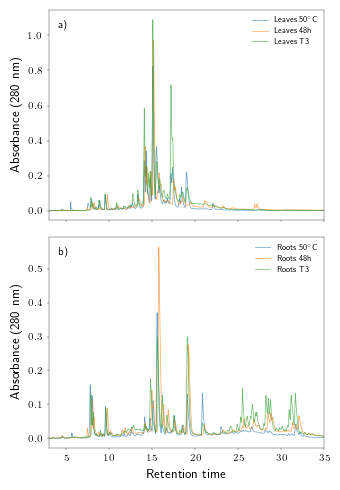

In [107]:
label_size=8
plots_em_x=1
plots_em_y=2
fig, axs= plt.subplots(plots_em_y,plots_em_x, figsize=(3.5*plots_em_x, 2.5*plots_em_y))

axs[0].plot(temp_ori_normalizado_media['Time'],temp_ori_normalizado_media['FT50'],
            label='Leaves 50$^\circ$C',lw=0.5, alpha=0.7)
axs[0].plot(uv_ori_normalizado_media['Time'],uv_ori_normalizado_media['FUV48'],
            label='Leaves 48h',lw=0.5, alpha=0.7)
axs[0].plot(hidrico_ori_normalizado_media['Time'],hidrico_ori_normalizado_media['FTH3'],
            label=r'Leaves T3',lw=0.5,alpha=0.7)

axs[1].plot(temp_ori_normalizado_media['Time'],temp_ori_normalizado_media['RT50'],
            label='Roots 50$^\circ$C',lw=0.5, alpha=0.7)
axs[1].plot(uv_ori_normalizado_media['Time'],uv_ori_normalizado_media['RUV48'],
            label='Roots 48h',lw=0.5,alpha=0.7)
axs[1].plot(hidrico_ori_normalizado_media['Time'],hidrico_ori_normalizado_media['RTH3'],
            label=r'Roots T3',lw=0.5,alpha=0.7)

axs[0].set_ylabel(r'Absorbance (280 nm)')
axs[1].set_ylabel(r'Absorbance (280 nm)')
axs[1].set_xlabel(r'Retention time')

axs[0].set_xlim(3,35)
axs[0].set_xticks([5,10,15,20,25,30,35])
axs[1].set_xlim(3,35)
axs[1].set_xticks([5,10,15,20,25,30,35])

# axs[0].set_yticks= ([0.0,0.4,0.8,1.2],['0.0','0.4','0.8','1.2'])
# axs[1].set_yticks= ([0.0,0.2,0.4,0.6],['0.0','0.2','0.4','0.6'])

axs[0].legend(fontsize=5.6, loc = "upper right",  
           fancybox=False,frameon=False)
axs[1].legend(fontsize=5.6, loc = "upper right",  
           fancybox=False,frameon=False)

axs[0].annotate('a)', xy=(0.03, 0.95),xycoords='axes fraction',fontsize=7.5,
                      horizontalalignment='left', verticalalignment='top')
axs[1].annotate('b)', xy=(0.03, 0.95),xycoords='axes fraction',fontsize=7.5,
                      horizontalalignment='left', verticalalignment='top')

axs[0].tick_params(labelbottom=False) #Tirar os numeros e deixar so risquinhos deles


plt.savefig(r'/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/graficos_suplementar/Fig_S21.png',bbox_inches='tight',pad_inches=0.1, transparent=False, dpi=700)


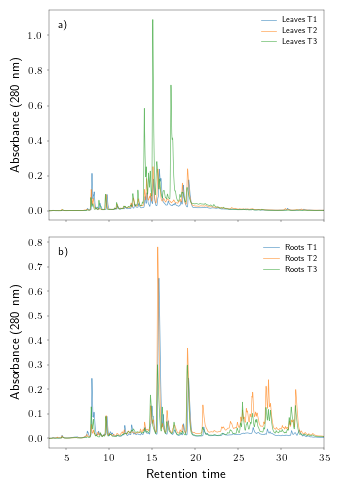

In [108]:
######ESTRESSE HDRICO T1, T2, T3

label_size=8
plots_em_x=1
plots_em_y=2
fig, axs= plt.subplots(plots_em_y,plots_em_x, figsize=(3.5*plots_em_x, 2.5*plots_em_y))

axs[0].plot(hidrico_ori_normalizado_media['Time'],hidrico_ori_normalizado_media['FTH1'],
            label=r'Leaves T1',lw=0.5,alpha=0.7)
axs[0].plot(hidrico_ori_normalizado_media['Time'],hidrico_ori_normalizado_media['FTH2'],
            label=r'Leaves T2',lw=0.5,alpha=0.7)
axs[0].plot(hidrico_ori_normalizado_media['Time'],hidrico_ori_normalizado_media['FTH3'],
            label=r'Leaves T3',lw=0.5,alpha=0.7)

axs[1].plot(hidrico_ori_normalizado_media['Time'],hidrico_ori_normalizado_media['RTH1'],
            label=r'Roots T1',lw=0.5,alpha=0.7)
axs[1].plot(hidrico_ori_normalizado_media['Time'],hidrico_ori_normalizado_media['RTH2'],
            label=r'Roots T2',lw=0.5,alpha=0.7)
axs[1].plot(hidrico_ori_normalizado_media['Time'],hidrico_ori_normalizado_media['RTH3'],
            label=r'Roots T3',lw=0.5,alpha=0.7)

axs[0].set_ylabel(r'Absorbance (280 nm)')
axs[1].set_ylabel(r'Absorbance (280 nm)')
axs[1].set_xlabel(r'Retention time')

axs[0].set_xlim(3,35)
axs[0].set_xticks([5,10,15,20,25,30,35])
axs[1].set_xlim(3,35)
axs[1].set_xticks([5,10,15,20,25,30,35])


axs[0].legend(fontsize=5.6, loc = "upper right",  
           fancybox=False,frameon=False)
axs[1].legend(fontsize=5.6, loc = "upper right",  
           fancybox=False,frameon=False)

axs[0].annotate('a)', xy=(0.03, 0.95),xycoords='axes fraction',fontsize=7.5,
                      horizontalalignment='left', verticalalignment='top')
axs[1].annotate('b)', xy=(0.03, 0.95),xycoords='axes fraction',fontsize=7.5,
                      horizontalalignment='left', verticalalignment='top')

axs[0].tick_params(labelbottom=False) #Tirar os numeros e deixar so risquinhos deles


plt.savefig(r'/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/graficos_suplementar/Fig_S22.png',bbox_inches='tight',pad_inches=0.1, transparent=False, dpi=700) 


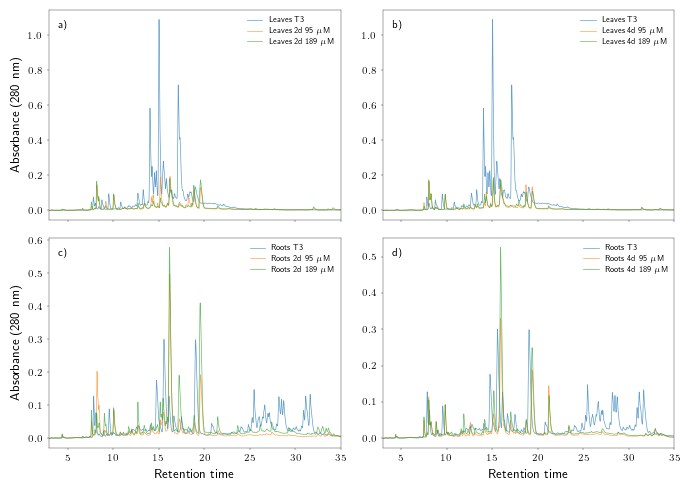

In [110]:
###### HIDRICO VS. ABA

label_size=8
plots_em_x=2
plots_em_y=2

fig, axs= plt.subplots(plots_em_y,plots_em_x, figsize=(3.5*plots_em_x, 2.5*plots_em_y))

axs[0,0].plot(hidrico_ori_normalizado_media['Time'],hidrico_ori_normalizado_media['FTH3'],
              label=r'Leaves T3',lw=0.5,alpha=0.7)
axs[0,0].plot(aba_ori_normalizado_media['Time'],aba_ori_normalizado_media['FABA252'],
              label=r'Leaves 2d 95 $\mu$M',lw=0.5,alpha=0.7)
axs[0,0].plot(aba_ori_normalizado_media['Time'],aba_ori_normalizado_media['FABA502'],
              label=r'Leaves 2d 189 $\mu$M',lw=0.5,alpha=0.7)

axs[0,1].plot(hidrico_ori_normalizado_media['Time'],hidrico_ori_normalizado_media['FTH3'],
              label=r'Leaves T3',lw=0.5,alpha=0.7)
axs[0,1].plot(aba_ori_normalizado_media['Time'],aba_ori_normalizado_media['FABA254'],
              label=r'Leaves 4d 95 $\mu$M',lw=0.5,alpha=0.7)
axs[0,1].plot(aba_ori_normalizado_media['Time'],aba_ori_normalizado_media['FABA504'],
              label=r'Leaves 4d 189 $\mu$M',lw=0.5,alpha=0.7)

axs[1,0].plot(hidrico_ori_normalizado_media['Time'],hidrico_ori_normalizado_media['RTH3'],
              label=r'Roots T3',lw=0.5,alpha=0.7)
axs[1,0].plot(aba_ori_normalizado_media['Time'],aba_ori_normalizado_media['RABA252'],
              label=r'Roots 2d 95 $\mu$M ',lw=0.5,alpha=0.7)
axs[1,0].plot(aba_ori_normalizado_media['Time'],aba_ori_normalizado_media['RABA502'],
              label=r'Roots 2d 189 $\mu$M',lw=0.5,alpha=0.7)

axs[1,1].plot(hidrico_ori_normalizado_media['Time'],hidrico_ori_normalizado_media['RTH3'],
              label=r'Roots T3',lw=0.5,alpha=0.7)
axs[1,1].plot(aba_ori_normalizado_media['Time'],aba_ori_normalizado_media['RABA254'],
              label=r'Roots 4d 95 $\mu$M ',lw=0.5,alpha=0.7)
axs[1,1].plot(aba_ori_normalizado_media['Time'],aba_ori_normalizado_media['RABA504'],
              label=r'Roots 4d 189 $\mu$M',lw=0.5,alpha=0.7)


####UNIR

axs[0,0].set_ylabel(r'Absorbance (280 nm)')
axs[1,0].set_ylabel(r'Absorbance (280 nm)')
axs[1,0].set_xlabel(r'Retention time')
axs[1,1].set_xlabel(r'Retention time')

axs[0,0].set_xlim(3,35)
axs[0,1].set_xlim(3,35)
axs[1,0].set_xlim(3,35)
axs[1,1].set_xlim(3,35)

axs[0,0].set_xticks([5,10,15,20,25,30,35])
axs[0,1].set_xticks([5,10,15,20,25,30,35])
axs[1,0].set_xticks([5,10,15,20,25,30,35])
axs[1,1].set_xticks([5,10,15,20,25,30,35])

axs[0,0].legend(fontsize=5.6, loc = "upper right",  
           fancybox=False,frameon=False)
axs[0,1].legend(fontsize=5.6, loc = "upper right",  
           fancybox=False,frameon=False)

axs[1,0].legend(fontsize=5.6, loc = "upper right",  
           fancybox=False,frameon=False)
axs[1,1].legend(fontsize=5.6, loc = "upper right",  
           fancybox=False,frameon=False)

axs[0,0].annotate('a)', xy=(0.03, 0.95),xycoords='axes fraction',fontsize=7.5,
                      horizontalalignment='left', verticalalignment='top')
axs[0,1].annotate('b)', xy=(0.03, 0.95),xycoords='axes fraction',fontsize=7.5,
                      horizontalalignment='left', verticalalignment='top')
axs[1,0].annotate('c)', xy=(0.03, 0.95),xycoords='axes fraction',fontsize=7.5,
                      horizontalalignment='left', verticalalignment='top')
axs[1,1].annotate('d)', xy=(0.03, 0.95),xycoords='axes fraction',fontsize=7.5,
                      horizontalalignment='left', verticalalignment='top')

axs[0,0].tick_params(labelbottom=False) #Tirar os numeros e deixar so risquinhos deles
axs[0,1].tick_params(labelbottom=False) #Tirar os numeros e deixar so risquinhos deles

plt.savefig(r'/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/graficos_suplementar/Fig_S23.png',bbox_inches='tight',pad_inches=0.1, transparent=False, dpi=700)


<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\%'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\%'
<>:20: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\%'
<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:27: SyntaxWarning: invalid escape sequence '\%'
<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\%'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\%'
<>:20: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\%'
<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:27: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_37046/1645274352.py:10: SyntaxWarning: invalid escape sequence '\m'
  label='Leaves 2d 40 $\mu$M',lw=0.5, alpha=0.7)
/tmp/ipykernel_37046/1645274352.py:12: SyntaxWarning

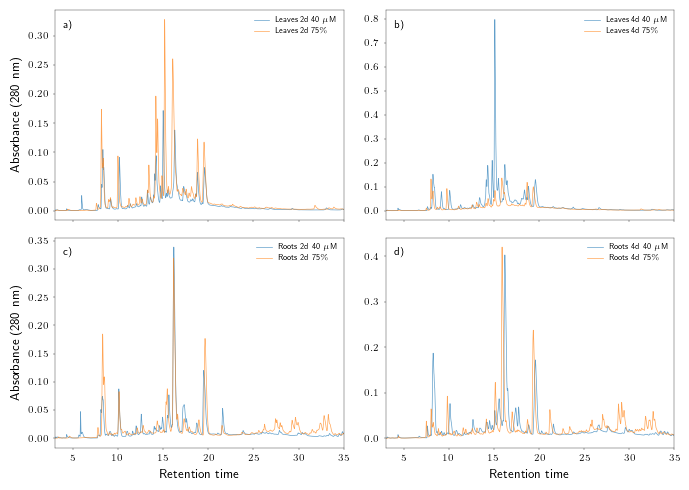

In [24]:
####MEJA e DM

####MEJA e DM
label_size=8
plots_em_x=2
plots_em_y=2
fig, axs= plt.subplots(plots_em_y,plots_em_x, figsize=(3.5*plots_em_x, 2.5*plots_em_y))

axs[0,0].plot(meja_ori_normalizado_media['Time'],meja_ori_normalizado_media['FMJ402'],
              label='Leaves 2d 40 $\mu$M',lw=0.5, alpha=0.7)
axs[0,0].plot(dm_ori_normalizado_media['Time'],dm_ori_normalizado_media['FDM32'],
              label='Leaves 2d 75$\%$',lw=0.5,alpha=0.7)

axs[0,1].plot(meja_ori_normalizado_media['Time'],meja_ori_normalizado_media['FMJ404'],
              label='Leaves 4d 40 $\mu$M',lw=0.5, alpha=0.7)
axs[0,1].plot(dm_ori_normalizado_media['Time'],dm_ori_normalizado_media['FDM34'],
              label='Leaves 4d 75$\%$',lw=0.5,alpha=0.7)

axs[1,0].plot(meja_ori_normalizado_media['Time'],meja_ori_normalizado_media['RMJ402'],
              label='Roots 2d 40 $\mu$M',lw=0.5, alpha=0.7)
axs[1,0].plot(dm_ori_normalizado_media['Time'],dm_ori_normalizado_media['RDM32'],
              label='Roots 2d 75$\%$',lw=0.5,alpha=0.7)

axs[1,1].plot(meja_ori_normalizado_media['Time'],meja_ori_normalizado_media['RMJ404'],
              label='Roots 4d 40 $\mu$M',lw=0.5, alpha=0.7)
axs[1,1].plot(dm_ori_normalizado_media['Time'],dm_ori_normalizado_media['RDM34'],
              label='Roots 4d 75$\%$',lw=0.5,alpha=0.7)

####UNIR

axs[0,0].set_ylabel(r'Absorbance (280 nm)')
axs[1,0].set_ylabel(r'Absorbance (280 nm)')
axs[1,0].set_xlabel(r'Retention time')
axs[1,1].set_xlabel(r'Retention time')


axs[0,0].set_xlim(3,35)
axs[0,1].set_xlim(3,35)
axs[1,0].set_xlim(3,35)
axs[1,1].set_xlim(3,35)


axs[0,0].set_xticks([5,10,15,20,25,30,35])
axs[0,1].set_xticks([5,10,15,20,25,30,35])
axs[1,0].set_xticks([5,10,15,20,25,30,35])
axs[1,1].set_xticks([5,10,15,20,25,30,35])


axs[0,0].legend(fontsize=5.6, loc = "upper right",  
           fancybox=False,frameon=False)
axs[0,1].legend(fontsize=5.6, loc = "upper right",  
           fancybox=False,frameon=False)
axs[1,0].legend(fontsize=5.6, loc = "upper right",  
           fancybox=False,frameon=False)
axs[1,1].legend(fontsize=5.6, loc = "upper right",  
           fancybox=False,frameon=False)

axs[0,0].annotate('a)', xy=(0.03, 0.95),xycoords='axes fraction',fontsize=7.5,
                      horizontalalignment='left', verticalalignment='top')
axs[0,1].annotate('b)', xy=(0.03, 0.95),xycoords='axes fraction',fontsize=7.5,
                      horizontalalignment='left', verticalalignment='top')
axs[1,0].annotate('c)', xy=(0.03, 0.95),xycoords='axes fraction',fontsize=7.5,
                      horizontalalignment='left', verticalalignment='top')
axs[1,1].annotate('d)', xy=(0.03, 0.95),xycoords='axes fraction',fontsize=7.5,
                      horizontalalignment='left', verticalalignment='top')


axs[0,0].tick_params(labelbottom=False) #Tirar os numeros e deixar so risquinhos deles
axs[0,1].tick_params(labelbottom=False) #Tirar os numeros e deixar so risquinhos deles

plt.savefig(r'/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/proof/Fig_S24.png',
            bbox_inches='tight',pad_inches=0.1, transparent=False, dpi=700)
              
              

<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_46820/1780158658.py:8: SyntaxWarning: invalid escape sequence '\m'
  label='Leaves 2d 40 $\mu$M',lw=0.5, alpha=0.7)
/tmp/ipykernel_46820/1780158658.py:13: SyntaxWarning: invalid escape sequence '\m'
  label='Leaves 4d 40 $\mu$M',lw=0.5, alpha=0.7)
/tmp/ipykernel_46820/1780158658.py:18: SyntaxWarning: invalid escape sequence '\m'
  label='Roots 2d 40 $\mu$M',lw=0.5, alpha=0.7)
/tmp/ipykernel_46820/1780158658.py:23: SyntaxWarning: invalid escape sequence '\m'
  label='Roots 4d 40 $\mu$M',lw=0.5, alpha=0.7)


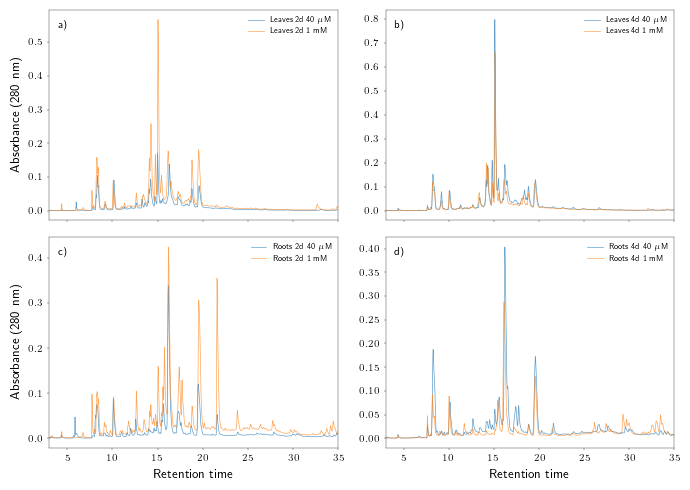

In [112]:
####MEJA e SA
label_size=8
plots_em_x=2
plots_em_y=2
fig, axs= plt.subplots(plots_em_y,plots_em_x, figsize=(3.5*plots_em_x, 2.5*plots_em_y))

axs[0,0].plot(meja_ori_normalizado_media['Time'],meja_ori_normalizado_media['FMJ402'],
              label='Leaves 2d 40 $\mu$M',lw=0.5, alpha=0.7)
axs[0,0].plot(as_ori_normalizado_media['Time'],as_ori_normalizado_media['FAS12'],
              label='Leaves 2d 1 mM',lw=0.5, alpha=0.7)

axs[0,1].plot(meja_ori_normalizado_media['Time'],meja_ori_normalizado_media['FMJ404'],
              label='Leaves 4d 40 $\mu$M',lw=0.5, alpha=0.7)
axs[0,1].plot(as_ori_normalizado_media['Time'],as_ori_normalizado_media['FAS14'],
              label='Leaves 4d 1 mM',lw=0.5, alpha=0.7)

axs[1,0].plot(meja_ori_normalizado_media['Time'],meja_ori_normalizado_media['RMJ402'],
              label='Roots 2d 40 $\mu$M',lw=0.5, alpha=0.7)
axs[1,0].plot(as_ori_normalizado_media['Time'],as_ori_normalizado_media['RAS12'],
              label='Roots 2d 1 mM',lw=0.5, alpha=0.7)

axs[1,1].plot(meja_ori_normalizado_media['Time'],meja_ori_normalizado_media['RMJ404'],
              label='Roots 4d 40 $\mu$M',lw=0.5, alpha=0.7)
axs[1,1].plot(as_ori_normalizado_media['Time'],as_ori_normalizado_media['RAS14'],
              label='Roots 4d 1 mM',lw=0.5, alpha=0.7)

#['Time', 'FC682', 'FAS12', 'FAS22', 'FC684', 'FAS14', 'FAS24', 'RC682', 'RAS12', 'RAS22', 'RC684', 'RAS14', 'RAS24']

axs[0,0].set_ylabel(r'Absorbance (280 nm)')
axs[1,0].set_ylabel(r'Absorbance (280 nm)')
axs[1,0].set_xlabel(r'Retention time')
axs[1,1].set_xlabel(r'Retention time')

axs[0,0].set_xlim(3,35)
axs[0,1].set_xlim(3,35)
axs[1,0].set_xlim(3,35)
axs[1,1].set_xlim(3,35)

axs[0,0].set_xticks([5,10,15,20,25,30,35])
axs[0,1].set_xticks([5,10,15,20,25,30,35])
axs[1,0].set_xticks([5,10,15,20,25,30,35])
axs[1,1].set_xticks([5,10,15,20,25,30,35])

axs[0,0].legend(fontsize=5.6, loc = "upper right",  
           fancybox=False,frameon=False)
axs[0,1].legend(fontsize=5.6, loc = "upper right",  
           fancybox=False,frameon=False)
axs[1,0].legend(fontsize=5.6, loc = "upper right",  
           fancybox=False,frameon=False)
axs[1,1].legend(fontsize=5.6, loc = "upper right",  
           fancybox=False,frameon=False)

axs[0,0].annotate('a)', xy=(0.03, 0.95),xycoords='axes fraction',fontsize=7.5,
                      horizontalalignment='left', verticalalignment='top')
axs[0,1].annotate('b)', xy=(0.03, 0.95),xycoords='axes fraction',fontsize=7.5,
                      horizontalalignment='left', verticalalignment='top')
axs[1,0].annotate('c)', xy=(0.03, 0.95),xycoords='axes fraction',fontsize=7.5,
                      horizontalalignment='left', verticalalignment='top')
axs[1,1].annotate('d)', xy=(0.03, 0.95),xycoords='axes fraction',fontsize=7.5,
                      horizontalalignment='left', verticalalignment='top')

axs[0,0].tick_params(labelbottom=False) #Tirar os numeros e deixar so risquinhos deles
axs[0,1].tick_params(labelbottom=False) #Tirar os numeros e deixar so risquinhos deles

plt.savefig(r'/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/graficos_suplementar/Fig_S25.png',bbox_inches='tight',pad_inches=0.1, transparent=False, dpi=700) 

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.stats import chi2
import os
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
import scipy, random
from pca import pca

# plt.style.use(os.path.join(r'E:\Doc\Cap 2 - Tratadas_HPLC_Evelu\Analise_HPLC\RESULTADOS_PROCESSADOS\Manuscrito\Plant_Biology\Re-submission\Final_figures\new\Figures\new_anova_pca_final\ANOVA-PC_05_09_2024', 'SinglePlot_2_axes.mplstyle'))

# style = {'alpha': 0.75}
# gridstyle = {'linewidth': 0.5, 'alpha': 0.5}
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica-Normal']})


#### ANTES DE TUDO: FUNÇÃO PARA FAZER O INTERVALO DE CONFIANÇA DA ELIPSE #####

def confidence_ellipse(x, y, ax, n_std=1.645, facecolor='none', edgecolor='black', **kwargs):
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
                      width=ell_radius_x * 2,
                      height=ell_radius_y * 2,
                      facecolor=facecolor,
                      edgecolor=edgecolor,
                      **kwargs)

    scale_x = np.sqrt(cov[0, 0]) * n_std
    scale_y = np.sqrt(cov[1, 1]) * n_std

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(np.mean(x), np.mean(y))

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)


# PCA PARA FIGURAS PRINCIPAIS NOVAS COM P VALUE

In [42]:
 
###### FOLHAS ######

scores_leaves = pd.read_csv(r"/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/Final_figures/new/Figures/new_anova_pca_final/ANOVA-PC_05_09_2024/Temp_Leaves/Temp_Leaves_scoresRobPCA.csv")
loadings_leaves = pd.read_csv(r"/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/Final_figures/new/Figures/new_anova_pca_final/ANOVA-PC_05_09_2024/Temp_Leaves/Temp_Leaves_loadingsRobPCA.csv")

scores_leaves['samples'] = scores_leaves['samples'].str.split('_').str[:2].str.join('_')
scores_leaves

s_leaves_24 = scores_leaves[scores_leaves['samples'].str.contains("Leaves_24h")]
s_leaves_50 = scores_leaves[scores_leaves['samples'].str.contains("Leaves_48h")]
s_leaves_24


# ###### RAÍZES ######

scores_roots = pd.read_csv(r"/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/Final_figures/new/Figures/new_anova_pca_final/ANOVA-PC_05_09_2024/Temp_Roots/Temp_Roots_scoresRobPCA.csv")
loadings_roots = pd.read_csv(r"/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/Final_figures/new/Figures/new_anova_pca_final/ANOVA-PC_05_09_2024/Temp_Roots/Temp_Roots_loadingsRobPCA.csv")

scores_roots['samples'] = scores_roots['samples'].str.split('_').str[:2].str.join('_')
scores_roots

s_roots_24 = scores_roots[scores_roots['samples'].str.contains("Roots_24h")]
s_roots_50 = scores_roots[scores_roots['samples'].str.contains("Roots_48h")]
s_roots_50

,samples,PC1,PC2,PC3,PC4,PC5
5,Roots_48h,0.462487,-0.500908,-0.205059,0.634756,-0.102071
6,Roots_48h,0.293496,-0.453857,0.248263,0.419003,0.565982
7,Roots_48h,-2.244477,0.069939,0.547991,-0.421067,0.281460
8,Roots_48h,-0.866755,-0.714776,0.005032,0.210813,0.356140
9,Roots_48h,-0.269786,-1.531819,-1.063943,-0.445994,-0.321369


In [43]:
###### FOLHAS ######

scores_leaves_uv = pd.read_csv(r"/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/Final_figures/new/Figures/new_anova_pca_final/ANOVA-PC_05_09_2024/UV_folhas/UV_folhas_scoresRobPCA.csv")
loadings_leaves_uv = pd.read_csv(r"/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/Final_figures/new/Figures/new_anova_pca_final/ANOVA-PC_05_09_2024/UV_folhas/UV_folhas_loadingsRobPCA.csv")
scores_leaves_uv

scores_leaves_uv['samples'] = scores_leaves_uv['samples'].str.replace(r'_\d+$', '', regex=True)
scores_leaves_uv  #r'_\d+$' busca por _ (r'_), seguido de numero (/d), seguido de outro ou outro numeros (+)

s_leaves_t24 = scores_leaves_uv[scores_leaves_uv['samples'].str.contains("Leaves_24h")]
s_leaves_ct24 = scores_leaves_uv[scores_leaves_uv['samples'].str.contains("Leaves_Control_24h")]

s_leaves_t48 = scores_leaves_uv[scores_leaves_uv['samples'].str.contains("Leaves_48h")]
s_leaves_ct48 = scores_leaves_uv[scores_leaves_uv['samples'].str.contains("Leaves_Control_48h")]
s_leaves_t48



,samples,PC1,PC2,PC3,PC4,PC5
10,Leaves_48h,-2.049941,1.634190,0.575166,0.064047,-0.170799
11,Leaves_48h,-0.400313,1.369892,0.368346,-0.136034,0.360168
12,Leaves_48h,3.054372,-0.141905,0.854788,0.282444,0.331905
13,Leaves_48h,1.660360,0.551778,-0.153564,-0.259528,-0.430901
14,Leaves_48h,-1.010418,1.356019,0.005639,-0.138823,0.165864


In [44]:
# # ###### RAIZES ######

scores_roots_h = pd.read_csv(r"/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/Final_figures/new/Figures/new_anova_pca_final/ANOVA-PC_05_09_2024/hidrico_raiz/hidrico_raiz_scoresRobPCA.csv")
loadings_roots_h = pd.read_csv(r"/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/Final_figures/new/Figures/new_anova_pca_final/ANOVA-PC_05_09_2024/hidrico_raiz/hidrico_raiz_loadingsRobPCA.csv")
scores_roots_h

scores_roots_h['samples'] = scores_roots_h['samples'].str.replace(r'-\d+$', '', regex=True)
scores_roots_h  #r'_\d+$' busca por _ seguido de numero (+d)


s_roots_t0 = scores_roots_h[scores_roots_h['samples'].str.contains("RTH0")]

s_roots_t1 = scores_roots_h[scores_roots_h['samples'].str.contains("RTH1")]
s_roots_ct1 = scores_roots_h[scores_roots_h['samples'].str.contains("RCTH1")]


s_roots_t2 = scores_roots_h[scores_roots_h['samples'].str.contains("RTH2")]
s_roots_ct2 = scores_roots_h[scores_roots_h['samples'].str.contains("RCTH2")]
s_roots_ct2

s_roots_t3 = scores_roots_h[scores_roots_h['samples'].str.contains("RTH3")]
s_roots_ct3 = scores_roots_h[scores_roots_h['samples'].str.contains("RCTH3")]
scores_roots_h

,samples,PC1,PC2,PC3,PC4,PC5
0,RTH0,-3.851750,-0.865301,0.459977,-0.446182,-0.139951
1,RTH0,-2.987950,0.244271,0.090197,0.478863,0.303573
2,RTH0,-2.139280,-2.246548,0.526549,-0.642996,-2.074054
3,RTH0,-2.105738,-3.669497,0.702252,-0.900586,-1.957257
4,RTH0,-2.573455,-0.958176,0.370003,0.227893,-0.234713
5,RTH1,-4.133436,-2.346249,0.201952,-1.269064,0.186263
6,RTH1,-2.635317,-1.507694,0.498197,-0.384803,-0.188122
7,RTH1,-2.349828,-1.687185,0.250183,0.023646,0.048533
8,RTH1,-1.896222,-6.266953,-2.052719,-1.907135,0.265874
9,RTH1,-2.239913,0.146433,0.118498,0.774237,0.128497


# FIGURA 2 - estresses ambientais (TEMP, UV, HIDRICO)

In [45]:
#### FUNÇÃO DAS FIGURAS:

def New_Plot(ax,tempo,lista_plots,df,lista_nomes,
             variacao_pontos,tempo_controle_asterisco,prominence,
             lista_label,cores,alpha,lw,
             ylabel,yticks, yticks_label,fontsize_label,
             fontsize_legenda,fontsize_circulo,fontsize_asterisco,fontsize_t_efeito,tempo_letra,letra_painel,
             fontsize_letra,position,
             ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom,
             figura,titulo,fontsize_titulo,ylimmax,        xlimmin_pca1,
        xlimmax_pca1,
        ylimmin_pca1,
        ylimmax_pca1
           ):
    if figura == 'picos':
        df_pontos = pd.DataFrame(columns=['Sample', 'Retention time', 'Fold-change', 
                                          'Shapiro-test control stat', 'Shapiro-test control pvalue',
                                          'Shapiro-test trated stat', 'Shapiro-test trated pvalue',
                                          'Levene-test stat', 'Levene-test pvalue',
                                          't-test stat','t-test pvalue','D cohen',
                                          'Mann-whitney stat','Mann-whitney pvalue','r effect','Effect size'])

        ax.annotate(r'$\bullet$', xy=(position[0],position[1]), xycoords='axes fraction', 
                                fontsize=fontsize_circulo, horizontalalignment='left', verticalalignment='top')
        ax.annotate('FC $>$ 1.5', xy=(position[2],position[3]), xycoords='axes fraction', 
                                fontsize=fontsize_asterisco, horizontalalignment='left', verticalalignment='top')
        ax.annotate(r'*', xy=(position[4],position[5]), xycoords='axes fraction', 
                                fontsize=fontsize_asterisco, horizontalalignment='left', verticalalignment='top') 
        ax.annotate(r'FC $>$ 1.5 and', xy=(position[2+4],position[3+4]), xycoords='axes fraction', 
                                fontsize=fontsize_asterisco, horizontalalignment='left', verticalalignment='top')    
        ax.annotate(r'pvalue $\leq$ 0.05', xy=(position[4+4],position[5+4]), xycoords='axes fraction', 
                                fontsize=fontsize_asterisco, horizontalalignment='left', verticalalignment='top')     

        ax.annotate('S', xy=(position[6+4],position[7+4]), xycoords='axes fraction', 
                               fontsize=fontsize_asterisco, horizontalalignment='left', verticalalignment='top')     
        ax.annotate('M', xy=(position[8+4],position[9+4]), xycoords='axes fraction', 
                                fontsize=fontsize_asterisco, horizontalalignment='left', verticalalignment='top')     
        ax.annotate('L', xy=(position[10+4],position[11+4]), xycoords='axes fraction', 
                                fontsize=fontsize_asterisco, horizontalalignment='left', verticalalignment='top')

        ax.annotate('small ES', xy=(position[12+4],position[13+4]), xycoords='axes fraction', 
                                fontsize=fontsize_asterisco, horizontalalignment='left', verticalalignment='top')     
        ax.annotate('medium ES', xy=(position[14+4],position[15+4]), xycoords='axes fraction', 
                                fontsize=fontsize_asterisco, horizontalalignment='left', verticalalignment='top')     
        ax.annotate('large ES', xy=(position[16+4],position[17+4]), xycoords='axes fraction', 
                                fontsize=fontsize_asterisco, horizontalalignment='left', verticalalignment='top')    


        for j in range(len(lista_plots)):
            ax.plot(tempo, lista_plots[j], label=r'%s'%lista_label[j], 
                                lw=lw, alpha=alpha,c=cores[j])
            if j == 0:
                df_controle = df.filter(regex=lista_nomes[j])

            else:
                df_tratado = df.filter(regex=lista_nomes[j])  

                media_ct_tr = np.average([np.average(lista_plots[0]),np.average(lista_plots[j])])
                peaks, _    = find_peaks(lista_plots[j], prominence=prominence)
                sel = lista_plots[j][peaks] > media_ct_tr
                #selecionar os picos acima da média 
                for p in range (len(peaks[sel])):
                    maior_valor_controle = max(lista_plots[0][peaks[sel][p]-variacao_pontos:peaks[sel][p]+variacao_pontos]) #75 
                    razao = (lista_plots[j][peaks[sel][p]]) / (maior_valor_controle) #Fold Change
                    if razao >= 1.5 and tempo[peaks[sel][p]] < xlim_max: #limiar do fold - colcor o *
                        pontos_maximo_controle = []
                        for o in range(len(df_controle.columns)):
                            ponto_maximo = max(df_controle[df_controle.columns[o]][peaks[sel][p]-variacao_pontos:peaks[sel][p]+variacao_pontos])
                            pontos_maximo_controle.append(ponto_maximo)

                        pontos_maximo_tratado = []
                        for o in range(len(df_tratado.columns)):
                            ponto_maximo = max(df_tratado[df_tratado.columns[o]][peaks[sel][p]-variacao_pontos:peaks[sel][p]+variacao_pontos])
                            pontos_maximo_tratado.append(ponto_maximo)   

                        if len(pontos_maximo_controle) > 2 and len(pontos_maximo_tratado) > 2:
                            stat_shapiro_controle, pvalue_shapiro_controle = stats.shapiro(pontos_maximo_controle)
                            stat_shapiro_tratado, pvalue_shapiro_tratado  = stats.shapiro(pontos_maximo_tratado)     
                            stat_levene, pvalue_levene = stats.levene(pontos_maximo_controle, pontos_maximo_tratado)

                            if pvalue_shapiro_controle > 0.05 and pvalue_shapiro_tratado > 0.05 and pvalue_levene > 0.05:
                                stat_teste_t, pvalue_teste_t = stats.ttest_ind(pontos_maximo_controle,pontos_maximo_tratado)
                                D_cohen = cohens_d(pontos_maximo_controle, pontos_maximo_tratado)  
                                result = tamanho_efeito_d_cohen(D_cohen)

                                if pvalue_teste_t < 0.05:
                                    ax.text(tempo[peaks[sel][p]-tempo_controle_asterisco],
                                        lista_plots[j][peaks[sel][p]]-0.01*max(yticks), #,+ 0.005*max(yticks),
                                        '*',c=cores[j],fontsize=fontsize_asterisco)
                                    ax.text(tempo[peaks[sel][p]-tempo_letra],
                                        lista_plots[j][peaks[sel][p]] + 0.04*max(yticks),
                                        result,c=cores[j],fontsize=fontsize_t_efeito)                                
                                else:
                                    ax.text(tempo[peaks[sel][p]-tempo_controle_asterisco],
                                        lista_plots[j][peaks[sel][p]] + 0.01*max(yticks),
                                        r'$\bullet$',c=cores[j],fontsize=fontsize_circulo)
                                    ax.text(tempo[peaks[sel][p]-tempo_letra],
                                        lista_plots[j][peaks[sel][p]] + 0.04*max(yticks),
                                        result,c=cores[j],fontsize=fontsize_t_efeito)  
                                nova_linha = {'Sample': lista_label[j],      
                                              'Retention time': tempo[peaks[sel][p]-tempo_letra],
                                              'Fold-change': razao,
                                              'Shapiro-test control stat':stat_shapiro_controle,
                                              'Shapiro-test control pvalue':pvalue_shapiro_controle,
                                              'Shapiro-test trated stat':stat_shapiro_tratado,
                                              'Shapiro-test trated pvalue':pvalue_shapiro_tratado,
                                              'Levene-test stat':stat_levene,
                                              'Levene-test pvalue':pvalue_levene,
                                              't-test stat':stat_teste_t,  
                                              't-test pvalue':pvalue_teste_t,
                                              'D cohen':D_cohen,
                                              'Mann-whitney stat':None,
                                              'Mann-whitney pvalue':None,
                                              'r effect':None,
                                              'Effect size':result}
                                df_pontos = pd.concat([df_pontos, pd.DataFrame([nova_linha])], ignore_index=True)              


                            else:
                                stat_teste_MW, pvalue_MW = stats.mannwhitneyu(pontos_maximo_controle, pontos_maximo_tratado, alternative='two-sided')
                                efeito_r = effect_size_r_mannwhitney(pontos_maximo_controle, pontos_maximo_tratado, stat_teste_MW)
                                result = tamanho_efeito_r(efeito_r)
                                if pvalue_MW < 0.05:
                                    ax.text(tempo[peaks[sel][p]-tempo_controle_asterisco],
                                        lista_plots[j][peaks[sel][p]]-0.01*max(yticks),# + 0.005*max(yticks),
                                        '*',c=cores[j],fontsize=fontsize_asterisco) 
                                    ax.text(tempo[peaks[sel][p]-tempo_letra],
                                        lista_plots[j][peaks[sel][p]] + 0.04*max(yticks),
                                        result,c=cores[j],fontsize=fontsize_t_efeito)  
                                else:
                                    ax.text(tempo[peaks[sel][p]-tempo_controle_asterisco],
                                        lista_plots[j][peaks[sel][p]] + 0.01*max(yticks),
                                        r'$\bullet$',c=cores[j],fontsize=fontsize_circulo)                            
                                    ax.text(tempo[peaks[sel][p]-tempo_letra],
                                        lista_plots[j][peaks[sel][p]] + 0.04*max(yticks),
                                        result,c=cores[j],fontsize=fontsize_t_efeito)  

                                nova_linha = {'Sample': lista_label[j],   
                                              'Retention time': tempo[peaks[sel][p]-tempo_letra],
                                              'Fold-change': razao,
                                              'Shapiro-test control stat':stat_shapiro_controle,
                                              'Shapiro-test control pvalue':pvalue_shapiro_controle,
                                              'Shapiro-test trated stat':stat_shapiro_tratado,
                                              'Shapiro-test trated pvalue':pvalue_shapiro_tratado,
                                              'Levene-test stat':stat_levene,
                                              'Levene-test pvalue':pvalue_levene,
                                              't-test stat':None,  
                                              't-test pvalue':None,
                                              'D cohen':None,
                                              'Mann-whitney stat':stat_teste_MW,
                                              'Mann-whitney pvalue':pvalue_MW,
                                              'r effect':efeito_r,
                                              'Effect size':result}
                                df_pontos = pd.concat([df_pontos, pd.DataFrame([nova_linha])], ignore_index=True)
                        else:
                            ax.text(tempo[peaks[sel][p]-tempo_controle_asterisco],
                                         lista_plots[j][peaks[sel][p]] + 0.01*max(yticks),
                                        r'$\bullet$',c=cores[j],fontsize=fontsize_circulo)  
                            print(j)
                            nova_linha = {'Sample': lista_label[j],   
                                          'Retention time': tempo[peaks[sel][p]-tempo_letra],
                                          'Fold-change': razao,
                                          'Shapiro-test control stat':None,
                                          'Shapiro-test control pvalue':None,
                                          'Shapiro-test trated stat':None,
                                          'Shapiro-test trated pvalue':None,
                                          'Levene-test stat':None,
                                          'Levene-test pvalue':None,
                                          't-test stat':None,  
                                          't-test pvalue':None,
                                          'D cohen':None,
                                          'Mann-whitney stat':None,
                                          'Mann-whitney pvalue':None,
                                          'r effect':None,
                                          'Effect size':None}
                            df_pontos = pd.concat([df_pontos, pd.DataFrame([nova_linha])], ignore_index=True)

        ax.yaxis.get_major_formatter()._usetex = False               
        ax.set_ylabel(ylabel, fontsize = fontsize_label)
        ax.set_xlim(xlim_min, xlim_max)
        ax.set_ylim(0, ylimmax)
        ax.tick_params(bottom=False, labelbottom=False)

        if len(yticks) > 0:
            ax.set_yticks(yticks, yticks_label, fontsize = fontsize_label)
        else:
            ax.tick_params(axis='y', labelsize=fontsize_label)

        ax.legend(fontsize = fontsize_legenda, loc = "upper right", fancybox=False, frameon=False)
        ax.annotate(letra_painel, xy=(0.03, 0.95), xycoords='axes fraction', 
                                fontsize=fontsize_letra, horizontalalignment='left', verticalalignment='top')
        New_Plot2(ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom,letra_painel)
        return df_pontos 
    
    ########################### antigo ###################
    elif figura == 'sub':
        for j in range(len(lista_plots)):
            ax.plot(tempo, lista_plots[j], label=r'%s'%lista_label[j], 
                                lw=lw, alpha=alpha,c=cores[j])
        
        ax.legend(fontsize = fontsize_legenda, loc = "upper right", fancybox=False, frameon=False)
        ax.set_title(titulo,fontsize=fontsize_titulo)
        
        ax.yaxis.get_major_formatter()._usetex = False               
        ax.set_ylabel(ylabel, fontsize = fontsize_label)
        ax.set_xlim(xlim_min, xlim_max)
        ax.set_ylim(None, None)
#         ax.tick_params(bottom=False, labelbottom=False)

        if len(yticks) > 0:
            ax.set_yticks(yticks, yticks_label, fontsize = fontsize_label)
        else:
            ax.tick_params(axis='y', labelsize=fontsize_label)

        ax.legend(fontsize = fontsize_legenda, loc = "upper right", fancybox=False, frameon=False)
        ax.annotate(letra_painel, xy=(0.03, 0.95), xycoords='axes fraction', 
                                fontsize=fontsize_letra, horizontalalignment='left', verticalalignment='top')
        ax.set_xlabel(xlabel, fontsize = fontsize_label)
        if len(xticks) > 0:
            ax.set_xticks(xticks, xticks_label, fontsize = fontsize_label)
        else:
            ax.tick_params(axis='x', labelsize=fontsize_label)
        ax.xaxis.get_major_formatter()._usetex = False
      ############################################################  
    elif figura =='pca 1':
        
        
        ax.axhline(y=0, color='gray', linestyle='--',lw=0.2, alpha=0.7)
        ax.axvline(x=0, color='gray', linestyle='--',lw=0.2, alpha=0.7)
        for j in range(len(lista_plots)):
            ax.scatter(tempo[j], lista_plots[j], s=4, label=r'%s'%lista_label[j], 
                                 alpha=alpha,c=cores[j])



        ax.set_ylabel(ylabel, fontsize = fontsize_label)
        ax.set_xlabel(xlabel, fontsize = fontsize_label)
        ax.set_yticks(yticks, yticks_label, fontsize = fontsize_label)
        ax.set_xticks(xticks, xticks_label, fontsize = fontsize_label)

        # Ajuste os limites dos eixos
        ax.set_xlim(xlimmin_pca1, xlimmax_pca1)
        ax.set_ylim(ylimmin_pca1, ylimmax_pca1)

        ax.legend(frameon=False,bbox_to_anchor=(1, 1),
                        loc='upper right', fontsize=5)


        ax.annotate(letra_painel, xy=(0.03, 0.95), xycoords='axes fraction', 
                                fontsize=fontsize_letra, horizontalalignment='left', verticalalignment='top')
        if letra_painel == 'n)':
            ax.legend(frameon=False, ncol=2, #bbox_to_anchor=(1,1),
                loc='lower left', fontsize=5)          

        for j in range(len(lista_plots)):
        # Adicionando elipses de confiança aos dados com cores
            confidence_ellipse(tempo[j], lista_plots[j], ax, n_std=2.0, 
                           facecolor=cores[j], edgecolor=cores[j], alpha=0.2)


    elif figura == 'pca 2':

        for j in range(len(lista_plots)):
            ax.plot(tempo, lista_plots[j], label=r'%s'%lista_label[j], 
                                 alpha=alpha,c=cores[j])

        ax.set_xlim(xlim_min, xlim_max)
        ax.set_ylabel(ylabel, fontsize = fontsize_label)
        ax.set_xlabel(xlabel, fontsize = fontsize_label)
        ax.set_yticks(yticks, yticks_label, fontsize = fontsize_label)
        ax.set_xticks(xticks, xticks_label, fontsize = fontsize_label)

        # Adicione a legenda e ajuste o tamanho do texto
        # axs[1].legend(bbox_to_anchor=(0.76, 0.95), loc='upper left', fontsize=9, title_fontsize=12)
        ax.legend(frameon=False,fontsize=5,
                       bbox_to_anchor=(1,1), loc='upper right')

        ax.annotate(letra_painel, xy=(0.03, 0.95), xycoords='axes fraction', 
                                fontsize=fontsize_letra, horizontalalignment='left', verticalalignment='top')


        return None


def New_Plot2(ax, df, cores, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom,letra_painel):
    for i in range(1,len(df_pad.columns)):
        ax.fill_between(df['time'],df[df.columns[i]]/np.max(df[df.columns[i]]),lw=0.,
                        color=cores[i-1],alpha=alpha_bottom,
                label = df.columns[i])
        
        
    ax.set_xlabel(xlabel, fontsize = fontsize_label)
    if len(xticks) > 0:
        ax.set_xticks(xticks, xticks_label, fontsize = fontsize_label)
    else:
        ax.tick_params(axis='x', labelsize=fontsize_label)
    ax.tick_params(left=False, labelleft=False)            
    ax.set_xlim(xlim_min, xlim_max)
    ax.set_ylim(0, 1)
    ax.xaxis.get_major_formatter()._usetex = False
    if letra_painel == 'b)':
        ax.legend(fontsize = 3.5, ncol = 1,loc = "upper left",
              bbox_to_anchor=(0,7.),columnspacing=0.5, fancybox=False, frameon=False)

In [46]:
750**2*6.4*9.4*1e-6

33.839999999999996

<>:76: SyntaxWarning: invalid escape sequence '\c'
<>:76: SyntaxWarning: invalid escape sequence '\c'
<>:139: SyntaxWarning: invalid escape sequence '\c'
<>:139: SyntaxWarning: invalid escape sequence '\c'
<>:190: SyntaxWarning: invalid escape sequence '\c'
<>:190: SyntaxWarning: invalid escape sequence '\c'
<>:242: SyntaxWarning: invalid escape sequence '\c'
<>:242: SyntaxWarning: invalid escape sequence '\c'
<>:76: SyntaxWarning: invalid escape sequence '\c'
<>:76: SyntaxWarning: invalid escape sequence '\c'
<>:139: SyntaxWarning: invalid escape sequence '\c'
<>:139: SyntaxWarning: invalid escape sequence '\c'
<>:190: SyntaxWarning: invalid escape sequence '\c'
<>:190: SyntaxWarning: invalid escape sequence '\c'
<>:242: SyntaxWarning: invalid escape sequence '\c'
<>:242: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_5727/1204395573.py:76: SyntaxWarning: invalid escape sequence '\c'
  lista_label   = ['Leaves 50$^{\circ}$C','Roots 50$^{\circ}$C' ]
/tmp/ipykernel_5727/1204

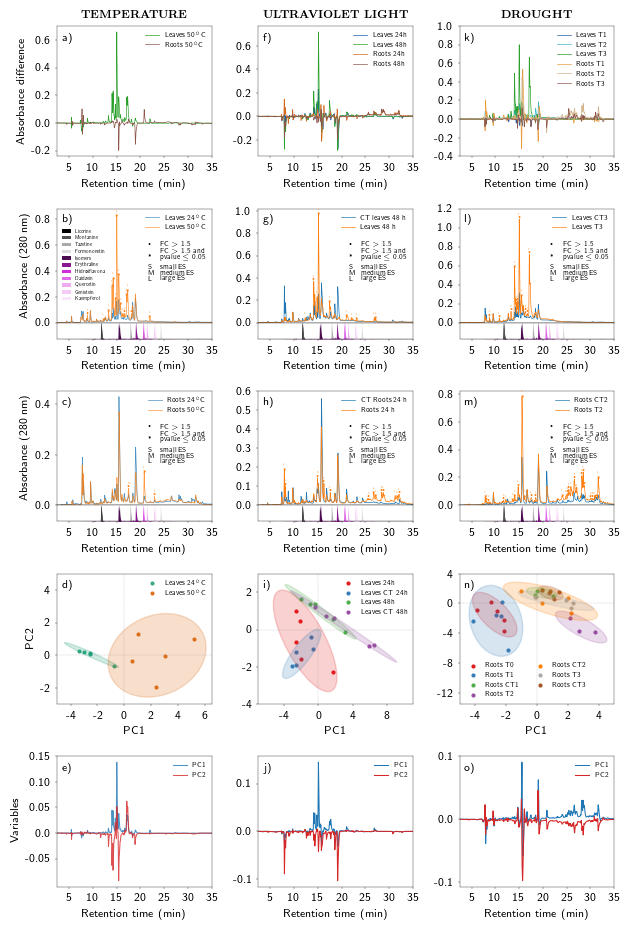

In [47]:
    
cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']   
position = [
0.6750 - 0.07-0.02, 0.71, #bola
0.680 + 0.007-0.02, 0.71, #F bola
0.6750 - 0.07-0.02, 0.62, #*
0.680 + 0.007-0.02, 0.65, #F *
0.680 + 0.007-0.02, 0.6, #pvalue
0.6750 - 0.07-0.02, 0.51, #S
0.6750 - 0.07-0.02, 0.46, #M 
0.6750 - 0.07-0.02, 0.41,   #L
0.680 + 0.007-0.02, 0.51, #small
0.680 + 0.007-0.02, 0.46,#medium
0.680 + 0.007-0.02, 0.41,#large
0.6750 - 0.1-0.02, 0.31,
0.6750 - 0.1-0.02, 0.31]
alpha_bottom = 1
xlimmin_pca1=0
xlimmax_pca1=0
ylimmin_pca1=0
ylimmax_pca1=0
plots_em_x = 3
plots_em_y = 5
dpi = 750
tempo         = nacl_ori_normalizado_media['Time']

fig = plt.figure(figsize=(6.4, 9.4))
outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)

lista_cores   = ['C0', 'C1']
alpha = 1
lw=0.5
xlim_max     = 35
xlim_min     = 2.5
xticks       = [5, 10, 15, 20, 25, 30, 35]  #se lista vazia, python escolhe os numeros
xticks_label = ['5','10','15','20','25','30','35'] #se lista vazia, python escolhe os numeros
ylabel       = r'Absorbance difference'
xlabel       = r'Retention time (min)'
fontsize_legenda   = 5
fontsize_label     = 8 # tamanho das legendas e dos números do eixo
fontsize_letra     = 8 # tamanho da letra do painel
fontsize_circulo   = 3
fontsize_asterisco = 5
fontsize_t_efeito  = 2
fontsize_titulo = 8 

titulo       = r"$\bf{TEMPERATURE}$"

# [ + "\n" + "Absorbance (280 nm)",'',  
#                r"$\bf{ULTRAVIOLET\ LIGTH}$" + "\n" + "Absorbance (280 nm)", '', #(r"$\bf{ABSCISIC\ ACID}$" + "\n" + "Absorbance (280 nm)")
#                r"$\bf{WATER\ STRESS}$" + "\n" + "Absorbance (280 nm)", '',
#                r"$\bf{SALINE\ STRESS}$" + "\n" + "Absorbance (280 nm)", '',
#                r"$\bf{MECHANICAL\ DAMAGE}$" + "\n" + "Absorbance (280 nm)", '']


xticks       = [5, 10, 15, 20, 25, 30, 35]  #se lista vazia, python escolhe os numeros
xticks_label = ['5','10','15','20','25','30','35'] #se lista vazia, python escolhe os numeros
yticks       = [-0.2,0.0, 0.2,0.4,0.6] #se lista vazia, python escolhe os numeros
yticks_label = ['-0.2','0.0', '0.2','0.4','0.6']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 180 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'a)'

lista_plots   = [temp_ori_normalizado_media['FT50'] - temp_ori_normalizado_media['FT24'],
                 temp_ori_normalizado_media['RT50'] - temp_ori_normalizado_media['RT24']]

lista_label   = ['Leaves 50$^{\circ}$C','Roots 50$^{\circ}$C' ]


A = 0 #mudar o painel
B = 0 #mudar o painel

ax_top = fig.add_subplot(outer_gs[A, B])
ylimmax=None

lista_cores   = ['C2', 'C5']
#mudar o df!!!
df_func=df_T
lista_nomes=[]
figura_nova = 'sub'
ax_bottom=[]

df_painel_a = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
        xlimmax_pca1,
        ylimmin_pca1,
        ylimmax_pca1)


###############################################################################################
###############################################################################################


lista_cores   = ['C0', 'C1']
alpha = 0.8
lw=0.5
xlim_max     = 35
xlim_min     = 2.5
xticks       = [5, 10, 15, 20, 25, 30, 35]  #se lista vazia, python escolhe os numeros
xticks_label = ['5','10','15','20','25','30','35'] #se lista vazia, python escolhe os numeros
ylabel       = r'Absorbance (280 nm)'
xlabel       = r'Retention time (min)'
fontsize_legenda   = 5
fontsize_label     = 8 # tamanho das legendas e dos números do eixo
fontsize_letra     = 8 # tamanho da letra do painel
fontsize_circulo   = 3
fontsize_asterisco = 5
fontsize_t_efeito  = 2


yticks       = [0.0, 0.2,0.4,0.6,0.8] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0', '0.2','0.4','0.6','0.8']


tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 180 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'b)'
lista_nomes = ['FT24','FT50']
lista_plots   = [temp_ori_normalizado_media['FT24'],temp_ori_normalizado_media['FT50']]

lista_label   = ['Leaves 24$^{\circ}$C','Leaves 50$^{\circ}$C',             
       
                 ]
ylimmax = 0.88

A = 1 #mudar o painel
B = 0 #mudar o painel


inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A,B],
            height_ratios=[7, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])


df_func=df_T
figura_nova = 'picos'
df_painel_a = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
        xlimmax_pca1,
        ylimmin_pca1,
        ylimmax_pca1)



###########################################################
###########################################################


tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 180 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'c)'
lista_nomes = ['RT24','RT50']
lista_plots   = [temp_ori_normalizado_media['RT24'],temp_ori_normalizado_media['RT50']

                 
                 
]
lista_label   = ['Roots 24$^{\circ}$C','Roots 50$^{\circ}$C',                    ]



A = 2 #mudar o painel
B = 0 #mudar o painel
yticks       = [0.0, 0.2,0.4] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0', '0.2','0.4']


inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A,B], 
            height_ratios=[7, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])


#mudar o df!!!
figura_nova = 'picos'
ylimmax = None
df_func=df_T
df_painel_b = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
        xlimmax_pca1,
        ylimmin_pca1,
        ylimmax_pca1)


######################################################################################
######################################################################################


A = 3 #mudar o painel
B = 0 #mudar o painel


ax_top = fig.add_subplot(outer_gs[A, B])

tempo         = [s_leaves_24['PC1'],s_leaves_50['PC1']]      
lista_plots   = [s_leaves_24['PC2'],s_leaves_50['PC2']]

          
                 
lista_label   =['Leaves 24$^{\circ}$C','Leaves 50$^{\circ}$C']

lista_cores   = ['#1b9e77','#d95f02']
ylabel       = r'PC2'
xlabel       = r'PC1'
xticks       =[-4,-2,0,2,4,6]
xticks_label = ['-4','-2','0','2','4','6']
yticks    =   [-2,0,2,4]
yticks_label=['-2','0','2','4']
figura_nova = 'pca 1'
ylimmax = None
df_func=df_T

letra_painel = 'd)'

xlimmin_pca1=-5
xlimmax_pca1=6.5
ylimmin_pca1=-3
ylimmax_pca1=5

df_painel_b = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
        xlimmax_pca1,
        ylimmin_pca1,
        ylimmax_pca1)




##################################################################3
##################################################################

A = 4 #mudar o painel
B = 0 #mudar o painel


ax_top = fig.add_subplot(outer_gs[A, B])

tempo = loadings_leaves['time']
lista_plots = [loadings_leaves['PC1'], loadings_leaves['PC2']]
lista_label = ['PC1','PC2']
lista_cores = ['C0', 'C3']
ylabel       = r'Variables'
xlabel       = r'Retention time (min)'
xticks       = [5, 10, 15, 20, 25, 30, 35]  #se lista vazia, python escolhe os numeros
xticks_label = ['5','10','15','20','25','30','35'] #se lista vazia, python escolhe os numeros
yticks       = [-0.05,0,0.05,0.1,0.15] #se lista vazia, python escolhe os numeros
yticks_label = ['-0.05','0.0','0.05','0.10','0.15']


figura_nova = 'pca 2'
ylimmax = None
df_func=df_T

letra_painel = 'e)'
df_painel_b = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
        xlimmax_pca1,
        ylimmin_pca1,
        ylimmax_pca1)

######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################

lista_cores   = ['C0', 'C1']
alpha = 1
lw=0.5
xlim_max     = 35
xlim_min     = 2.5
xticks       = [5, 10, 15, 20, 25, 30, 35]  #se lista vazia, python escolhe os numeros
xticks_label = ['5','10','15','20','25','30','35'] #se lista vazia, python escolhe os numeros
ylabel       = r''
xlabel       = r'Retention time (min)'
fontsize_legenda   = 5
fontsize_label     = 8 # tamanho das legendas e dos números do eixo
fontsize_letra     = 8 # tamanho da letra do painel
fontsize_circulo   = 3
fontsize_asterisco = 5
fontsize_t_efeito  = 2
fontsize_titulo = 8 

titulo       = r"$\bf{ULTRAVIOLET\ LIGHT}$"

# [ + "\n" + "Absorbance (280 nm)",'',  
#                r"$\bf{ULTRAVIOLET\ LIGTH}$" + "\n" + "Absorbance (280 nm)", '', #(r"$\bf{ABSCISIC\ ACID}$" + "\n" + "Absorbance (280 nm)")
#                r"$\bf{WATER\ STRESS}$" + "\n" + "Absorbance (280 nm)", '',
#                r"$\bf{SALINE\ STRESS}$" + "\n" + "Absorbance (280 nm)", '',
#                r"$\bf{MECHANICAL\ DAMAGE}$" + "\n" + "Absorbance (280 nm)", '']


xticks       = [5, 10, 15, 20, 25, 30, 35]  #se lista vazia, python escolhe os numeros
xticks_label = ['5','10','15','20','25','30','35'] #se lista vazia, python escolhe os numeros
yticks       = [-0.2,0.0,0.2,0.4,0.6] #se lista vazia, python escolhe os numeros
yticks_label = ['-0.2','0.0','0.2','0.4','0.6']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 180 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'f)'
tempo         = uv_ori_normalizado_media['Time']
lista_plots   = [uv_ori_normalizado_media['FUV24']-uv_ori_normalizado_media['FCUV24'],
                uv_ori_normalizado_media['FUV48']-uv_ori_normalizado_media['FCUV48'],
                uv_ori_normalizado_media['RUV24']-uv_ori_normalizado_media['RCUV24'],
                uv_ori_normalizado_media['RUV48']-uv_ori_normalizado_media['RCUV48']]

lista_label   = ['Leaves 24h','Leaves 48h','Roots 24h', 'Roots 48h']


A = 0 #mudar o painel
B = 1 #mudar o painel

ax_top = fig.add_subplot(outer_gs[A, B])
ylimmax=None

lista_cores   = ['#225ea8','C2','chocolate','C5']
#mudar o df!!!
df_func=df_uv
figura_nova = 'sub'
df_painel_a = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
                       xlimmax_pca1,
                       ylimmin_pca1,
                       ylimmax_pca1)



###########################################################
###########################################################

lista_cores   = ['C0', 'C1']
alpha = 1
lw=0.5
xlim_max     = 35
xlim_min     = 2.5
xticks       = [5, 10, 15, 20, 25, 30, 35]  #se lista vazia, python escolhe os numeros
xticks_label = ['5','10','15','20','25','30','35'] #se lista vazia, python escolhe os numeros
ylabel       = r''
xlabel       = r'Retention time (min)'
fontsize_legenda   = 5
fontsize_label     = 8 # tamanho das legendas e dos números do eixo
fontsize_letra     = 8 # tamanho da letra do painel
fontsize_circulo   = 3
fontsize_asterisco = 5
fontsize_t_efeito  = 2


yticks       = [0.0, 0.2,0.4,0.6,0.8,1.0] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0', '0.2','0.4','0.6','0.8','1.0']



tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 180 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'g)'
lista_nomes = ['FCUV48','FUV48']
lista_plots   = [uv_ori_normalizado_media['FCUV48'],uv_ori_normalizado_media['FUV48']

                 
                 
]
lista_label   = ['CT leaves 48 h','Leaves 48 h',                         
        
                 ]
ylimmax = None

A = 1 #mudar o painel
B = 1 #mudar o painel


inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A,B],
            height_ratios=[7, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])


df_func=df_uv
figura_nova = 'picos'
df_painel_a = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
                       xlimmax_pca1,
                       ylimmin_pca1,
                       ylimmax_pca1)



###########################################################
###########################################################


tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 180 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'h)'
yticks       = [0.0, 0.1,0.2,0.3,0.4,0.5, 0.6] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0', '0.1','0.2','0.3','0.4','0.5','0.6']
lista_nomes = ['RCUV24','RUV24']
lista_plots   = [uv_ori_normalizado_media['RCUV24'],uv_ori_normalizado_media['RUV24']

                 
                 
]
lista_label   = ['CT Roots 24 h','Roots 24 h',                         
        
                 ]



A = 2 #mudar o painel
B = 1 #mudar o painel




inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A,B], 
            height_ratios=[7, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])


#mudar o df!!!
figura_nova = 'picos'
ylimmax = None
df_func=df_uv
df_painel_b = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
                       xlimmax_pca1,
                       ylimmin_pca1,
                       ylimmax_pca1)





######################################################################################
######################################################################################

A = 3 #mudar o painel
B = 1 #mudar o painel


ax_top = fig.add_subplot(outer_gs[A, B])

#tempo é o eixo X
tempo         = [s_leaves_t24['PC1'],s_leaves_ct24['PC1'],s_leaves_t48['PC1'],s_leaves_ct48['PC1']]      
lista_plots   = [s_leaves_t24['PC2'],s_leaves_ct24['PC2'],s_leaves_t48['PC2'],s_leaves_ct48['PC2']]

               
lista_label   =['Leaves 24h',
'Leaves CT 24h',
'Leaves 48h',
'Leaves CT 48h']

lista_cores   = ['#e41a1c',
                    '#377eb8',
                    '#4daf4a',
                    '#984ea3',]

# ylabel       = r'PC2'
xlabel       = r'PC1'
xticks       =[-4,0,4,8]
xticks_label = ['-4','0','4','8']
yticks    =   [-4,-2,0,2]
yticks_label=['-4','-2','0','2']
figura_nova = 'pca 1'
ylimmax = None
df_func=df_uv
xlimmin_pca1=-7
xlimmax_pca1=11
ylimmin_pca1=-4
ylimmax_pca1=3
letra_painel = 'i)'
df_painel_b = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
                       xlimmax_pca1,
                       ylimmin_pca1,
                       ylimmax_pca1)





##################################################################
##################################################################


A = 4 #mudar o painel
B = 1 #mudar o painel


ax_top = fig.add_subplot(outer_gs[A, B])

tempo = loadings_leaves_uv['time']
lista_plots = [loadings_leaves_uv['PC1'], loadings_leaves_uv['PC2']]
lista_label = ['PC1','PC2']
lista_cores = ['C0', 'C3']
# ylabel       = r'Variable'
xlabel       = r'Retention time (min)'
xticks       = [5, 10, 15, 20, 25, 30, 35]  #se lista vazia, python escolhe os numeros
xticks_label = ['5','10','15','20','25','30','35'] #se lista vazia, python escolhe os numeros
yticks       = [-0.1,0,0.1] #se lista vazia, python escolhe os numeros
yticks_label = ['-0.1','0.0','0.1']


figura_nova = 'pca 2'
ylimmax = None
df_func=df_uv

xlimmin_pca1=None
xlimmax_pca1=None
ylimmin_pca1=None
ylimmax_pca1=None

letra_painel = 'j)'
df_painel_b = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
                       xlimmax_pca1,
                       ylimmin_pca1,
                       ylimmax_pca1)




######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################

alpha = 1
lw=0.5
xlim_max     = 35
xlim_min     = 2.5
xticks       = [5, 10, 15, 20, 25, 30, 35]  #se lista vazia, python escolhe os numeros
xticks_label = ['5','10','15','20','25','30','35'] #se lista vazia, python escolhe os numeros
ylabel       = r''
xlabel       = r'Retention time (min)'
fontsize_legenda   = 5
fontsize_label     = 8 # tamanho das legendas e dos números do eixo
fontsize_letra     = 8 # tamanho da letra do painel
fontsize_circulo   = 3
fontsize_asterisco = 5
fontsize_t_efeito  = 2
fontsize_titulo = 8 

titulo       = r"$\bf{DROUGHT}$"

# [ + "\n" + "Absorbance (280 nm)",'',  
#                r"$\bf{ULTRAVIOLET\ LIGTH}$" + "\n" + "Absorbance (280 nm)", '', #(r"$\bf{ABSCISIC\ ACID}$" + "\n" + "Absorbance (280 nm)")
#                r"$\bf{WATER\ STRESS}$" + "\n" + "Absorbance (280 nm)", '',
#                r"$\bf{SALINE\ STRESS}$" + "\n" + "Absorbance (280 nm)", '',
#                r"$\bf{MECHANICAL\ DAMAGE}$" + "\n" + "Absorbance (280 nm)", '']


xticks       = [5, 10, 15, 20, 25, 30, 35]  #se lista vazia, python escolhe os numeros
xticks_label = ['5','10','15','20','25','30','35'] #se lista vazia, python escolhe os numeros
yticks       = [-0.4,-0.2,0.0,0.2,0.4,0.6,0.8,1.0] #se lista vazia, python escolhe os numeros
yticks_label = ['-0.4','-0.2','0.0','0.2','0.4','0.6','0.8','1.0']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 180 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'k)'
tempo         = hidrico_ori_normalizado_media['Time']
lista_plots   = [hidrico_ori_normalizado_media['FTH1']-hidrico_ori_normalizado_media['FCTH1'],
                hidrico_ori_normalizado_media['FTH2']-hidrico_ori_normalizado_media['FCTH2'],
                hidrico_ori_normalizado_media['FTH3']-hidrico_ori_normalizado_media['FCTH3'],
                hidrico_ori_normalizado_media['RTH1']-hidrico_ori_normalizado_media['RCTH1'],
                hidrico_ori_normalizado_media['RTH2']-hidrico_ori_normalizado_media['RCTH2'],
                hidrico_ori_normalizado_media['RTH3']-hidrico_ori_normalizado_media['RCTH3']]

lista_label   = ['Leaves T1','Leaves T2','Leaves T3','Roots T1','Roots T2','Roots T3']


A = 0 #mudar o painel
B = 2

ax_top = fig.add_subplot(outer_gs[A, B])
ylimmax=None

lista_cores   = ['#225ea8','#41b6c4','C2','#E89C40','tan','C5']
#mudar o df!!!
df_func=df_h
figura_nova = 'sub'
df_painel_a = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
                       xlimmax_pca1,
                       ylimmin_pca1,
                       ylimmax_pca1)



###########################################################
###########################################################

lista_cores   = ['C0', 'C1']
alpha = 1
lw=0.5
xlim_max     = 35
xlim_min     = 2.5
xticks       = [5, 10, 15, 20, 25, 30, 35]  #se lista vazia, python escolhe os numeros
xticks_label = ['5','10','15','20','25','30','35'] #se lista vazia, python escolhe os numeros
ylabel       = r''
xlabel       = r'Retention time (min)'
fontsize_legenda   = 5
fontsize_label     = 8 # tamanho das legendas e dos números do eixo
fontsize_letra     = 8 # tamanho da letra do painel
fontsize_circulo   = 3
fontsize_asterisco = 5
fontsize_t_efeito  = 2

yticks       = [0.0, 0.2,0.4,0.6,0.8,1.0,1.2]
yticks_label = ['0.0', '0.2','0.4','0.6','0.8','1.0','1.2']


tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 180 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'l)'
lista_nomes = ['FCTH3','FTH3']
lista_plots   = [hidrico_ori_normalizado_media['FCTH3'],hidrico_ori_normalizado_media['FTH3']

                 
                 
]
lista_label   = ['Leaves CT3','Leaves T3',                         
        
                 ]
ylimmax = None

A = 1 #mudar o painel
B = 2 #mudar o painel


inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A,B],
            height_ratios=[7, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])


df_func=df_h
figura_nova = 'picos'
df_painel_a = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
                       xlimmax_pca1,
                       ylimmin_pca1,
                       ylimmax_pca1)



###########################################################
###########################################################


tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 180 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'm)'
yticks       = [0.0,0.2,0.4,0.6,0.8] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0','0.2','0.4','0.6','0.8']
lista_nomes = ['RCTH2','RTH2']
lista_plots   = [hidrico_ori_normalizado_media['RCTH2'],hidrico_ori_normalizado_media['RTH2']

                 
                 
]
lista_label   = ['Roots CT2','Roots T2',                         
        
                 ]


A = 2 #mudar o painel
B = 2 #mudar o painel

inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A,B], 
            height_ratios=[7, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])


#mudar o df!!!
figura_nova = 'picos'
ylimmax = None
df_func=df_h
df_painel_b = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
                       xlimmax_pca1,
                       ylimmin_pca1,
                       ylimmax_pca1)





######################################################################################
######################################################################################

A = 3 #mudar o painel
B = 2 #mudar o painel


ax_top = fig.add_subplot(outer_gs[A, B])

#tempo é o eixo X
tempo         = [s_roots_t0['PC1'],
s_roots_t1['PC1'],
s_roots_ct1['PC1'],
s_roots_t2['PC1'],
s_roots_ct2['PC1'],
s_roots_t3['PC1'],
s_roots_ct3['PC1'],]  

lista_plots   = [s_roots_t0['PC2'],
s_roots_t1['PC2'],
s_roots_ct1['PC2'],
s_roots_t2['PC2'],
s_roots_ct2['PC2'],
s_roots_t3['PC2'],
s_roots_ct3['PC2']]

               
lista_label   =['Roots T0',
'Roots T1',
'Roots CT1',
'Roots T2',
'Roots CT2',
'Roots T3',
'Roots CT3']

lista_cores   = ['#e41a1c',
'#377eb8',
'#4daf4a',
'#984ea3',
'#ff7f00',
'darkgrey',
'#a65628',]

# ylabel       = r'PC2'
xlabel       = r'PC1'
xticks       =[-4,-2,0,2,4]
xticks_label = ['-4','-2','0','2','4']
yticks    =   [-12,-8,-4,0, 4]
yticks_label=['-12','-8','-4','0','4']
figura_nova = 'pca 1'
ylimmax = None
df_func=df_h
xlimmin_pca1=-5
xlimmax_pca1=5
ylimmin_pca1=-13.5
ylimmax_pca1=4
letra_painel = 'n)'
df_painel_b = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
                       xlimmax_pca1,
                       ylimmin_pca1,
                       ylimmax_pca1)




##################################################################
##################################################################


A = 4 #mudar o painel
B = 2 #mudar o painel


ax_top = fig.add_subplot(outer_gs[A, B])

tempo = loadings_roots_h['time']
lista_plots = [loadings_roots_h['PC1'], loadings_roots_h['PC2']]
lista_label = ['PC1','PC2']
lista_cores = ['C0', 'C3']
ylabel       = r''
xlabel       = r'Retention time (min)'
xticks       = [5, 10, 15, 20, 25, 30, 35]  #se lista vazia, python escolhe os numeros
xticks_label = ['5','10','15','20','25','30','35'] #se lista vazia, python escolhe os numeros
yticks       = [-0.1,0,0.1] #se lista vazia, python escolhe os numeros
yticks_label = ['-0.1','0.0','0.1']


figura_nova = 'pca 2'
ylimmax = None
df_func=df_uv

xlimmin_pca1=None
xlimmax_pca1=None
ylimmin_pca1=None
ylimmax_pca1=None

letra_painel = 'o)'
df_painel_b = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
                       xlimmax_pca1,
                       ylimmin_pca1,
                       ylimmax_pca1)





# plt.savefig('/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/Fig_principal_final/fig2.pdf', bbox_inches='tight', pad_inches=0.1, transparent=False, dpi=dpi) 
plt.savefig('/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/proof/Fig_principal_final/fig2.tiff', bbox_inches='tight', pad_inches=0.1, transparent=False, dpi=dpi) 





# FIGURA 3 - AMBIENTAL (SALINO E DM) + 1 MEJA


In [48]:
scores_roots_nacl = pd.read_csv(r"/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/Final_figures/new/Figures/new_anova_pca_final/ANOVA-PC_05_09_2024/salino_raizes/salino_raizes_scoresRobPCA.csv")
loadings_roots_nacl = pd.read_csv(r"/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/Final_figures/new/Figures/new_anova_pca_final/ANOVA-PC_05_09_2024/salino_raizes/salino_raizes_loadingsRobPCA.csv")


scores_roots_nacl['samples'] = scores_roots_nacl['samples'].str.replace(r'-\d+$', '', regex=True)
scores_roots_nacl  #r'_\d+$' busca por _ (r'_), seguido de numero (/d), seguido de outro ou outro numeros (+)

s_roots_ct2d = scores_roots_nacl[scores_roots_nacl['samples'].str.contains("RC242")]
s_roots_t2d25 = scores_roots_nacl[scores_roots_nacl['samples'].str.contains("RS252")]
s_roots_t2d50 = scores_roots_nacl[scores_roots_nacl['samples'].str.contains("RS502")]


s_roots_ct4d = scores_roots_nacl[scores_roots_nacl['samples'].str.contains("RC244")]
s_roots_t4d25 = scores_roots_nacl[scores_roots_nacl['samples'].str.contains("RS254")]
s_roots_t4d50 = scores_roots_nacl[scores_roots_nacl['samples'].str.contains("RS504")]
s_roots_t4d50


,samples,PC1,PC2,PC3,PC4,PC5
21,RS504,-1.784084,0.383089,0.513227,0.749603,-0.184351
22,RS504,-1.507375,0.794860,0.253668,0.573743,-0.298531
23,RS504,-2.398357,-0.624297,-0.592322,-0.475876,0.689950


In [49]:
###### FOLHAS ######

scores_leaves_dm = pd.read_csv(r"/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/Final_figures/new/Figures/new_anova_pca_final/ANOVA-PC_05_09_2024/dm_folhas/dm_folhas_scoresRobPCA.csv")
loadings_leaves_dm = pd.read_csv(r"/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/Final_figures/new/Figures/new_anova_pca_final/ANOVA-PC_05_09_2024/dm_folhas/dm_folhas_loadingsRobPCA.csv")
scores_leaves_dm

scores_leaves_dm['samples'] = scores_leaves_dm['samples'].str.replace(r'-\d+$', '', regex=True)
scores_leaves_dm  #r'_\d+$' busca por _ (r'_), seguido de numero (/d), seguido de outro ou outro numeros (+)

s_leaves_ct2d = scores_leaves_dm[scores_leaves_dm['samples'].str.contains("FC242")]
s_leaves_t2d25 = scores_leaves_dm[scores_leaves_dm['samples'].str.contains("FDM12")]
s_leaves_t2d75 = scores_leaves_dm[scores_leaves_dm['samples'].str.contains("FDM32")]


s_leaves_ct4d = scores_leaves_dm[scores_leaves_dm['samples'].str.contains("FC244")]
s_leaves_t4d25 = scores_leaves_dm[scores_leaves_dm['samples'].str.contains("FDM14")]
s_leaves_t4d75 = scores_leaves_dm[scores_leaves_dm['samples'].str.contains("FDM34")]
s_leaves_t4d25


,samples,PC1,PC2,PC3,PC4,PC5
20,FDM14,-1.541137,-0.199429,-0.243059,-0.355523,-0.141132
21,FDM14,-1.104980,-0.467117,-0.020304,-0.315906,-0.034044
22,FDM14,-1.547937,-0.466064,0.280114,-0.371680,0.045024
23,FDM14,-0.202442,-1.473518,-0.363437,0.936472,0.035979
24,FDM14,-0.302027,-1.498169,-0.350336,0.986342,0.082262


In [50]:
###### FOLHAS ######

scores_leaves_meja = pd.read_csv(r"/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/Final_figures/new/Figures/new_anova_pca_final/ANOVA-PC_05_09_2024/meja_folhas/meja_folhas_scoresRobPCA.csv")
loadings_leaves_meja = pd.read_csv(r"/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/Final_figures/new/Figures/new_anova_pca_final/ANOVA-PC_05_09_2024/meja_folhas/meja_folhas_loadingsRobPCA.csv")
scores_leaves_meja

scores_leaves_meja['samples'] = scores_leaves_meja['samples'].str.replace(r'-\d+$', '', regex=True)
scores_leaves_meja  #r'_\d+$' busca por _ (r'_), seguido de numero (/d), seguido de outro ou outro numeros (+)

s_leavesMEJA_ct2d = scores_leaves_meja[scores_leaves_meja['samples'].str.contains("FC682")]
s_leaves_t2d40 = scores_leaves_meja[scores_leaves_meja['samples'].str.contains("FMJ402")]
s_leaves_t2d100 = scores_leaves_meja[scores_leaves_meja['samples'].str.contains("FMJ1002")]


s_leavesMEJA_ct4d = scores_leaves_meja[scores_leaves_meja['samples'].str.contains("FC684")]
s_leaves_t4d40 = scores_leaves_meja[scores_leaves_meja['samples'].str.contains("FMJ404")]
s_leaves_t4d100 = scores_leaves_meja[scores_leaves_meja['samples'].str.contains("FMJ1004")]

s_leaves_t2d40

,samples,PC1,PC2,PC3,PC4,PC5
5,FMJ402,0.276372,-0.236021,0.740248,0.738993,0.161891
6,FMJ402,0.391019,-0.436870,0.775341,0.672147,0.292118
7,FMJ402,-0.490568,-0.295594,0.562867,0.254409,0.054633
8,FMJ402,-0.489543,0.023836,0.438004,-0.077297,-0.077133
9,FMJ402,-0.917691,0.584226,0.246710,-0.343352,-0.077699


In [52]:
#### FUNÇÃO DAS FIGURAS:

def New_Plot(ax,tempo,lista_plots,df,lista_nomes,
             variacao_pontos,tempo_controle_asterisco,prominence,
             lista_label,cores,alpha,lw,
             ylabel,yticks, yticks_label,fontsize_label,
             fontsize_legenda,fontsize_circulo,fontsize_asterisco,fontsize_t_efeito,tempo_letra,letra_painel,
             fontsize_letra,position,
             ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom,
             figura,titulo,fontsize_titulo,ylimmax,        xlimmin_pca1,
        xlimmax_pca1,
        ylimmin_pca1,
        ylimmax_pca1,posicao_legenda,ylim_min, ylim_max,
             insert,insert_position_list, insert_xlim_min,insert_xlim_max,insert_ylim_min,insert_ylim_max,insert_fontsize,
insert_xticks,insert_xticklabels,insert_yticks,insert_yticklabels
           ):
    if figura == 'picos':
        df_pontos = pd.DataFrame(columns=['Sample', 'Retention time', 'Fold-change', 
                                          'Shapiro-test control stat', 'Shapiro-test control pvalue',
                                          'Shapiro-test trated stat', 'Shapiro-test trated pvalue',
                                          'Levene-test stat', 'Levene-test pvalue',
                                          't-test stat','t-test pvalue','D cohen',
                                          'Mann-whitney stat','Mann-whitney pvalue','r effect','Effect size'])

        ax.annotate(r'$\bullet$', xy=(position[0],position[1]), xycoords='axes fraction', 
                                fontsize=fontsize_circulo, horizontalalignment='left', verticalalignment='top')
        ax.annotate('FC $>$ 1.5', xy=(position[2],position[3]), xycoords='axes fraction', 
                                fontsize=fontsize_asterisco, horizontalalignment='left', verticalalignment='top')
        ax.annotate(r'*', xy=(position[4],position[5]), xycoords='axes fraction', 
                                fontsize=fontsize_asterisco, horizontalalignment='left', verticalalignment='top') 
        ax.annotate(r'FC $>$ 1.5 and', xy=(position[2+4],position[3+4]), xycoords='axes fraction', 
                                fontsize=fontsize_asterisco, horizontalalignment='left', verticalalignment='top')    
        ax.annotate(r'pvalue $\leq$ 0.05', xy=(position[4+4],position[5+4]), xycoords='axes fraction', 
                                fontsize=fontsize_asterisco, horizontalalignment='left', verticalalignment='top')     

        ax.annotate('S', xy=(position[6+4],position[7+4]), xycoords='axes fraction', 
                               fontsize=fontsize_asterisco, horizontalalignment='left', verticalalignment='top')     
        ax.annotate('M', xy=(position[8+4],position[9+4]), xycoords='axes fraction', 
                                fontsize=fontsize_asterisco, horizontalalignment='left', verticalalignment='top')     
        ax.annotate('L', xy=(position[10+4],position[11+4]), xycoords='axes fraction', 
                                fontsize=fontsize_asterisco, horizontalalignment='left', verticalalignment='top')

        ax.annotate('small ES', xy=(position[12+4],position[13+4]), xycoords='axes fraction', 
                                fontsize=fontsize_asterisco, horizontalalignment='left', verticalalignment='top')     
        ax.annotate('medium ES', xy=(position[14+4],position[15+4]), xycoords='axes fraction', 
                                fontsize=fontsize_asterisco, horizontalalignment='left', verticalalignment='top')     
        ax.annotate('large ES', xy=(position[16+4],position[17+4]), xycoords='axes fraction', 
                                fontsize=fontsize_asterisco, horizontalalignment='left', verticalalignment='top')    


        for j in range(len(lista_plots)):
            ax.plot(tempo, lista_plots[j], label=r'%s'%lista_label[j], 
                                lw=lw, alpha=alpha,c=cores[j])
            if j == 0:
                df_controle = df.filter(regex=lista_nomes[j])

            else:
                df_tratado = df.filter(regex=lista_nomes[j])  

                media_ct_tr = np.average([np.average(lista_plots[0]),np.average(lista_plots[j])])
                peaks, _    = find_peaks(lista_plots[j], prominence=prominence)
                sel = lista_plots[j][peaks] > media_ct_tr
                #selecionar os picos acima da média 
                for p in range (len(peaks[sel])):
                    maior_valor_controle = max(lista_plots[0][peaks[sel][p]-variacao_pontos:peaks[sel][p]+variacao_pontos]) #75 
                    razao = (lista_plots[j][peaks[sel][p]]) / (maior_valor_controle) #Fold Change
                    if razao >= 1.5 and tempo[peaks[sel][p]] < xlim_max: #limiar do fold - colcor o *
                        pontos_maximo_controle = []
                        for o in range(len(df_controle.columns)):
                            ponto_maximo = max(df_controle[df_controle.columns[o]][peaks[sel][p]-variacao_pontos:peaks[sel][p]+variacao_pontos])
                            pontos_maximo_controle.append(ponto_maximo)

                        pontos_maximo_tratado = []
                        for o in range(len(df_tratado.columns)):
                            ponto_maximo = max(df_tratado[df_tratado.columns[o]][peaks[sel][p]-variacao_pontos:peaks[sel][p]+variacao_pontos])
                            pontos_maximo_tratado.append(ponto_maximo)   

                        if len(pontos_maximo_controle) > 2 and len(pontos_maximo_tratado) > 2:
                            stat_shapiro_controle, pvalue_shapiro_controle = stats.shapiro(pontos_maximo_controle)
                            stat_shapiro_tratado, pvalue_shapiro_tratado  = stats.shapiro(pontos_maximo_tratado)     
                            stat_levene, pvalue_levene = stats.levene(pontos_maximo_controle, pontos_maximo_tratado)

                            if pvalue_shapiro_controle > 0.05 and pvalue_shapiro_tratado > 0.05 and pvalue_levene > 0.05:
                                stat_teste_t, pvalue_teste_t = stats.ttest_ind(pontos_maximo_controle,pontos_maximo_tratado)
                                D_cohen = cohens_d(pontos_maximo_controle, pontos_maximo_tratado)  
                                result = tamanho_efeito_d_cohen(D_cohen)

                                if pvalue_teste_t < 0.05:
                                    ax.text(tempo[peaks[sel][p]-tempo_controle_asterisco],
                                        lista_plots[j][peaks[sel][p]]-0.01*max(yticks), #,+ 0.005*max(yticks),
                                        '*',c=cores[j],fontsize=fontsize_asterisco)
                                    ax.text(tempo[peaks[sel][p]-tempo_letra],
                                        lista_plots[j][peaks[sel][p]] + 0.04*max(yticks),
                                        result,c=cores[j],fontsize=fontsize_t_efeito)                                
                                else:
                                    ax.text(tempo[peaks[sel][p]-tempo_controle_asterisco],
                                        lista_plots[j][peaks[sel][p]] + 0.01*max(yticks),
                                        r'$\bullet$',c=cores[j],fontsize=fontsize_circulo)
                                    ax.text(tempo[peaks[sel][p]-tempo_letra],
                                        lista_plots[j][peaks[sel][p]] + 0.04*max(yticks),
                                        result,c=cores[j],fontsize=fontsize_t_efeito)  
                                nova_linha = {'Sample': lista_label[j],      
                                              'Retention time': tempo[peaks[sel][p]-tempo_letra],
                                              'Fold-change': razao,
                                              'Shapiro-test control stat':stat_shapiro_controle,
                                              'Shapiro-test control pvalue':pvalue_shapiro_controle,
                                              'Shapiro-test trated stat':stat_shapiro_tratado,
                                              'Shapiro-test trated pvalue':pvalue_shapiro_tratado,
                                              'Levene-test stat':stat_levene,
                                              'Levene-test pvalue':pvalue_levene,
                                              't-test stat':stat_teste_t,  
                                              't-test pvalue':pvalue_teste_t,
                                              'D cohen':D_cohen,
                                              'Mann-whitney stat':None,
                                              'Mann-whitney pvalue':None,
                                              'r effect':None,
                                              'Effect size':result}
                                df_pontos = pd.concat([df_pontos, pd.DataFrame([nova_linha])], ignore_index=True)              


                            else:
                                stat_teste_MW, pvalue_MW = stats.mannwhitneyu(pontos_maximo_controle, pontos_maximo_tratado, alternative='two-sided')
                                efeito_r = effect_size_r_mannwhitney(pontos_maximo_controle, pontos_maximo_tratado, stat_teste_MW)
                                result = tamanho_efeito_r(efeito_r)
                                if pvalue_MW < 0.05:
                                    ax.text(tempo[peaks[sel][p]-tempo_controle_asterisco],
                                        lista_plots[j][peaks[sel][p]]-0.01*max(yticks),# + 0.005*max(yticks),
                                        '*',c=cores[j],fontsize=fontsize_asterisco) 
                                    ax.text(tempo[peaks[sel][p]-tempo_letra],
                                        lista_plots[j][peaks[sel][p]] + 0.04*max(yticks),
                                        result,c=cores[j],fontsize=fontsize_t_efeito)  
                                else:
                                    ax.text(tempo[peaks[sel][p]-tempo_controle_asterisco],
                                        lista_plots[j][peaks[sel][p]] + 0.01*max(yticks),
                                        r'$\bullet$',c=cores[j],fontsize=fontsize_circulo)                            
                                    ax.text(tempo[peaks[sel][p]-tempo_letra],
                                        lista_plots[j][peaks[sel][p]] + 0.04*max(yticks),
                                        result,c=cores[j],fontsize=fontsize_t_efeito)  

                                nova_linha = {'Sample': lista_label[j],   
                                              'Retention time': tempo[peaks[sel][p]-tempo_letra],
                                              'Fold-change': razao,
                                              'Shapiro-test control stat':stat_shapiro_controle,
                                              'Shapiro-test control pvalue':pvalue_shapiro_controle,
                                              'Shapiro-test trated stat':stat_shapiro_tratado,
                                              'Shapiro-test trated pvalue':pvalue_shapiro_tratado,
                                              'Levene-test stat':stat_levene,
                                              'Levene-test pvalue':pvalue_levene,
                                              't-test stat':None,  
                                              't-test pvalue':None,
                                              'D cohen':None,
                                              'Mann-whitney stat':stat_teste_MW,
                                              'Mann-whitney pvalue':pvalue_MW,
                                              'r effect':efeito_r,
                                              'Effect size':result}
                                df_pontos = pd.concat([df_pontos, pd.DataFrame([nova_linha])], ignore_index=True)
                        else:
                            ax.text(tempo[peaks[sel][p]-tempo_controle_asterisco],
                                         lista_plots[j][peaks[sel][p]] + 0.01*max(yticks),
                                        r'$\bullet$',c=cores[j],fontsize=fontsize_circulo)  
                            print(j)
                            nova_linha = {'Sample': lista_label[j],   
                                          'Retention time': tempo[peaks[sel][p]-tempo_letra],
                                          'Fold-change': razao,
                                          'Shapiro-test control stat':None,
                                          'Shapiro-test control pvalue':None,
                                          'Shapiro-test trated stat':None,
                                          'Shapiro-test trated pvalue':None,
                                          'Levene-test stat':None,
                                          'Levene-test pvalue':None,
                                          't-test stat':None,  
                                          't-test pvalue':None,
                                          'D cohen':None,
                                          'Mann-whitney stat':None,
                                          'Mann-whitney pvalue':None,
                                          'r effect':None,
                                          'Effect size':None}
                            df_pontos = pd.concat([df_pontos, pd.DataFrame([nova_linha])], ignore_index=True)

        ax.yaxis.get_major_formatter()._usetex = False               
        ax.set_ylabel(ylabel, fontsize = fontsize_label)
        ax.set_xlim(xlim_min, xlim_max)
        ax.set_ylim(0, ylimmax)
        ax.tick_params(bottom=False, labelbottom=False)

        if len(yticks) > 0:
            ax.set_yticks(yticks, yticks_label, fontsize = fontsize_label)
        else:
            ax.tick_params(axis='y', labelsize=fontsize_label)

        ax.legend(fontsize = fontsize_legenda, loc = posicao_legenda, fancybox=False, frameon=False)
        ax.annotate(letra_painel, xy=(0.03, 0.95), xycoords='axes fraction', 
                                fontsize=fontsize_letra, horizontalalignment='left', verticalalignment='top')
        New_Plot2(ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom,letra_painel)
        return df_pontos 
    
    ########################### antigo ###################
    elif figura == 'sub':
        for j in range(len(lista_plots)):
            ax.plot(tempo, lista_plots[j], label=r'%s'%lista_label[j], 
                                lw=lw, alpha=alpha,c=cores[j])
        
        ax.legend(fontsize = fontsize_legenda, loc = "upper right", fancybox=False, frameon=False)
        ax.set_title(titulo,fontsize=fontsize_titulo)
        
        ax.yaxis.get_major_formatter()._usetex = False               
        ax.set_ylabel(ylabel, fontsize = fontsize_label)
        ax.set_xlim(xlim_min, xlim_max)
        ax.set_ylim(ylim_min, ylim_max)
#         ax.tick_params(bottom=False, labelbottom=False)

        if len(yticks) > 0:
            ax.set_yticks(yticks, yticks_label, fontsize = fontsize_label)
        else:
            ax.tick_params(axis='y', labelsize=fontsize_label)

        ax.legend(fontsize = fontsize_legenda, loc = posicao_legenda, fancybox=False, frameon=False)
        ax.annotate(letra_painel, xy=(0.03, 0.95), xycoords='axes fraction', 
                                fontsize=fontsize_letra, horizontalalignment='left', verticalalignment='top')
        ax.set_xlabel(xlabel, fontsize = fontsize_label)
        if len(xticks) > 0:
            ax.set_xticks(xticks, xticks_label, fontsize = fontsize_label)
        else:
            ax.tick_params(axis='x', labelsize=fontsize_label)
        ax.xaxis.get_major_formatter()._usetex = False
        
        if insert == True:
            ax1 = ax.inset_axes(insert_position_list) 
            for j in range(len(lista_plots)):
                ax1.plot(tempo, lista_plots[j], label=r'%s'%lista_label[j], 
                                lw=lw, alpha=alpha,c=cores[j])
            
            ax1.set_xlim(insert_xlim_min,insert_xlim_max)
            ax1.set_ylim(insert_ylim_min,insert_ylim_max) 
            ax1.tick_params(axis='x', labelsize=insert_fontsize)
            ax1.tick_params(axis='y', labelsize=insert_fontsize)
            ax1.set_xticks(insert_xticks) 
            ax1.set_xticklabels(insert_xticklabels)
            ax1.set_yticks(insert_yticks)
            ax1.set_yticklabels(insert_yticklabels)
            
      ############################################################  
    elif figura =='pca 1':
        
        
        ax.axhline(y=0, color='gray', linestyle='--',lw=0.2, alpha=0.7)
        ax.axvline(x=0, color='gray', linestyle='--',lw=0.2, alpha=0.7)
        for j in range(len(lista_plots)):
            ax.scatter(tempo[j], lista_plots[j], s=4, label=r'%s'%lista_label[j], 
                                 alpha=alpha,c=cores[j])



        ax.set_ylabel(ylabel, fontsize = fontsize_label)
        ax.set_xlabel(xlabel, fontsize = fontsize_label)
        ax.set_yticks(yticks, yticks_label, fontsize = fontsize_label)
        ax.set_xticks(xticks, xticks_label, fontsize = fontsize_label)

        # Ajuste os limites dos eixos
        ax.set_xlim(xlimmin_pca1, xlimmax_pca1)
        ax.set_ylim(ylimmin_pca1, ylimmax_pca1)

        ax.legend(frameon=False,#bbox_to_anchor=(1, 1),
                        loc=posicao_legenda, fontsize=5)


        ax.annotate(letra_painel, xy=(0.03, 0.95), xycoords='axes fraction', 
                                fontsize=fontsize_letra, horizontalalignment='left', verticalalignment='top')
        if letra_painel == 'i)':
            ax.legend(frameon=False, ncol=2, #bbox_to_anchor=(1,1),
                loc=posicao_legenda, fontsize=5)  
        elif letra_painel == 'n)':
            ax.legend(frameon=False, ncol=2,  handletextpad=0.1,columnspacing=0.5 ,#bbox_to_anchor=(1,1),
                loc=posicao_legenda, fontsize=5)
            

        for j in range(len(lista_plots)):
        # Adicionando elipses de confiança aos dados com cores
            confidence_ellipse(tempo[j], lista_plots[j], ax, n_std=2.0, 
                           facecolor=cores[j], edgecolor=cores[j], alpha=0.2)

        if insert == True:
            ax1 = ax.inset_axes(insert_position_list) 
            for j in range(len(lista_plots)):
                if j != 3:
                    
                    ax1.scatter(tempo[j], lista_plots[j], s=4, label=r'%s'%lista_label[j], 
                                 alpha=alpha,c=cores[j])
                
                    confidence_ellipse(tempo[j], lista_plots[j], ax1, n_std=2.0, 
                           facecolor=cores[j], edgecolor=cores[j], alpha=0.2)
            
            ax1.set_xlim(insert_xlim_min,insert_xlim_max)
            ax1.set_ylim(insert_ylim_min,insert_ylim_max) 
            ax1.tick_params(axis='x', labelsize=insert_fontsize)
            ax1.tick_params(axis='y', labelsize=insert_fontsize)
            ax1.set_xticks(insert_xticks) 
            ax1.set_xticklabels(insert_xticklabels)
            ax1.set_yticks(insert_yticks)
            ax1.set_yticklabels(insert_yticklabels)
            
    elif figura == 'pca 2':

        for j in range(len(lista_plots)):
            ax.plot(tempo, lista_plots[j], label=r'%s'%lista_label[j], 
                                 alpha=alpha,c=cores[j])

        ax.set_xlim(xlim_min, xlim_max)
        ax.set_ylabel(ylabel, fontsize = fontsize_label)
        ax.set_xlabel(xlabel, fontsize = fontsize_label)
        ax.set_yticks(yticks, yticks_label, fontsize = fontsize_label)
        ax.set_xticks(xticks, xticks_label, fontsize = fontsize_label)

        # Adicione a legenda e ajuste o tamanho do texto
        # axs[1].legend(bbox_to_anchor=(0.76, 0.95), loc='upper left', fontsize=9, title_fontsize=12)
        ax.legend(frameon=False,fontsize=5,
#                        bbox_to_anchor=(1,1),
                  loc=posicao_legenda)

        ax.annotate(letra_painel, xy=(0.03, 0.95), xycoords='axes fraction', 
                                fontsize=fontsize_letra, horizontalalignment='left', verticalalignment='top')


        return None


def New_Plot2(ax, df, cores, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom,letra_painel):
    for i in range(1,len(df_pad.columns)):
        ax.fill_between(df['time'],df[df.columns[i]]/np.max(df[df.columns[i]]),lw=0.,
                        color=cores[i-1],alpha=alpha_bottom,
                label = df.columns[i])
        
        
    ax.set_xlabel(xlabel, fontsize = fontsize_label)
    if len(xticks) > 0:
        ax.set_xticks(xticks, xticks_label, fontsize = fontsize_label)
    else:
        ax.tick_params(axis='x', labelsize=fontsize_label)
    ax.tick_params(left=False, labelleft=False)            
    ax.set_xlim(xlim_min, xlim_max)
    ax.set_ylim(0, 1)
    ax.xaxis.get_major_formatter()._usetex = False
    if letra_painel == 'l)':
        ax.legend(fontsize = 3.3, ncol = 1,loc = "upper left",
              bbox_to_anchor=(0,7.),columnspacing=0.5, fancybox=False, frameon=False)

<>:501: SyntaxWarning: invalid escape sequence '\%'
<>:501: SyntaxWarning: invalid escape sequence '\%'
<>:501: SyntaxWarning: invalid escape sequence '\%'
<>:501: SyntaxWarning: invalid escape sequence '\%'
<>:502: SyntaxWarning: invalid escape sequence '\%'
<>:502: SyntaxWarning: invalid escape sequence '\%'
<>:502: SyntaxWarning: invalid escape sequence '\%'
<>:502: SyntaxWarning: invalid escape sequence '\%'
<>:741: SyntaxWarning: invalid escape sequence '\%'
<>:742: SyntaxWarning: invalid escape sequence '\%'
<>:744: SyntaxWarning: invalid escape sequence '\%'
<>:745: SyntaxWarning: invalid escape sequence '\%'
<>:501: SyntaxWarning: invalid escape sequence '\%'
<>:501: SyntaxWarning: invalid escape sequence '\%'
<>:501: SyntaxWarning: invalid escape sequence '\%'
<>:501: SyntaxWarning: invalid escape sequence '\%'
<>:502: SyntaxWarning: invalid escape sequence '\%'
<>:502: SyntaxWarning: invalid escape sequence '\%'
<>:502: SyntaxWarning: invalid escape sequence '\%'
<>:502: Synt

/tmp/ipykernel_5727/2879195301.py:118: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pontos = pd.concat([df_pontos, pd.DataFrame([nova_linha])], ignore_index=True)
/tmp/ipykernel_5727/2879195301.py:156: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pontos = pd.concat([df_pontos, pd.DataFrame([nova_linha])], ignore_index=True)
/tmp/ipykernel_5727/2879195301.py:118: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this wi

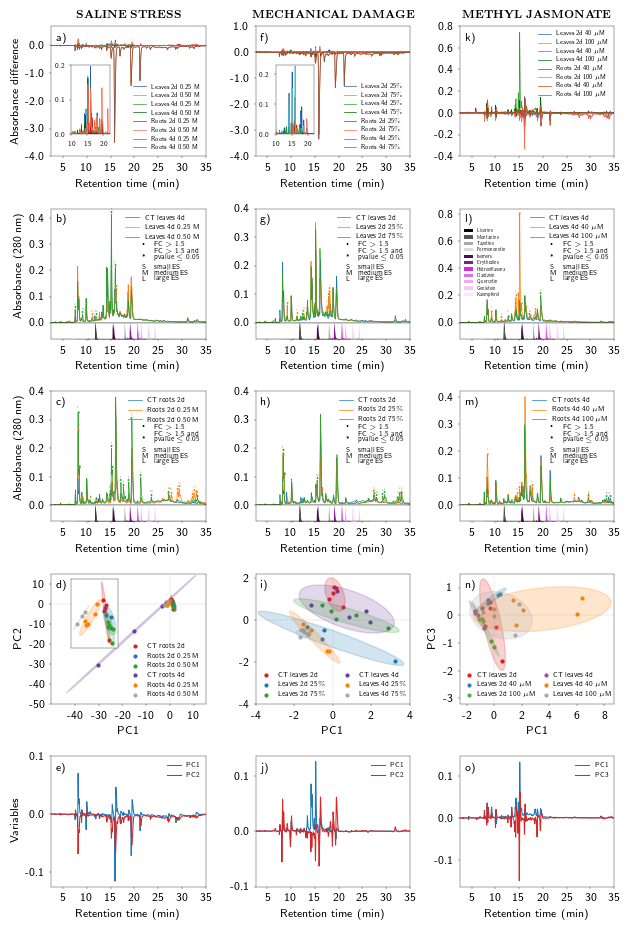

In [53]:
#     df_dm
# df_nacl
cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']   
position = [
0.6750 - 0.07-0.02, 0.71, #bola
0.680 + 0.007-0.02, 0.71, #F bola
0.6750 - 0.07-0.02, 0.62, #*
0.680 + 0.007-0.02, 0.65, #F *
0.680 + 0.007-0.02, 0.6, #pvalue
0.6750 - 0.07-0.02, 0.51, #S
0.6750 - 0.07-0.02, 0.46, #M 
0.6750 - 0.07-0.02, 0.41,   #L
0.680 + 0.007-0.02, 0.51, #small
0.680 + 0.007-0.02, 0.46,#medium
0.680 + 0.007-0.02, 0.41,#large
0.6750 - 0.1-0.02, 0.31,
0.6750 - 0.1-0.02, 0.31]
alpha_bottom = 1
xlimmin_pca1=0
xlimmax_pca1=0
ylimmin_pca1=0
ylimmax_pca1=0
plots_em_x = 3
plots_em_y = 5
dpi = 750
tempo         = nacl_ori_normalizado_media['Time']

fig = plt.figure(figsize=(6.4, 9.4))
outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)

lista_cores   = ['C0', 'C1', 'c2']
alpha = 1
lw=0.5
xlim_max     = 35
xlim_min     = 2.5
xticks       = [5, 10, 15, 20, 25, 30, 35]  #se lista vazia, python escolhe os numeros
xticks_label = ['5','10','15','20','25','30','35'] #se lista vazia, python escolhe os numeros
ylabel       = r'Absorbance difference'
xlabel       = r'Retention time (min)'
fontsize_legenda   = 4.5
fontsize_label     = 8 # tamanho das legendas e dos números do eixo
fontsize_letra     = 8 # tamanho da letra do painel
fontsize_circulo   = 3
fontsize_asterisco = 5
fontsize_t_efeito  = 2
fontsize_titulo = 8 

titulo       = r"$\bf{SALINE\ STRESS}$"

# [ + "\n" + "Absorbance (280 nm)",'',  
#                r"$\bf{ULTRAVIOLET\ LIGTH}$" + "\n" + "Absorbance (280 nm)", '', #(r"$\bf{ABSCISIC\ ACID}$" + "\n" + "Absorbance (280 nm)")
#                r"$\bf{WATER\ STRESS}$" + "\n" + "Absorbance (280 nm)", '',
#                r"$\bf{SALINE\ STRESS}$" + "\n" + "Absorbance (280 nm)", '',
#                r"$\bf{MECHANICAL\ DAMAGE}$" + "\n" + "Absorbance (280 nm)", '']


xticks       = [5, 10, 15, 20, 25, 30, 35]  #se lista vazia, python escolhe os numeros
xticks_label = ['5','10','15','20','25','30','35'] #se lista vazia, python escolhe os numeros
yticks       = [-4.0,-3.0,-2.0,-1.0,0.0] #se lista vazia, python escolhe os numeros
yticks_label = ['-4.0','-3.0','-2.0','-1.0','0.0']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 180 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'a)'
lista_plots   = [nacl_ori_normalizado_media['FS252']-nacl_ori_normalizado_media['FC242'],
                nacl_ori_normalizado_media['FS502']-nacl_ori_normalizado_media['FC242'],
                nacl_ori_normalizado_media['FS254']-nacl_ori_normalizado_media['FC244'],
                nacl_ori_normalizado_media['FS504']-nacl_ori_normalizado_media['FC244'],
                nacl_ori_normalizado_media['RS252']-nacl_ori_normalizado_media['RC242'],
                nacl_ori_normalizado_media['RS502']-nacl_ori_normalizado_media['RC242'],
                nacl_ori_normalizado_media['RS254']-nacl_ori_normalizado_media['RC244'],
                nacl_ori_normalizado_media['RS504']-nacl_ori_normalizado_media['RC244'],]

lista_label   = ['Leaves 2d 0.25 M','Leaves 2d 0.50 M','Leaves 4d 0.25 M','Leaves 4d 0.50 M',
                 'Roots 2d 0.25 M','Roots 2d 0.50 M','Roots 4d 0.25 M','Roots 4d 0.50 M']


A = 0 #mudar o painel
B = 0 #mudar o painel

ax_top = fig.add_subplot(outer_gs[A, B])
ylimmax=0.9

lista_cores   = ['#225ea8','#41b6c4','C2','darkgreen','#cb181d','#fb6a4a','#cc4c02','C5']
# '','','C2','#E89C40','tan','C5'

#mudar o df!!!
df_func=df_nacl
figura_nova = 'sub'
posicao_legenda = 'lower right'
ylim_min=-4
ylim_max=0.7
insert = True
insert_position_list = [0.13, 0.17, 0.25, 0.53]
insert_xlim_min=10
insert_xlim_max=22
insert_ylim_min =0.0
insert_ylim_max=0.2
insert_fontsize = 5
insert_xticks = [10, 15, 20]
insert_xticklabels = [10, 15, 20]
insert_yticks = [0.0, 0.1, 0.2]
insert_yticklabels = [0.0, 0.1, 0.2]
df_painel_d = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
                       xlimmax_pca1,
                       ylimmin_pca1,
                       ylimmax_pca1,
                       posicao_legenda,
                      ylim_min, ylim_max,
                       insert,insert_position_list, insert_xlim_min,
insert_xlim_max,insert_ylim_min,insert_ylim_max,insert_fontsize,
insert_xticks,insert_xticklabels,insert_yticks,insert_yticklabels)



###############################################################################################
###############################################################################################


lista_cores   = ['C0', 'C1', 'C2']
alpha = 1
lw=0.5
xlim_max     = 35
xlim_min     = 2.5
xticks       = [5, 10, 15, 20, 25, 30, 35]  #se lista vazia, python escolhe os numeros
xticks_label = ['5','10','15','20','25','30','35'] #se lista vazia, python escolhe os numeros
ylabel       = r'Absorbance (280 nm)'
xlabel       = r'Retention time (min)'
fontsize_legenda   = 5
fontsize_label     = 8 # tamanho das legendas e dos números do eixo
fontsize_letra     = 8 # tamanho da letra do painel
fontsize_circulo   = 3
fontsize_asterisco = 5
fontsize_t_efeito  = 2

yticks       = [ 0.0,0.1,0.2,0.3,0.4] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0','0.1','0.2','0.3','0.4']


tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 180 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'b)'
lista_nomes = ['FC244','FS254','FS504']
lista_plots   = [       
                 nacl_ori_normalizado_media['FC244'],
                 nacl_ori_normalizado_media['FS254'],                 
                 nacl_ori_normalizado_media['FS504'],
                 

]
lista_label   = ['CT leaves 4d','Leaves 4d 0.25 M','Leaves 4d 0.50 M',                         
#                        
                 ]
ylimmax = None

A = 1 #mudar o painel
B = 0 #mudar o painel


inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A,B],
            height_ratios=[7, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])


df_func=df_nacl
figura_nova = 'picos'
posicao_legenda = 'upper right'
ylim_min=-4
ylim_max=0.7
insert = False
insert_position_list = [0.095, 0.17, 0.3, 0.53]
insert_xlim_min=10
insert_xlim_max=22
insert_ylim_min =0.0
insert_ylim_max=0.2
insert_fontsize = 5
insert_xticks = [10, 15, 20]
insert_xticklabels = [10, 15, 20]
insert_yticks = [0.0, 0.1, 0.2]
insert_yticklabels = [0.0, 0.1, 0.2]
df_painel_b = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
                       xlimmax_pca1,
                       ylimmin_pca1,
                       ylimmax_pca1,
                       posicao_legenda,
                      ylim_min, ylim_max,
                       insert,insert_position_list, insert_xlim_min,
insert_xlim_max,insert_ylim_min,insert_ylim_max,insert_fontsize,
insert_xticks,insert_xticklabels,insert_yticks,insert_yticklabels)



# ###########################################################
# ###########################################################


tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 180 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'c)'
lista_nomes = ['RC242','RS252','RS502']
lista_plots   = [

                 nacl_ori_normalizado_media['RC242'],
                 nacl_ori_normalizado_media['RS252'],
                 nacl_ori_normalizado_media['RS502'],

]
lista_label   = [ 
                    'CT roots 2d','Roots 2d 0.25 M','Roots 2d 0.50 M',        
                 ]


A = 2 #mudar o painel
B = 0 #mudar o painel
yticks       = [ 0.0,0.1,0.2,0.3,0.4] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0','0.1','0.2','0.3','0.4']

inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A,B], 
            height_ratios=[7, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])


#mudar o df!!!
figura_nova = 'picos'
ylimmax = None
df_func=df_nacl
posicao_legenda = 'upper right'
ylim_min=-4
ylim_max=0.7
insert = False
insert_position_list = [0.095, 0.17, 0.3, 0.53]
insert_xlim_min=10
insert_xlim_max=22
insert_ylim_min =0.0
insert_ylim_max=0.2
insert_fontsize = 5
insert_xticks = [10, 15, 20]
insert_xticklabels = [10, 15, 20]
insert_yticks = [0.0, 0.1, 0.2]
insert_yticklabels = [0.0, 0.1, 0.2]
df_painel_c = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
                       xlimmax_pca1,
                       ylimmin_pca1,
                       ylimmax_pca1,
                       posicao_legenda,
                      ylim_min, ylim_max,
                       insert,insert_position_list, insert_xlim_min,
insert_xlim_max,insert_ylim_min,insert_ylim_max,insert_fontsize,
insert_xticks,insert_xticklabels,insert_yticks,insert_yticklabels)

# ######################################################################################
# ######################################################################################


A = 3 #mudar o painel
B = 0 #mudar o painel


ax_top = fig.add_subplot(outer_gs[A, B])

tempo         = [   s_roots_ct2d['PC1'],
                    s_roots_t2d25['PC1'],
                    s_roots_t2d50['PC1'],
                    s_roots_ct4d['PC1'],
                    s_roots_t4d25['PC1'],
                    s_roots_t4d50['PC1'],]      
lista_plots   = [s_roots_ct2d['PC2'],
s_roots_t2d25['PC2'],
s_roots_t2d50['PC2'],
s_roots_ct4d['PC2'],
s_roots_t4d25['PC2'],
s_roots_t4d50['PC2'],]

          
                 
lista_label   =['CT roots 2d',
'Roots 2d 0.25 M',
'Roots 2d 0.50 M',
'CT roots 4d',
'Roots 4d 0.25 M',
'Roots 4d 0.50 M']

lista_cores   = ['#e31a1c',
'#1f78b4',
'#33a02c',
'#6a3d9a',
'#ff7f00',
'darkgrey',]
# ylabel       = r'PC2'
xlabel       = r'PC1'
xticks       =[-40,-30,-20,-10,0,10]
xticks_label = ['-40','-30','-20','-10','0','10']
yticks    =   [-50,-40,-30,-20,-10,0,10,20]
yticks_label=['-50','-40','-30','-20','-10','0','10','20']
figura_nova = 'pca 1'
ylimmax = None

letra_painel = 'd)'

xlimmin_pca1=-50
xlimmax_pca1=15
ylimmin_pca1=-50
ylimmax_pca1=15

df_func=df_nacl
posicao_legenda = 'lower right'
ylim_min=-4
ylim_max=0.7
insert = True
insert_position_list = [0.13, 0.43, 0.3, 0.53]
insert_xlim_min=None
insert_xlim_max=None
insert_ylim_min =None
insert_ylim_max=None
insert_fontsize = 5
insert_xticks = []
insert_xticklabels = []
insert_yticks = []
insert_yticklabels = []
ylabel       = r'PC2'
df_painel_d = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
                       xlimmax_pca1,
                       ylimmin_pca1,
                       ylimmax_pca1,
                       posicao_legenda,
                      ylim_min, ylim_max,
                       insert,insert_position_list, insert_xlim_min,
insert_xlim_max,insert_ylim_min,insert_ylim_max,insert_fontsize,
insert_xticks,insert_xticklabels,insert_yticks,insert_yticklabels)



##################################################################3
##################################################################

A = 4 #mudar o painel
B = 0 #mudar o painel


ax_top = fig.add_subplot(outer_gs[A, B])

tempo = loadings_roots_nacl['time']
lista_plots = [loadings_roots_nacl['PC1'],
                loadings_roots_nacl['PC2'],]

lista_label = ['PC1','PC2']
lista_cores = ['C0', 'C3']
ylabel       = r'Variables'
xlabel       = r'Retention time (min)'
xticks       = [5, 10, 15, 20, 25, 30, 35]  #se lista vazia, python escolhe os numeros
xticks_label = ['5','10','15','20','25','30','35'] #se lista vazia, python escolhe os numeros
yticks       = [-0.1,0,0.1] #se lista vazia, python escolhe os numeros
yticks_label = ['-0.1','0.0','0.1']


figura_nova = 'pca 2'
xlimmin_pca1=-50
xlimmax_pca1=15
ylimmin_pca1=-50
ylimmax_pca1=15

df_func=df_nacl
posicao_legenda = 'upper right'
ylim_min=-4
ylim_max=0.7
insert = False
insert_position_list = [0.13, 0.43, 0.3, 0.53]
insert_xlim_min=None
insert_xlim_max=None
insert_ylim_min =None
insert_ylim_max=None
insert_fontsize = 5
insert_xticks = []
insert_xticklabels = []
insert_yticks = []
insert_yticklabels = []

letra_painel = 'e)'

df_painel_e = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
                       xlimmax_pca1,
                       ylimmin_pca1,
                       ylimmax_pca1,
                       posicao_legenda,
                      ylim_min, ylim_max,
                       insert,insert_position_list, insert_xlim_min,
insert_xlim_max,insert_ylim_min,insert_ylim_max,insert_fontsize,
insert_xticks,insert_xticklabels,insert_yticks,insert_yticklabels)

######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################

lista_cores   = ['C0', 'C1']
alpha = 1
lw=0.5
xlim_max     = 35
xlim_min     = 2.5
xticks       = [5, 10, 15, 20, 25, 30, 35]  #se lista vazia, python escolhe os numeros
xticks_label = ['5','10','15','20','25','30','35'] #se lista vazia, python escolhe os numeros
ylabel       = r''
xlabel       = r'Retention time (min)'
fontsize_legenda   = 4.5
fontsize_label     = 8 # tamanho das legendas e dos números do eixo
fontsize_letra     = 8 # tamanho da letra do painel
fontsize_circulo   = 3
fontsize_asterisco = 5
fontsize_t_efeito  = 2
fontsize_titulo = 8 

titulo       = r"$\bf{MECHANICAL\ DAMAGE}$"

# [ + "\n" + "Absorbance (280 nm)",'',  
#                r"$\bf{ULTRAVIOLET\ LIGTH}$" + "\n" + "Absorbance (280 nm)", '', #(r"$\bf{ABSCISIC\ ACID}$" + "\n" + "Absorbance (280 nm)")
#                r"$\bf{WATER\ STRESS}$" + "\n" + "Absorbance (280 nm)", '',
#                r"$\bf{SALINE\ STRESS}$" + "\n" + "Absorbance (280 nm)", '',
#                r"$\bf{MECHANICAL\ DAMAGE}$" + "\n" + "Absorbance (280 nm)", '']


yticks       = [-4.0,-3.0,-2.0,-1.0,0.0, 1.0] #se lista vazia, python escolhe os numeros
yticks_label = ['-4.0','-3.0','-2.0','-1.0','0.0', '1.0']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 180 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'f)'
tempo         = dm_ori_normalizado_media['Time']
lista_plots   = [dm_ori_normalizado_media['FDM12']-dm_ori_normalizado_media['FC242'],
                dm_ori_normalizado_media['FDM32']-dm_ori_normalizado_media['FC242'],
                dm_ori_normalizado_media['FDM14']-dm_ori_normalizado_media['FC244'],
                dm_ori_normalizado_media['FDM34']-dm_ori_normalizado_media['FC244'],
                dm_ori_normalizado_media['RDM12']-dm_ori_normalizado_media['RC242'],
                dm_ori_normalizado_media['RDM32']-dm_ori_normalizado_media['RC242'],
                dm_ori_normalizado_media['RDM14']-dm_ori_normalizado_media['RC244'],
                dm_ori_normalizado_media['RDM34']-dm_ori_normalizado_media['RC244'],]

lista_label   = [                 'Leaves 2d 25$\%$','Leaves 2d 75$\%$','Leaves 4d 25$\%$','Leaves 4d 75$\%$',
                 'Roots 2d 25$\%$','Roots 2d 75$\%$','Roots 4d 25$\%$','Roots 4d 75$\%$',]


A = 0 #mudar o painel
B = 1 #mudar o painel

ax_top = fig.add_subplot(outer_gs[A, B])
ylimmax=None

lista_cores   = ['#225ea8','#41b6c4','C2','darkgreen','#cb181d','#fb6a4a','#cc4c02','C5']
#mudar o df!!!

figura_nova = 'sub'
df_func=df_dm
posicao_legenda = 'lower right'
ylim_min=-4
ylim_max=0.7
insert = True
insert_position_list = [0.13, 0.17, 0.25, 0.53]
insert_xlim_min=10
insert_xlim_max=22
insert_ylim_min =0.0
insert_ylim_max=0.23
insert_fontsize = 5
insert_xticks = [10, 15, 20]
insert_xticklabels = [10, 15, 20]
insert_yticks = [0.0, 0.1, 0.2]
insert_yticklabels = [0.0, 0.1, 0.2]
df_painel_a = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
                       xlimmax_pca1,
                       ylimmin_pca1,
                       ylimmax_pca1,
                       posicao_legenda,
                      ylim_min, ylim_max,
                       insert,insert_position_list, insert_xlim_min,
insert_xlim_max,insert_ylim_min,insert_ylim_max,insert_fontsize,
insert_xticks,insert_xticklabels,insert_yticks,insert_yticklabels)



###########################################################
###########################################################

lista_cores   = ['C0', 'C1', 'C2']
alpha = 1
lw=0.5
xlim_max     = 35
xlim_min     = 2.5
xticks       = [5, 10, 15, 20, 25, 30, 35]  #se lista vazia, python escolhe os numeros
xticks_label = ['5','10','15','20','25','30','35'] #se lista vazia, python escolhe os numeros
ylabel       = r''
xlabel       = r'Retention time (min)'
fontsize_legenda   = 5
fontsize_label     = 8 # tamanho das legendas e dos números do eixo
fontsize_letra     = 8 # tamanho da letra do painel
fontsize_circulo   = 3
fontsize_asterisco = 5
fontsize_t_efeito  = 2


yticks       = [ 0.0,0.1,0.2,0.3,0.4] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0','0.1','0.2','0.3','0.4']



tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 180 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'g)'

lista_nomes = ['FC242','FDM12','FDM32']
lista_plots   = [dm_ori_normalizado_media['FC242'],
                dm_ori_normalizado_media['FDM12'],
                dm_ori_normalizado_media['FDM32']]

lista_label   = ['CT leaves 2d',r'Leaves 2d 25$\%$',r'Leaves 2d 75$\%$'
                 
                 ]
ylimmax = None

A = 1 #mudar o painel
B = 1 #mudar o painel


inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A,B],
            height_ratios=[7, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])


figura_nova = 'picos'
df_func=df_dm
posicao_legenda = 'upper right'
ylim_min=-4
ylim_max=0.7
insert = False
insert_position_list = [0.095, 0.17, 0.3, 0.53]
insert_xlim_min=10
insert_xlim_max=22
insert_ylim_min =0.0
insert_ylim_max=0.23
insert_fontsize = 5
insert_xticks = [10, 15, 20]
insert_xticklabels = [10, 15, 20]
insert_yticks = [0.0, 0.1, 0.2]
insert_yticklabels = [0.0, 0.1, 0.2]
df_painel_b = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
                       xlimmax_pca1,
                       ylimmin_pca1,
                       ylimmax_pca1,
                       posicao_legenda,
                      ylim_min, ylim_max,
                       insert,insert_position_list, insert_xlim_min,
insert_xlim_max,insert_ylim_min,insert_ylim_max,insert_fontsize,
insert_xticks,insert_xticklabels,insert_yticks,insert_yticklabels)



###########################################################
###########################################################


tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 180 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'h)'

yticks       = [ 0.0,0.1,0.2,0.3,0.4] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0','0.1','0.2','0.3','0.4']

lista_nomes = ['RC242','RDM12','RDM32']
lista_plots   = [dm_ori_normalizado_media['RC242'],
                 dm_ori_normalizado_media['RDM12'],
                 dm_ori_normalizado_media['RDM32'],
]
lista_label   = ['CT roots 2d',r'Roots 2d 25$\%$',r'Roots 2d 75$\%$'            
                 ]


A = 2 #mudar o painel
B = 1 #mudar o painel




inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A,B], 
            height_ratios=[7, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])


#mudar o df!!!
figura_nova = 'picos'
df_func=df_dm
posicao_legenda = 'upper right'
ylim_min=-4
ylim_max=0.7
insert = False
insert_position_list = [0.095, 0.17, 0.3, 0.53]
insert_xlim_min=10
insert_xlim_max=22
insert_ylim_min =0.0
insert_ylim_max=0.23
insert_fontsize = 5
insert_xticks = [10, 15, 20]
insert_xticklabels = [10, 15, 20]
insert_yticks = [0.0, 0.1, 0.2]
insert_yticklabels = [0.0, 0.1, 0.2]
df_painel_c = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
                       xlimmax_pca1,
                       ylimmin_pca1,
                       ylimmax_pca1,
                       posicao_legenda,
                      ylim_min, ylim_max,
                       insert,insert_position_list, insert_xlim_min,
insert_xlim_max,insert_ylim_min,insert_ylim_max,insert_fontsize,
insert_xticks,insert_xticklabels,insert_yticks,insert_yticklabels)


# ######################################################################################
# ######################################################################################


A = 3 #mudar o painel
B = 1 #mudar o painel


ax_top = fig.add_subplot(outer_gs[A, B])

#tempo é o eixo X
tempo         = [s_leaves_ct2d['PC1'],
s_leaves_t2d25['PC1'],
s_leaves_t2d75['PC1'],
s_leaves_ct4d['PC1'],
s_leaves_t4d25['PC1'],
s_leaves_t4d75['PC1'],]   

lista_plots   = [s_leaves_ct2d['PC2'],
s_leaves_t2d25['PC2'],
s_leaves_t2d75['PC2'],
s_leaves_ct4d['PC2'],
s_leaves_t4d25['PC2'],
s_leaves_t4d75['PC2']]

               
lista_label   =['CT leaves 2d',
                'Leaves 2d 25$\%$',
                'Leaves 2d 75$\%$',
                'CT leaves 4d',
                'Leaves 4d 25$\%$',
                'Leaves 4d 75$\%$']

lista_cores   = ['#e31a1c',
'#1f78b4',
'#33a02c',
'#6a3d9a',
'#ff7f00',
'darkgrey',]

# ylabel       = r'PC2'
xlabel       = r'PC1'
xticks       =[-4,-2,0,2,4]
xticks_label = ['-4','-2','0','2','4']
yticks    =   [-4,-2,0,2]
yticks_label=['-4','-2','0','2']
figura_nova = 'pca 1'
ylimmax = 2.2
df_func=df_dm
xlimmin_pca1=None
xlimmax_pca1=4
ylimmin_pca1=-4
ylimmax_pca1=2.2

letra_painel = 'i)'

figura_nova = 'pca 1'
df_func=df_dm
posicao_legenda = 'lower center'
ylim_min=None
ylim_max=None
insert = False
insert_position_list = [0.095, 0.17, 0.3, 0.53]
insert_xlim_min=10
insert_xlim_max=22
insert_ylim_min =0.0
insert_ylim_max=0.23
insert_fontsize = 5
insert_xticks = [10, 15, 20]
insert_xticklabels = [10, 15, 20]
insert_yticks = [0.0, 0.1, 0.2]
insert_yticklabels = [0.0, 0.1, 0.2]
df_painel_d = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
                       xlimmax_pca1,
                       ylimmin_pca1,
                       ylimmax_pca1,
                       posicao_legenda,
                      ylim_min, ylim_max,
                       insert,insert_position_list, insert_xlim_min,
insert_xlim_max,insert_ylim_min,insert_ylim_max,insert_fontsize,
insert_xticks,insert_xticklabels,insert_yticks,insert_yticklabels)






##################################################################
##################################################################


A = 4 #mudar o painel
B = 1 #mudar o painel


ax_top = fig.add_subplot(outer_gs[A, B])

tempo = loadings_leaves_dm['time']
lista_plots = [loadings_leaves_dm['PC1'],
                loadings_leaves_dm['PC2'],]
lista_label = ['PC1','PC2']
lista_cores = ['C0', 'C3']
# ylabel       = r'Variable'
xlabel       = r'Retention time (min)'
xticks       = [5, 10, 15, 20, 25, 30, 35]  #se lista vazia, python escolhe os numeros
xticks_label = ['5','10','15','20','25','30','35'] #se lista vazia, python escolhe os numeros
yticks       = [-0.1,0,0.1] #se lista vazia, python escolhe os numeros
yticks_label = ['-0.1','0.0','0.1']


figura_nova = 'pca 2'
ylimmax = None

xlimmin_pca1=None
xlimmax_pca1=None
ylimmin_pca1=None
ylimmax_pca1=None

letra_painel = 'j)'

df_func=df_dm
posicao_legenda = 'upper right'
ylim_min=None
ylim_max=None
insert = False
insert_position_list = [0.095, 0.17, 0.3, 0.53]
insert_xlim_min=10
insert_xlim_max=22
insert_ylim_min =0.0
insert_ylim_max=0.23
insert_fontsize = 5
insert_xticks = [10, 15, 20]
insert_xticklabels = [10, 15, 20]
insert_yticks = [0.0, 0.1, 0.2]
insert_yticklabels = [0.0, 0.1, 0.2]
df_painel_e = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
                       xlimmax_pca1,
                       ylimmin_pca1,
                       ylimmax_pca1,
                       posicao_legenda,
                      ylim_min, ylim_max,
                       insert,insert_position_list, insert_xlim_min,
insert_xlim_max,insert_ylim_min,insert_ylim_max,insert_fontsize,
insert_xticks,insert_xticklabels,insert_yticks,insert_yticklabels)


######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################

alpha = 1
lw=0.5
xlim_max     = 35
xlim_min     = 2.5
xticks       = [5, 10, 15, 20, 25, 30, 35]  #se lista vazia, python escolhe os numeros
xticks_label = ['5','10','15','20','25','30','35'] #se lista vazia, python escolhe os numeros
ylabel       = r''
xlabel       = r'Retention time (min)'
fontsize_legenda   = 4.5
fontsize_label     = 8 # tamanho das legendas e dos números do eixo
fontsize_letra     = 8 # tamanho da letra do painel
fontsize_circulo   = 3
fontsize_asterisco = 5
fontsize_t_efeito  = 2
fontsize_titulo = 8 

titulo       = r"$\bf{METHYL\ JASMONATE}$"

# [ + "\n" + "Absorbance (280 nm)",'',  
#                r"$\bf{ULTRAVIOLET\ LIGTH}$" + "\n" + "Absorbance (280 nm)", '', #(r"$\bf{ABSCISIC\ ACID}$" + "\n" + "Absorbance (280 nm)")
#                r"$\bf{WATER\ STRESS}$" + "\n" + "Absorbance (280 nm)", '',
#                r"$\bf{SALINE\ STRESS}$" + "\n" + "Absorbance (280 nm)", '',
#                r"$\bf{MECHANICAL\ DAMAGE}$" + "\n" + "Absorbance (280 nm)", '']


xticks       = [5, 10, 15, 20, 25, 30, 35] 
xticks_label = ['5','10','15','20','25','30','35'] 
yticks       = [-0.4,-0.2,0.0,0.2,0.4,0.6,0.8] 
yticks_label = ['-0.4','-0.2','0.0','0.2','0.4','0.6','0.8']

tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 180 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'k)'
tempo         = meja_ori_normalizado_media['Time']
lista_plots   = [meja_ori_normalizado_media['FMJ402']-meja_ori_normalizado_media['FC682'],
                 meja_ori_normalizado_media['FMJ1002']-meja_ori_normalizado_media['FC682'],
                 meja_ori_normalizado_media['FMJ404']-meja_ori_normalizado_media['FC684'],
                 meja_ori_normalizado_media['FMJ1004']-meja_ori_normalizado_media['FC684'],
                 meja_ori_normalizado_media['RMJ402']-meja_ori_normalizado_media['RC682'],
                 meja_ori_normalizado_media['RMJ1002']-meja_ori_normalizado_media['RC682'],
                 meja_ori_normalizado_media['RMJ404']-meja_ori_normalizado_media['RC684'],
                 meja_ori_normalizado_media['RMJ1004']-meja_ori_normalizado_media['RC684']]

lista_label   = ['Leaves 2d 40 $\\mu$M',
                 'Leaves 2d 100 $\\mu$M',
                 'Leaves 4d 40 $\\mu$M',
                 'Leaves 4d 100 $\\mu$M',
                 'Roots 2d 40 $\\mu$M',
                 'Roots 2d 100 $\\mu$M',
                 'Roots 4d 40 $\\mu$M',
                 'Roots 4d 100 $\\mu$M']


A = 0 #mudar o painel
B = 2

ax_top = fig.add_subplot(outer_gs[A, B])
ylimmax=None

lista_cores   = ['#225ea8','#41b6c4','C2','darkgreen','#cb181d','#fb6a4a','#cc4c02','C5']
#mudar o df!!!
df_func=df_meja
figura_nova = 'sub'
posicao_legenda = 'upper right'
ylim_min=None
ylim_max=None
insert = False
insert_position_list = [0.095, 0.17, 0.3, 0.53]
insert_xlim_min=10
insert_xlim_max=22
insert_ylim_min =0.0
insert_ylim_max=0.2
insert_fontsize = 5
insert_xticks = [10, 15, 20]
insert_xticklabels = [10, 15, 20]
insert_yticks = [0.0, 0.1, 0.2]
insert_yticklabels = [0.0, 0.1, 0.2]
df_painel_a = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
                       xlimmax_pca1,
                       ylimmin_pca1,
                       ylimmax_pca1,
                       posicao_legenda,
                      ylim_min, ylim_max,
                       insert,insert_position_list, insert_xlim_min,
insert_xlim_max,insert_ylim_min,insert_ylim_max,insert_fontsize,
insert_xticks,insert_xticklabels,insert_yticks,insert_yticklabels)



# ###########################################################
# ###########################################################

lista_cores   = ['C0', 'C1','C2']
alpha = 1
lw=0.5
xlim_max     = 35
xlim_min     = 2.5
xticks       = [5, 10, 15, 20, 25, 30, 35]  #se lista vazia, python escolhe os numeros
xticks_label = ['5','10','15','20','25','30','35'] #se lista vazia, python escolhe os numeros
ylabel       = r''
xlabel       = r'Retention time (min)'
fontsize_legenda   = 5
fontsize_label     = 8 # tamanho das legendas e dos números do eixo
fontsize_letra     = 8 # tamanho da letra do painel
fontsize_circulo   = 3
fontsize_asterisco = 5
fontsize_t_efeito  = 2

yticks       = [ 0.0,0.2,0.4,0.6,0.8] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0','0.2','0.4','0.6','0.8']


tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 180 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'l)'
lista_nomes = ['FC684','FMJ404','FMJ1004']
lista_plots   = [meja_ori_normalizado_media['FC684'],
                 meja_ori_normalizado_media['FMJ404'],                 
                 meja_ori_normalizado_media['FMJ1004'],
]
lista_label   = ['CT leaves 4d','Leaves 4d 40 $\\mu$M','Leaves 4d 100 $\\mu$M',         
                 ]
ylimmax = None

A = 1 #mudar o painel
B = 2 #mudar o painel


inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A,B],
            height_ratios=[7, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])


df_func=df_meja
figura_nova = 'picos'
posicao_legenda = 'upper right'
ylim_min=-4
ylim_max=0.7
insert = False
insert_position_list = [0.095, 0.17, 0.3, 0.53]
insert_xlim_min=10
insert_xlim_max=22
insert_ylim_min =0.0
insert_ylim_max=0.2
insert_fontsize = 5
insert_xticks = [10, 15, 20]
insert_xticklabels = [10, 15, 20]
insert_yticks = [0.0, 0.1, 0.2]
insert_yticklabels = [0.0, 0.1, 0.2]
df_painel_b = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
                       xlimmax_pca1,
                       ylimmin_pca1,
                       ylimmax_pca1,
                       posicao_legenda,
                      ylim_min, ylim_max,
                       insert,insert_position_list, insert_xlim_min,
insert_xlim_max,insert_ylim_min,insert_ylim_max,insert_fontsize,
insert_xticks,insert_xticklabels,insert_yticks,insert_yticklabels)




###########################################################
###########################################################


tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 180 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'm)'
yticks       = [0.0,0.1,0.2,0.3,0.4] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0','0.1','0.2','0.3','0.4']


lista_nomes = ['RC684','RMJ404','RMJ1004']
lista_plots   = [meja_ori_normalizado_media['RC684'],
                 meja_ori_normalizado_media['RMJ404'],
                 meja_ori_normalizado_media['RMJ1004']
]
lista_label   = ['CT roots 4d','Roots 4d 40 $\\mu$M','Roots 4d 100 $\\mu$M'          
                 ]


A = 2 #mudar o painel
B = 2 #mudar o painel

inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A,B], 
            height_ratios=[7, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])


#mudar o df!!!
df_func=df_meja
figura_nova = 'picos'
posicao_legenda = 'upper right'
ylim_min=-4
ylim_max=0.7
insert = False
insert_position_list = [0.095, 0.17, 0.3, 0.53]
insert_xlim_min=10
insert_xlim_max=22
insert_ylim_min =0.0
insert_ylim_max=0.2
insert_fontsize = 5
insert_xticks = [10, 15, 20]
insert_xticklabels = [10, 15, 20]
insert_yticks = [0.0, 0.1, 0.2]
insert_yticklabels = [0.0, 0.1, 0.2]
df_painel_b = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
                       xlimmax_pca1,
                       ylimmin_pca1,
                       ylimmax_pca1,
                       posicao_legenda,
                      ylim_min, ylim_max,
                       insert,insert_position_list, insert_xlim_min,
insert_xlim_max,insert_ylim_min,insert_ylim_max,insert_fontsize,
insert_xticks,insert_xticklabels,insert_yticks,insert_yticklabels)






######################################################################################
######################################################################################

A = 3 #mudar o painel
B = 2 #mudar o painel


ax_top = fig.add_subplot(outer_gs[A, B])

#tempo é o eixo X
tempo         = [s_leavesMEJA_ct2d['PC1'],
s_leaves_t2d40['PC1'],
s_leaves_t2d100['PC1'],
s_leavesMEJA_ct4d['PC1'],
s_leaves_t4d40['PC1'],
s_leaves_t4d100['PC1'],]  

lista_plots   = [s_leavesMEJA_ct2d['PC3'],
s_leaves_t2d40['PC3'],
s_leaves_t2d100['PC3'],
s_leavesMEJA_ct4d['PC3'],
s_leaves_t4d40['PC3'],
s_leaves_t4d100['PC3'],]

               
lista_label   =['CT leaves 2d',
'Leaves 2d 40 $\\mu$M',
'Leaves 2d 100 $\\mu$M',
'CT leaves 4d',
'Leaves 4d 40 $\\mu$M',
'Leaves 4d 100 $\\mu$M']

lista_cores   = ['#e41a1c',
'#377eb8',
'#4daf4a',
'#984ea3',
'#ff7f00',
'darkgrey',
'#a65628',]

ylabel       = r'PC3'
xlabel       = r'PC1'
xticks       =[-2,0,2,4,6,8]
xticks_label = ['-2','0','2','4','6','8']
yticks    =   [-3,-2,-1,0,1,2]
yticks_label=['-3','-2','-1','0','1','2']
letra_painel = 'n)'
figura_nova = 'pca 1'
df_func=df_meja
posicao_legenda = 'lower center'
ylim_min=-3
ylim_max=4

xlimmin_pca1=-2.5
xlimmax_pca1=8.7
ylimmin_pca1=-3.2
ylimmax_pca1=1.5

df_painel_d = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
                       xlimmax_pca1,
                       ylimmin_pca1,
                       ylimmax_pca1,
                       posicao_legenda,
                      ylim_min, ylim_max,
                       insert,insert_position_list, insert_xlim_min,
insert_xlim_max,insert_ylim_min,insert_ylim_max,insert_fontsize,
insert_xticks,insert_xticklabels,insert_yticks,insert_yticklabels)





# ##################################################################
# ##################################################################


A = 4 #mudar o painel
B = 2 #mudar o painel


ax_top = fig.add_subplot(outer_gs[A, B])

tempo = loadings_leaves_meja['time']
lista_plots = [loadings_leaves_meja['PC1'], loadings_leaves_meja['PC3']]

lista_label = ['PC1','PC3']
lista_cores = ['C0', 'C3']
ylabel       = r''
xlabel       = r'Retention time (min)'
xticks       = [5, 10, 15, 20, 25, 30, 35]  #se lista vazia, python escolhe os numeros
xticks_label = ['5','10','15','20','25','30','35'] #se lista vazia, python escolhe os numeros
yticks       = [-0.1,0,0.1] #se lista vazia, python escolhe os numeros
yticks_label = ['-0.1','0.0','0.1']


figura_nova = 'pca 2'
ylimmax = None
df_func=df_meja

xlimmin_pca1=None
xlimmax_pca1=None
ylimmin_pca1=None
ylimmax_pca1=None
posicao_legenda = 'upper right'
letra_painel = 'o)'
df_painel_d = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
                       xlimmax_pca1,
                       ylimmin_pca1,
                       ylimmax_pca1,
                       posicao_legenda,
                      ylim_min, ylim_max,
                       insert,insert_position_list, insert_xlim_min,
insert_xlim_max,insert_ylim_min,insert_ylim_max,insert_fontsize,
insert_xticks,insert_xticklabels,insert_yticks,insert_yticklabels)




# plt.savefig('/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/Fig_principal_final/fig3.pdf', bbox_inches='tight', pad_inches=0.1, transparent=False, dpi=dpi) 
# plt.savefig('/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/Fig_principal_final/fig3.tiff', bbox_inches='tight', pad_inches=0.1, transparent=False, dpi=dpi) 
plt.savefig('/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/proof/Fig_principal_final/fig3.tiff', 
            bbox_inches='tight', pad_inches=0.1, transparent=False, dpi=750) 



In [54]:
#### FUNÇÃO DAS FIGURAS:

def New_Plot(ax,tempo,lista_plots,df,lista_nomes,
             variacao_pontos,tempo_controle_asterisco,prominence,
             lista_label,cores,alpha,lw,
             ylabel,yticks, yticks_label,fontsize_label,
             fontsize_legenda,fontsize_circulo,fontsize_asterisco,fontsize_t_efeito,tempo_letra,letra_painel,
             fontsize_letra,position,
             ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom,
             figura,titulo,fontsize_titulo,ylimmax,        xlimmin_pca1,
        xlimmax_pca1,
        ylimmin_pca1,
        ylimmax_pca1,posicao_legenda,ylim_min, ylim_max,
             insert,insert_position_list, insert_xlim_min,insert_xlim_max,insert_ylim_min,insert_ylim_max,insert_fontsize,
insert_xticks,insert_xticklabels,insert_yticks,insert_yticklabels
           ):
    if figura == 'picos':
        df_pontos = pd.DataFrame(columns=['Sample', 'Retention time', 'Fold-change', 
                                          'Shapiro-test control stat', 'Shapiro-test control pvalue',
                                          'Shapiro-test trated stat', 'Shapiro-test trated pvalue',
                                          'Levene-test stat', 'Levene-test pvalue',
                                          't-test stat','t-test pvalue','D cohen',
                                          'Mann-whitney stat','Mann-whitney pvalue','r effect','Effect size'])

        ax.annotate(r'$\bullet$', xy=(position[0],position[1]), xycoords='axes fraction', 
                                fontsize=fontsize_circulo, horizontalalignment='left', verticalalignment='top')
        ax.annotate('FC $>$ 1.5', xy=(position[2],position[3]), xycoords='axes fraction', 
                                fontsize=fontsize_asterisco, horizontalalignment='left', verticalalignment='top')
        ax.annotate(r'*', xy=(position[4],position[5]), xycoords='axes fraction', 
                                fontsize=fontsize_asterisco, horizontalalignment='left', verticalalignment='top') 
        ax.annotate(r'FC $>$ 1.5 and', xy=(position[2+4],position[3+4]), xycoords='axes fraction', 
                                fontsize=fontsize_asterisco, horizontalalignment='left', verticalalignment='top')    
        ax.annotate(r'pvalue $\leq$ 0.05', xy=(position[4+4],position[5+4]), xycoords='axes fraction', 
                                fontsize=fontsize_asterisco, horizontalalignment='left', verticalalignment='top')     

        ax.annotate('S', xy=(position[6+4],position[7+4]), xycoords='axes fraction', 
                               fontsize=fontsize_asterisco, horizontalalignment='left', verticalalignment='top')     
        ax.annotate('M', xy=(position[8+4],position[9+4]), xycoords='axes fraction', 
                                fontsize=fontsize_asterisco, horizontalalignment='left', verticalalignment='top')     
        ax.annotate('L', xy=(position[10+4],position[11+4]), xycoords='axes fraction', 
                                fontsize=fontsize_asterisco, horizontalalignment='left', verticalalignment='top')

        ax.annotate('small ES', xy=(position[12+4],position[13+4]), xycoords='axes fraction', 
                                fontsize=fontsize_asterisco, horizontalalignment='left', verticalalignment='top')     
        ax.annotate('medium ES', xy=(position[14+4],position[15+4]), xycoords='axes fraction', 
                                fontsize=fontsize_asterisco, horizontalalignment='left', verticalalignment='top')     
        ax.annotate('large ES', xy=(position[16+4],position[17+4]), xycoords='axes fraction', 
                                fontsize=fontsize_asterisco, horizontalalignment='left', verticalalignment='top')    


        for j in range(len(lista_plots)):
            ax.plot(tempo, lista_plots[j], label=r'%s'%lista_label[j], 
                                lw=lw, alpha=alpha,c=cores[j])
            if j == 0:
                df_controle = df.filter(regex=lista_nomes[j])

            else:
                df_tratado = df.filter(regex=lista_nomes[j])  

                media_ct_tr = np.average([np.average(lista_plots[0]),np.average(lista_plots[j])])
                peaks, _    = find_peaks(lista_plots[j], prominence=prominence)
                sel = lista_plots[j][peaks] > media_ct_tr
                #selecionar os picos acima da média 
                for p in range (len(peaks[sel])):
                    maior_valor_controle = max(lista_plots[0][peaks[sel][p]-variacao_pontos:peaks[sel][p]+variacao_pontos]) #75 
                    razao = (lista_plots[j][peaks[sel][p]]) / (maior_valor_controle) #Fold Change
                    if razao >= 1.5 and tempo[peaks[sel][p]] < xlim_max: #limiar do fold - colcor o *
                        pontos_maximo_controle = []
                        for o in range(len(df_controle.columns)):
                            ponto_maximo = max(df_controle[df_controle.columns[o]][peaks[sel][p]-variacao_pontos:peaks[sel][p]+variacao_pontos])
                            pontos_maximo_controle.append(ponto_maximo)

                        pontos_maximo_tratado = []
                        for o in range(len(df_tratado.columns)):
                            ponto_maximo = max(df_tratado[df_tratado.columns[o]][peaks[sel][p]-variacao_pontos:peaks[sel][p]+variacao_pontos])
                            pontos_maximo_tratado.append(ponto_maximo)   

                        if len(pontos_maximo_controle) > 2 and len(pontos_maximo_tratado) > 2:
                            stat_shapiro_controle, pvalue_shapiro_controle = stats.shapiro(pontos_maximo_controle)
                            stat_shapiro_tratado, pvalue_shapiro_tratado  = stats.shapiro(pontos_maximo_tratado)     
                            stat_levene, pvalue_levene = stats.levene(pontos_maximo_controle, pontos_maximo_tratado)

                            if pvalue_shapiro_controle > 0.05 and pvalue_shapiro_tratado > 0.05 and pvalue_levene > 0.05:
                                stat_teste_t, pvalue_teste_t = stats.ttest_ind(pontos_maximo_controle,pontos_maximo_tratado)
                                D_cohen = cohens_d(pontos_maximo_controle, pontos_maximo_tratado)  
                                result = tamanho_efeito_d_cohen(D_cohen)

                                if pvalue_teste_t < 0.05:
                                    ax.text(tempo[peaks[sel][p]-tempo_controle_asterisco],
                                        lista_plots[j][peaks[sel][p]]-0.01*max(yticks), #,+ 0.005*max(yticks),
                                        '*',c=cores[j],fontsize=fontsize_asterisco)
                                    ax.text(tempo[peaks[sel][p]-tempo_letra],
                                        lista_plots[j][peaks[sel][p]] + 0.04*max(yticks),
                                        result,c=cores[j],fontsize=fontsize_t_efeito)                                
                                else:
                                    ax.text(tempo[peaks[sel][p]-tempo_controle_asterisco],
                                        lista_plots[j][peaks[sel][p]] + 0.01*max(yticks),
                                        r'$\bullet$',c=cores[j],fontsize=fontsize_circulo)
                                    ax.text(tempo[peaks[sel][p]-tempo_letra],
                                        lista_plots[j][peaks[sel][p]] + 0.04*max(yticks),
                                        result,c=cores[j],fontsize=fontsize_t_efeito)  
                                nova_linha = {'Sample': lista_label[j],      
                                              'Retention time': tempo[peaks[sel][p]-tempo_letra],
                                              'Fold-change': razao,
                                              'Shapiro-test control stat':stat_shapiro_controle,
                                              'Shapiro-test control pvalue':pvalue_shapiro_controle,
                                              'Shapiro-test trated stat':stat_shapiro_tratado,
                                              'Shapiro-test trated pvalue':pvalue_shapiro_tratado,
                                              'Levene-test stat':stat_levene,
                                              'Levene-test pvalue':pvalue_levene,
                                              't-test stat':stat_teste_t,  
                                              't-test pvalue':pvalue_teste_t,
                                              'D cohen':D_cohen,
                                              'Mann-whitney stat':None,
                                              'Mann-whitney pvalue':None,
                                              'r effect':None,
                                              'Effect size':result}
                                df_pontos = pd.concat([df_pontos, pd.DataFrame([nova_linha])], ignore_index=True)              


                            else:
                                stat_teste_MW, pvalue_MW = stats.mannwhitneyu(pontos_maximo_controle, pontos_maximo_tratado, alternative='two-sided')
                                efeito_r = effect_size_r_mannwhitney(pontos_maximo_controle, pontos_maximo_tratado, stat_teste_MW)
                                result = tamanho_efeito_r(efeito_r)
                                if pvalue_MW < 0.05:
                                    ax.text(tempo[peaks[sel][p]-tempo_controle_asterisco],
                                        lista_plots[j][peaks[sel][p]]-0.01*max(yticks),# + 0.005*max(yticks),
                                        '*',c=cores[j],fontsize=fontsize_asterisco) 
                                    ax.text(tempo[peaks[sel][p]-tempo_letra],
                                        lista_plots[j][peaks[sel][p]] + 0.04*max(yticks),
                                        result,c=cores[j],fontsize=fontsize_t_efeito)  
                                else:
                                    ax.text(tempo[peaks[sel][p]-tempo_controle_asterisco],
                                        lista_plots[j][peaks[sel][p]] + 0.01*max(yticks),
                                        r'$\bullet$',c=cores[j],fontsize=fontsize_circulo)                            
                                    ax.text(tempo[peaks[sel][p]-tempo_letra],
                                        lista_plots[j][peaks[sel][p]] + 0.04*max(yticks),
                                        result,c=cores[j],fontsize=fontsize_t_efeito)  

                                nova_linha = {'Sample': lista_label[j],   
                                              'Retention time': tempo[peaks[sel][p]-tempo_letra],
                                              'Fold-change': razao,
                                              'Shapiro-test control stat':stat_shapiro_controle,
                                              'Shapiro-test control pvalue':pvalue_shapiro_controle,
                                              'Shapiro-test trated stat':stat_shapiro_tratado,
                                              'Shapiro-test trated pvalue':pvalue_shapiro_tratado,
                                              'Levene-test stat':stat_levene,
                                              'Levene-test pvalue':pvalue_levene,
                                              't-test stat':None,  
                                              't-test pvalue':None,
                                              'D cohen':None,
                                              'Mann-whitney stat':stat_teste_MW,
                                              'Mann-whitney pvalue':pvalue_MW,
                                              'r effect':efeito_r,
                                              'Effect size':result}
                                df_pontos = pd.concat([df_pontos, pd.DataFrame([nova_linha])], ignore_index=True)
                        else:
                            ax.text(tempo[peaks[sel][p]-tempo_controle_asterisco],
                                         lista_plots[j][peaks[sel][p]] + 0.01*max(yticks),
                                        r'$\bullet$',c=cores[j],fontsize=fontsize_circulo)  
                            print(j)
                            nova_linha = {'Sample': lista_label[j],   
                                          'Retention time': tempo[peaks[sel][p]-tempo_letra],
                                          'Fold-change': razao,
                                          'Shapiro-test control stat':None,
                                          'Shapiro-test control pvalue':None,
                                          'Shapiro-test trated stat':None,
                                          'Shapiro-test trated pvalue':None,
                                          'Levene-test stat':None,
                                          'Levene-test pvalue':None,
                                          't-test stat':None,  
                                          't-test pvalue':None,
                                          'D cohen':None,
                                          'Mann-whitney stat':None,
                                          'Mann-whitney pvalue':None,
                                          'r effect':None,
                                          'Effect size':None}
                            df_pontos = pd.concat([df_pontos, pd.DataFrame([nova_linha])], ignore_index=True)

        ax.yaxis.get_major_formatter()._usetex = False               
        ax.set_ylabel(ylabel, fontsize = fontsize_label)
        ax.set_xlim(xlim_min, xlim_max)
        ax.set_ylim(0, ylimmax)
        ax.tick_params(bottom=False, labelbottom=False)

        if len(yticks) > 0:
            ax.set_yticks(yticks, yticks_label, fontsize = fontsize_label)
        else:
            ax.tick_params(axis='y', labelsize=fontsize_label)

        ax.legend(fontsize = fontsize_legenda, loc = posicao_legenda, fancybox=False, frameon=False)
        ax.annotate(letra_painel, xy=(0.03, 0.95), xycoords='axes fraction', 
                                fontsize=fontsize_letra, horizontalalignment='left', verticalalignment='top')
        New_Plot2(ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom,letra_painel)
        return df_pontos 
    
    ########################### antigo ###################
    elif figura == 'sub':
        for j in range(len(lista_plots)):
            ax.plot(tempo, lista_plots[j], label=r'%s'%lista_label[j], 
                                lw=lw, alpha=alpha,c=cores[j])
        
        ax.legend(fontsize = fontsize_legenda, loc = "upper right", fancybox=False, frameon=False)
        ax.set_title(titulo,fontsize=fontsize_titulo)
        
        ax.yaxis.get_major_formatter()._usetex = False               
        ax.set_ylabel(ylabel, fontsize = fontsize_label)
        ax.set_xlim(xlim_min, xlim_max)
        ax.set_ylim(ylim_min, ylim_max)
#         ax.tick_params(bottom=False, labelbottom=False)

        if len(yticks) > 0:
            ax.set_yticks(yticks, yticks_label, fontsize = fontsize_label)
        else:
            ax.tick_params(axis='y', labelsize=fontsize_label)

        ax.legend(fontsize = fontsize_legenda, loc = posicao_legenda, fancybox=False, frameon=False)
        ax.annotate(letra_painel, xy=(0.03, 0.95), xycoords='axes fraction', 
                                fontsize=fontsize_letra, horizontalalignment='left', verticalalignment='top')
        ax.set_xlabel(xlabel, fontsize = fontsize_label)
        if len(xticks) > 0:
            ax.set_xticks(xticks, xticks_label, fontsize = fontsize_label)
        else:
            ax.tick_params(axis='x', labelsize=fontsize_label)
        ax.xaxis.get_major_formatter()._usetex = False
        
        if insert == True:
            ax1 = ax.inset_axes(insert_position_list) 
            for j in range(len(lista_plots)):
                ax1.plot(tempo, lista_plots[j], label=r'%s'%lista_label[j], 
                                lw=lw, alpha=alpha,c=cores[j])
            
            ax1.set_xlim(insert_xlim_min,insert_xlim_max)
            ax1.set_ylim(insert_ylim_min,insert_ylim_max) 
            ax1.tick_params(axis='x', labelsize=insert_fontsize)
            ax1.tick_params(axis='y', labelsize=insert_fontsize)
            ax1.set_xticks(insert_xticks) 
            ax1.set_xticklabels(insert_xticklabels)
            ax1.set_yticks(insert_yticks)
            ax1.set_yticklabels(insert_yticklabels)
            
        if letra_painel == 'a)':
            ax.legend(frameon=False, ncol=2,  handletextpad=0.1,columnspacing=0.5 ,#bbox_to_anchor=(1,1),
                loc=posicao_legenda, fontsize=5)  
            
      ############################################################  
    elif figura =='pca 1':
        
        
        ax.axhline(y=0, color='gray', linestyle='--',lw=0.2, alpha=0.7)
        ax.axvline(x=0, color='gray', linestyle='--',lw=0.2, alpha=0.7)
        for j in range(len(lista_plots)):
            ax.scatter(tempo[j], lista_plots[j], s=4, label=r'%s'%lista_label[j], 
                                 alpha=alpha,c=cores[j])



        ax.set_ylabel(ylabel, fontsize = fontsize_label)
        ax.set_xlabel(xlabel, fontsize = fontsize_label)
        ax.set_yticks(yticks, yticks_label, fontsize = fontsize_label)
        ax.set_xticks(xticks, xticks_label, fontsize = fontsize_label)

        # Ajuste os limites dos eixos
        ax.set_xlim(xlimmin_pca1, xlimmax_pca1)
        ax.set_ylim(ylimmin_pca1, ylimmax_pca1)

        ax.legend(frameon=False,#bbox_to_anchor=(1, 1),
                        loc=posicao_legenda, fontsize=5)


        ax.annotate(letra_painel, xy=(0.03, 0.95), xycoords='axes fraction', 
                                fontsize=fontsize_letra, horizontalalignment='left', verticalalignment='top')
        if letra_painel == 'i)':
            ax.legend(frameon=False, ncol=1,  handletextpad=0.1,columnspacing=0.5 ,#bbox_to_anchor=(1,1),
                loc=posicao_legenda, fontsize=5)  
        elif letra_painel == 'n)':
            ax.legend(frameon=False, ncol=2,  handletextpad=0.1,columnspacing=0.5 ,#bbox_to_anchor=(1,1),
                loc=posicao_legenda, fontsize=5)
            

        for j in range(len(lista_plots)):
        # Adicionando elipses de confiança aos dados com cores
            confidence_ellipse(tempo[j], lista_plots[j], ax, n_std=2.0, 
                           facecolor=cores[j], edgecolor=cores[j], alpha=0.2)

        if insert == True:
            ax1 = ax.inset_axes(insert_position_list) 
            for j in range(len(lista_plots)):
                if j != 3:
                    
                    ax1.scatter(tempo[j], lista_plots[j], s=4, label=r'%s'%lista_label[j], 
                                 alpha=alpha,c=cores[j])
                
                    confidence_ellipse(tempo[j], lista_plots[j], ax1, n_std=2.0, 
                           facecolor=cores[j], edgecolor=cores[j], alpha=0.2)
            
            ax1.set_xlim(insert_xlim_min,insert_xlim_max)
            ax1.set_ylim(insert_ylim_min,insert_ylim_max) 
            ax1.tick_params(axis='x', labelsize=insert_fontsize)
            ax1.tick_params(axis='y', labelsize=insert_fontsize)
            ax1.set_xticks(insert_xticks) 
            ax1.set_xticklabels(insert_xticklabels)
            ax1.set_yticks(insert_yticks)
            ax1.set_yticklabels(insert_yticklabels)
            
    elif figura == 'pca 2':

        for j in range(len(lista_plots)):
            ax.plot(tempo, lista_plots[j], label=r'%s'%lista_label[j], 
                                 alpha=alpha,c=cores[j])

        ax.set_xlim(xlim_min, xlim_max)
        ax.set_ylabel(ylabel, fontsize = fontsize_label)
        ax.set_xlabel(xlabel, fontsize = fontsize_label)
        ax.set_yticks(yticks, yticks_label, fontsize = fontsize_label)
        ax.set_xticks(xticks, xticks_label, fontsize = fontsize_label)

        # Adicione a legenda e ajuste o tamanho do texto
        # axs[1].legend(bbox_to_anchor=(0.76, 0.95), loc='upper left', fontsize=9, title_fontsize=12)
        ax.legend(frameon=False,fontsize=5,
#                        bbox_to_anchor=(1,1),
                  loc=posicao_legenda)

        ax.annotate(letra_painel, xy=(0.03, 0.95), xycoords='axes fraction', 
                                fontsize=fontsize_letra, horizontalalignment='left', verticalalignment='top')


        return None


def New_Plot2(ax, df, cores, xticks_label,xlabel,xticks,xlim_min, xlim_max,alpha_bottom,letra_painel):
    for i in range(1,len(df_pad.columns)):
        ax.fill_between(df['time'],df[df.columns[i]]/np.max(df[df.columns[i]]),lw=0.,
                        color=cores[i-1],alpha=alpha_bottom,
                label = df.columns[i])
        
        
    ax.set_xlabel(xlabel, fontsize = fontsize_label)
    if len(xticks) > 0:
        ax.set_xticks(xticks, xticks_label, fontsize = fontsize_label)
    else:
        ax.tick_params(axis='x', labelsize=fontsize_label)
    ax.tick_params(left=False, labelleft=False)            
    ax.set_xlim(xlim_min, xlim_max)
    ax.set_ylim(0, 1)
    ax.xaxis.get_major_formatter()._usetex = False
    if letra_painel == 'b)':
        ax.legend(fontsize = 3.3, ncol = 1,loc = "upper left",
              bbox_to_anchor=(0,7.),columnspacing=0.5, fancybox=False, frameon=False)

# FIGURA 4 - FITOHORMINIO (AS,SNP, ABA)

In [55]:
###### FOLHAS ######

scores_leaves_as = pd.read_csv(r"/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/Final_figures/new/Figures/new_anova_pca_final/ANOVA-PC_05_09_2024/as_folhas/as_folhas_scoresRobPCA.csv")
loadings_leaves_as = pd.read_csv(r"/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/Final_figures/new/Figures/new_anova_pca_final/ANOVA-PC_05_09_2024/as_folhas/as_folhas_loadingsRobPCA.csv")
scores_leaves_as

scores_leaves_as['samples'] = scores_leaves_as['samples'].str.replace(r'-\d+$', '', regex=True)
scores_leaves_as  #r'_\d+$' busca por _ (r'_), seguido de numero (/d), seguido de outro ou outro numeros (+)

s_leavesAS_ct2d = scores_leaves_as[scores_leaves_as['samples'].str.contains("FC682")]
s_leaves_t2d1 = scores_leaves_as[scores_leaves_as['samples'].str.contains("FAS12")]
s_leaves_t2d2 = scores_leaves_as[scores_leaves_as['samples'].str.contains("FAS22")]


s_leavesAS_ct4d = scores_leaves_as[scores_leaves_as['samples'].str.contains("FC684")]
s_leaves_t4d1 = scores_leaves_as[scores_leaves_as['samples'].str.contains("FAS14")]
s_leaves_t4d2 = scores_leaves_as[scores_leaves_as['samples'].str.contains("FAS24")]

s_leavesAS_ct4d


# # ###### RAIZES ######

scores_roots_as = pd.read_csv(r"/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/Final_figures/new/Figures/new_anova_pca_final/ANOVA-PC_05_09_2024/as_raizes/as_raizes_scoresRobPCA.csv")
loadings_roots_as = pd.read_csv(r"/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/Final_figures/new/Figures/new_anova_pca_final/ANOVA-PC_05_09_2024/as_raizes/as_raizes_loadingsRobPCA.csv")


scores_roots_as['samples'] = scores_roots_as['samples'].str.replace(r'-\d+$', '', regex=True)
scores_roots_as  #r'_\d+$' busca por _ (r'_), seguido de numero (/d), seguido de outro ou outro numeros (+)

s_rootsAS_ct2d = scores_roots_as[scores_roots_as['samples'].str.contains("RC682")]
s_roots_t2d1 = scores_roots_as[scores_roots_as['samples'].str.contains("RAS12")]
s_roots_t2d2 = scores_roots_as[scores_roots_as['samples'].str.contains("RAS22")]


s_rootsAS_ct4d = scores_roots_as[scores_roots_as['samples'].str.contains("RC684")]
s_roots_t4d1 = scores_roots_as[scores_roots_as['samples'].str.contains("RAS14")]
s_roots_t4d2 = scores_roots_as[scores_roots_as['samples'].str.contains("RAS24")]

s_roots_t4d1




###### FOLHAS ######

scores_leaves_aba = pd.read_csv(r"/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/Final_figures/new/Figures/new_anova_pca_final/ANOVA-PC_05_09_2024/aba_folhas/aba_folhas_scoresRobPCA.csv")
loadings_leaves_aba = pd.read_csv(r"/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/Final_figures/new/Figures/new_anova_pca_final/ANOVA-PC_05_09_2024/aba_folhas/aba_folhas_loadingsRobPCA.csv")
scores_leaves_aba

scores_leaves_aba['samples'] = scores_leaves_aba['samples'].str.replace(r'-\d+$', '', regex=True)
scores_leaves_aba  #r'_\d+$' busca por _ (r'_), seguido de numero (/d), seguido de outro ou outro numeros (+)

s_leavesABA_ct2d = scores_leaves_aba[scores_leaves_aba['samples'].str.contains("FC242")]
s_leaves_t2d95 = scores_leaves_aba[scores_leaves_aba['samples'].str.contains("FABA252")]
s_leaves_t2d189 = scores_leaves_aba[scores_leaves_aba['samples'].str.contains("FABA502")]


s_leavesABA_ct4d = scores_leaves_aba[scores_leaves_aba['samples'].str.contains("FC244")]
s_leaves_t4d95 = scores_leaves_aba[scores_leaves_aba['samples'].str.contains("FABA254")]
s_leaves_t4d189 = scores_leaves_aba[scores_leaves_aba['samples'].str.contains("FABA504")]

s_leavesABA_ct4d


# # ###### RAIZES ######

scores_roots_aba = pd.read_csv(r"/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/Final_figures/new/Figures/new_anova_pca_final/ANOVA-PC_05_09_2024/aba_raizes/aba_raizes_scoresRobPCA.csv")
loadings_roots_aba = pd.read_csv(r"/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/Final_figures/new/Figures/new_anova_pca_final/ANOVA-PC_05_09_2024/aba_raizes/aba_raizes_loadingsRobPCA.csv")


scores_roots_aba['samples'] = scores_roots_aba['samples'].str.replace(r'-\d+$', '', regex=True)
scores_roots_aba  #r'_\d+$' busca por _ (r'_), seguido de numero (/d), seguido de outro ou outro numeros (+)

s_rootsABA_ct2d = scores_roots_aba[scores_roots_aba['samples'].str.contains("RC242")]
s_roots_t2d95 = scores_roots_aba[scores_roots_aba['samples'].str.contains("RABA252")]
s_roots_t2d189 = scores_roots_aba[scores_roots_aba['samples'].str.contains("RABA502")]


s_rootsABA_ct4d = scores_roots_aba[scores_roots_aba['samples'].str.contains("RC244")]
s_roots_t4d95 = scores_roots_aba[scores_roots_aba['samples'].str.contains("RABA254")]
s_roots_t4d189 = scores_roots_aba[scores_roots_aba['samples'].str.contains("RABA504")]

s_rootsABA_ct2d

###### FOLHAS ######

scores_leaves_snp = pd.read_csv(r"/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/Final_figures/new/Figures/new_anova_pca_final/ANOVA-PC_05_09_2024/snp_folhas/snp_folhas_scoresRobPCA.csv")
loadings_leaves_snp = pd.read_csv(r"/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/Final_figures/new/Figures/new_anova_pca_final/ANOVA-PC_05_09_2024/snp_folhas/snp_folhas_loadingsRobPCA.csv")
scores_leaves_snp

scores_leaves_snp['samples'] = scores_leaves_snp['samples'].str.replace(r'-\d+$', '', regex=True)
scores_leaves_snp  #r'_\d+$' busca por _ (r'_), seguido de numero (/d), seguido de outro ou outro numeros (+)

s_leavesSNP_ct2d = scores_leaves_snp[scores_leaves_snp['samples'].str.contains("FC682")]
s_leaves_t2d100 = scores_leaves_snp[scores_leaves_snp['samples'].str.contains("FSNP1002")]
s_leaves_t2d200 = scores_leaves_snp[scores_leaves_snp['samples'].str.contains("FSNP2002")]


s_leavesSNP_ct4d = scores_leaves_snp[scores_leaves_snp['samples'].str.contains("FC684")]
s_leaves_t4d100 = scores_leaves_snp[scores_leaves_snp['samples'].str.contains("FSNP1004")]
s_leaves_t4d200 = scores_leaves_snp[scores_leaves_snp['samples'].str.contains("FSNP2004")]

s_leaves_t4d100


# # ###### RAIZES ######

scores_roots_snp = pd.read_csv(r"/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/Final_figures/new/Figures/new_anova_pca_final/ANOVA-PC_05_09_2024/snp_raizes/snp_raizes_scoresRobPCA.csv")
loadings_roots_snp = pd.read_csv(r"/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/Final_figures/new/Figures/new_anova_pca_final/ANOVA-PC_05_09_2024/snp_raizes/snp_raizes_loadingsRobPCA.csv")

scores_roots_snp['samples'] = scores_roots_snp['samples'].str.replace(r'-\d+$', '', regex=True)
scores_roots_snp  #r'_\d+$' busca por _ (r'_), seguido de numero (/d), seguido de outro ou outro numeros (+)

s_rootsSNP_ct2d = scores_roots_snp[scores_roots_snp['samples'].str.contains("RC682")]
s_roots_t2d100 = scores_roots_snp[scores_roots_snp['samples'].str.contains("RSNP1002")]
s_roots_t2d200 = scores_roots_snp[scores_roots_snp['samples'].str.contains("RSNP2002")]

s_rootsSNP_ct4d = scores_roots_snp[scores_roots_snp['samples'].str.contains("RC684")]
s_roots_t4d100 = scores_roots_snp[scores_roots_snp['samples'].str.contains("RSNP1004")]
s_roots_t4d200 = scores_roots_snp[scores_roots_snp['samples'].str.contains("RSNP2004")]

s_leaves_t4d200


,samples,PC1,PC2,PC3,PC4,PC5
25,FSNP2004,0.993066,3.859267,4.426954,-3.638915,3.023327
26,FSNP2004,-1.769108,2.167191,-1.024046,1.044255,1.172878
27,FSNP2004,-0.968617,9.632816,-3.601893,4.417643,3.312093
28,FSNP2004,-1.713489,1.802762,-0.603582,1.020617,0.319514
29,FSNP2004,4.622100,10.255218,5.699284,-4.427415,4.881977


/tmp/ipykernel_5727/306563953.py:156: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pontos = pd.concat([df_pontos, pd.DataFrame([nova_linha])], ignore_index=True)
/tmp/ipykernel_5727/306563953.py:118: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pontos = pd.concat([df_pontos, pd.DataFrame([nova_linha])], ignore_index=True)
/tmp/ipykernel_5727/306563953.py:118: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will 

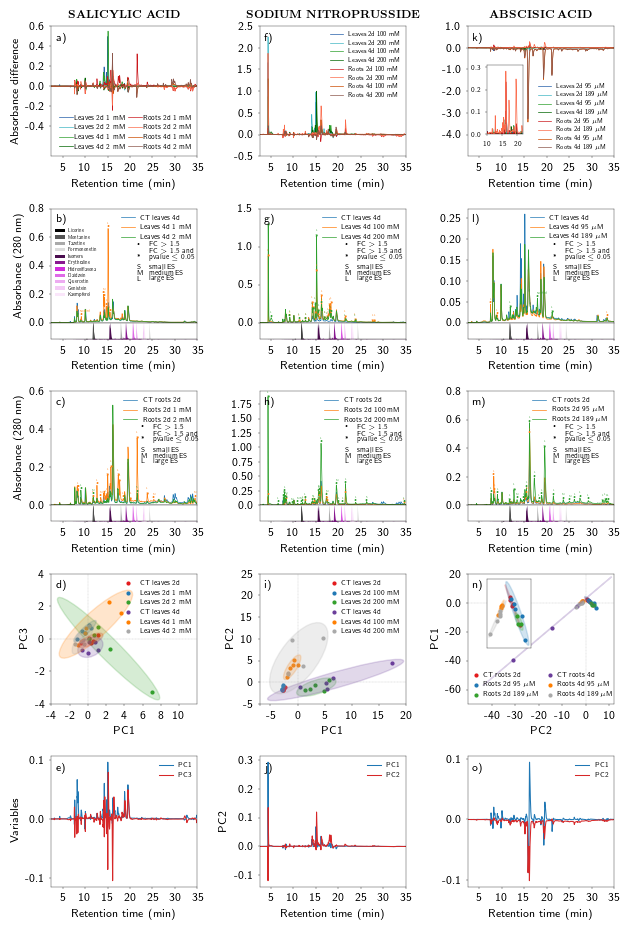

In [56]:
#     df_dm
# df_nacl
lista_nomes=[]
cores_bottom = ['#000000','#555555','#AAAAAA','gainsboro',
                    '#4b0d4fff',
                    '#891890ff', 
                    '#d22ddcff', 
                    '#df6be7ff', 
                    '#edabf1ff',  
                    '#f4cbf6ff', 
                    '#fae6fadc']   
position = [
0.6750 - 0.07-0.02, 0.71, #bola
0.680 + 0.007-0.02, 0.71, #F bola
0.6750 - 0.07-0.02, 0.62, #*
0.680 + 0.007-0.02, 0.65, #F *
0.680 + 0.007-0.02, 0.6, #pvalue
0.6750 - 0.07-0.02, 0.51, #S
0.6750 - 0.07-0.02, 0.46, #M 
0.6750 - 0.07-0.02, 0.41,   #L
0.680 + 0.007-0.02, 0.51, #small
0.680 + 0.007-0.02, 0.46,#medium
0.680 + 0.007-0.02, 0.41,#large
0.6750 - 0.1-0.02, 0.31,
0.6750 - 0.1-0.02, 0.31]
alpha_bottom = 1
xlimmin_pca1=0
xlimmax_pca1=0
ylimmin_pca1=0
ylimmax_pca1=0
plots_em_x = 3
plots_em_y = 5
dpi = 1000
tempo         = nacl_ori_normalizado_media['Time']

fig = plt.figure(figsize=(6.4, 9.4))
outer_gs = gridspec.GridSpec(plots_em_y, plots_em_x, figure=fig)

lista_cores   = ['C0', 'C1', 'c2']
alpha = 1
lw=0.5
xlim_max     = 35
xlim_min     = 2.5

ylabel       = r'Absorbance difference'
xlabel       = r'Retention time (min)'
fontsize_legenda   = 4.5
fontsize_label     = 8 # tamanho das legendas e dos números do eixo
fontsize_letra     = 8 # tamanho da letra do painel
fontsize_circulo   = 3
fontsize_asterisco = 5
fontsize_t_efeito  = 2
fontsize_titulo = 8 

titulo       = r"$\bf{SALICYLIC\ ACID}$"

# [ + "\n" + "Absorbance (280 nm)",'',  
#                r"$\bf{ULTRAVIOLET\ LIGTH}$" + "\n" + "Absorbance (280 nm)", '', #(r"$\bf{ABSCISIC\ ACID}$" + "\n" + "Absorbance (280 nm)")
#                r"$\bf{WATER\ STRESS}$" + "\n" + "Absorbance (280 nm)", '',
#                r"$\bf{SALINE\ STRESS}$" + "\n" + "Absorbance (280 nm)", '',
#                r"$\bf{MECHANICAL\ DAMAGE}$" + "\n" + "Absorbance (280 nm)", '']


xticks       = [5, 10, 15, 20, 25, 30, 35]  #se lista vazia, python escolhe os numeros
xticks_label = ['5','10','15','20','25','30','35'] #se lista vazia, python escolhe os numeros
yticks       = [-0.4,-0.2,0.0,0.2,0.4,0.6]#se lista vazia, python escolhe os numeros
yticks_label = ['-0.4','-0.2','0.0','0.2','0.4','0.6']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 180 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'a)'
lista_plots   = [ as_ori_normalizado_media['FAS12']-as_ori_normalizado_media['FC682'],
                as_ori_normalizado_media['FAS22']-as_ori_normalizado_media['FC682'],
                as_ori_normalizado_media['FAS14']-as_ori_normalizado_media['FC684'],
                as_ori_normalizado_media['FAS24']-as_ori_normalizado_media['FC684'],
                as_ori_normalizado_media['RAS12']-as_ori_normalizado_media['RC682'],
                as_ori_normalizado_media['RAS22']-as_ori_normalizado_media['RC682'],
                as_ori_normalizado_media['RAS14']-as_ori_normalizado_media['RC684'],
                as_ori_normalizado_media['RAS24']-as_ori_normalizado_media['RC684']]

lista_label   = ['Leaves 2d 1 mM','Leaves 2d 2 mM','Leaves 4d 1 mM','Leaves 4d 2 mM',
                'Roots 2d 1 mM','Roots 2d 2 mM','Roots 4d 1 mM','Roots 4d 2 mM',]


A = 0 #mudar o painel
B = 0 #mudar o painel

ax_top = fig.add_subplot(outer_gs[A, B])
ylimmax=0.9

lista_cores   = ['#225ea8','#41b6c4','C2','darkgreen','#cb181d','#fb6a4a','#cc4c02','C5']
# '','','C2','#E89C40','tan','C5'

#mudar o df!!!
df_func=df_as
figura_nova = 'sub'
posicao_legenda = 'lower right'
ylim_min=-0.7
ylim_max=0.6
insert = False
insert_position_list = [0.095, 0.17, 0.3, 0.53]
insert_xlim_min=10
insert_xlim_max=22
insert_ylim_min =0.0
insert_ylim_max=0.2
insert_fontsize = 5
insert_xticks = [10, 15, 20]
insert_xticklabels = [10, 15, 20]
insert_yticks = [0.0, 0.1, 0.2]
insert_yticklabels = [0.0, 0.1, 0.2]
df_painel_a= New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
                       xlimmax_pca1,
                       ylimmin_pca1,
                       ylimmax_pca1,
                       posicao_legenda,
                      ylim_min, ylim_max,
                       insert,insert_position_list, insert_xlim_min,
insert_xlim_max,insert_ylim_min,insert_ylim_max,insert_fontsize,
insert_xticks,insert_xticklabels,insert_yticks,insert_yticklabels)



##############################################################################################
##############################################################################################


lista_cores   = ['C0', 'C1', 'C2']
alpha = 1
lw=0.5
xlim_max     = 35
xlim_min     = 2.5
xticks       = [5, 10, 15, 20, 25, 30, 35]  #se lista vazia, python escolhe os numeros
xticks_label = ['5','10','15','20','25','30','35'] #se lista vazia, python escolhe os numeros
ylabel       = r'Absorbance (280 nm)'
xlabel       = r'Retention time (min)'
fontsize_legenda   = 5
fontsize_label     = 8 # tamanho das legendas e dos números do eixo
fontsize_letra     = 8 # tamanho da letra do painel
fontsize_circulo   = 3
fontsize_asterisco = 5
fontsize_t_efeito  = 2

yticks       = [ 0.0,0.2,0.4,0.6,0.8] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0','0.2','0.4','0.6','0.8']


tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 180 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'b)'
lista_nomes = ['FC684','FAS14','FAS24']
lista_plots   = [as_ori_normalizado_media['FC684'],
                 as_ori_normalizado_media['FAS14'],                 
                 as_ori_normalizado_media['FAS24'],
]
lista_label   = ['CT leaves 4d','Leaves 4d 1 mM','Leaves 4d 2 mM'         
                 ]

ylimmax = None

A = 1 #mudar o painel
B = 0 #mudar o painel


inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A,B],
            height_ratios=[7, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])


df_func=df_as
figura_nova = 'picos'
posicao_legenda = 'upper right'
ylim_min=-4
ylim_max=0.7
insert = False
insert_position_list = [0.095, 0.17, 0.3, 0.53]
insert_xlim_min=10
insert_xlim_max=22
insert_ylim_min =0.0
insert_ylim_max=0.2
insert_fontsize = 5
insert_xticks = [10, 15, 20]
insert_xticklabels = [10, 15, 20]
insert_yticks = [0.0, 0.1, 0.2]
insert_yticklabels = [0.0, 0.1, 0.2]
df_painel_b = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
                       xlimmax_pca1,
                       ylimmin_pca1,
                       ylimmax_pca1,
                       posicao_legenda,
                      ylim_min, ylim_max,
                       insert,insert_position_list, insert_xlim_min,
insert_xlim_max,insert_ylim_min,insert_ylim_max,insert_fontsize,
insert_xticks,insert_xticklabels,insert_yticks,insert_yticklabels)



# ###########################################################
# ###########################################################


tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 180 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'c)'
lista_nomes = ['RC682','RAS12','RAS22']
lista_plots   = [as_ori_normalizado_media['RC682'],
                 as_ori_normalizado_media['RAS12'],
                 as_ori_normalizado_media['RAS22'],
]
lista_label   = ['CT roots 2d','Roots 2d 1 mM','Roots 2d 2 mM'          
                 ]



A = 2 #mudar o painel
B = 0 #mudar o painel
yticks       = [0.0,0.2,0.4,0.6] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0','0.2','0.4','0.6']


inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A,B], 
            height_ratios=[7, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])


#mudar o df!!!
figura_nova = 'picos'
ylimmax = None
df_func=df_as
posicao_legenda = 'upper right'
ylim_min=-4
ylim_max=0.7
insert = False
insert_position_list = [0.095, 0.17, 0.3, 0.53]
insert_xlim_min=10
insert_xlim_max=22
insert_ylim_min =0.0
insert_ylim_max=0.2
insert_fontsize = 5
insert_xticks = [10, 15, 20]
insert_xticklabels = [10, 15, 20]
insert_yticks = [0.0, 0.1, 0.2]
insert_yticklabels = [0.0, 0.1, 0.2]

position = [
0.6750 - 0.07-0.02+0.03, 0.71, #bola
0.680 + 0.007-0.02+0.03, 0.71, #F bola
0.6750 - 0.07-0.02+0.03, 0.62, #*
0.680 + 0.007-0.02+0.03, 0.65, #F *
0.680 + 0.007-0.02+0.03, 0.6, #pvalue
0.6750 - 0.07-0.02+0.03, 0.51, #S
0.6750 - 0.07-0.02+0.03, 0.46, #M 
0.6750 - 0.07-0.02+0.03, 0.41,   #L
0.680 + 0.007-0.02+0.03, 0.51, #small
0.680 + 0.007-0.02+0.03, 0.46,#medium
0.680 + 0.007-0.02+0.03, 0.41,#large
0.6750 - 0.1-0.02+0.05, 0.31,
0.6750 - 0.1-0.02+0.05, 0.31]

df_painel_c = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
                       xlimmax_pca1,
                       ylimmin_pca1,
                       ylimmax_pca1,
                       posicao_legenda,
                      ylim_min, ylim_max,
                       insert,insert_position_list, insert_xlim_min,
insert_xlim_max,insert_ylim_min,insert_ylim_max,insert_fontsize,
insert_xticks,insert_xticklabels,insert_yticks,insert_yticklabels)


position = [
0.6750 - 0.07-0.02, 0.71, #bola
0.680 + 0.007-0.02, 0.71, #F bola
0.6750 - 0.07-0.02, 0.62, #*
0.680 + 0.007-0.02, 0.65, #F *
0.680 + 0.007-0.02, 0.6, #pvalue
0.6750 - 0.07-0.02, 0.51, #S
0.6750 - 0.07-0.02, 0.46, #M 
0.6750 - 0.07-0.02, 0.41,   #L
0.680 + 0.007-0.02, 0.51, #small
0.680 + 0.007-0.02, 0.46,#medium
0.680 + 0.007-0.02, 0.41,#large
0.6750 - 0.1-0.02, 0.31,
0.6750 - 0.1-0.02, 0.31]

# ######################################################################################
# ######################################################################################


A = 3 #mudar o painel
B = 0 #mudar o painel


ax_top = fig.add_subplot(outer_gs[A, B])

tempo         = [  s_leavesAS_ct2d['PC1'],
                s_leaves_t2d1['PC1'],
                s_leaves_t2d2['PC1'],
                s_leavesAS_ct4d['PC1'],
                s_leaves_t4d1['PC1'],
                s_leaves_t4d2['PC1'],]      
lista_plots   = [s_leavesAS_ct2d['PC3'],
s_leaves_t2d1['PC3'],
s_leaves_t2d2['PC3'],
s_leavesAS_ct4d['PC3'],
s_leaves_t4d1['PC3'],
s_leaves_t4d2['PC3'],]

          
                 
lista_label   =['CT leaves 2d',
'Leaves 2d 1 mM',
'Leaves 2d 2 mM',
'CT leaves 4d',
'Leaves 4d 1 mM',
'Leaves 4d 2 mM']

lista_cores   = ['#e31a1c',
'#1f78b4',
'#33a02c',
'#6a3d9a',
'#ff7f00',
'darkgrey',]
# ylabel       = r'PC2'
xlabel       = r'PC1'
xticks       =[-4,-2,0,2,4,6,8,10]
xticks_label = ['-4','-2','0','2','4','6','8','10']
yticks    =   [-4,-2,0,2,4]
yticks_label=['-4','-2','0','2','4']
figura_nova = 'pca 1'
ylimmax = None

letra_painel = 'd)'

xlimmin_pca1=None
xlimmax_pca1=12
ylimmin_pca1=None
ylimmax_pca1=None

df_func=df_as
posicao_legenda = 'upper right'
ylim_min=None
ylim_max=None
insert = False
insert_position_list = [0.13, 0.43, 0.3, 0.53]
insert_xlim_min=None
insert_xlim_max=None
insert_ylim_min =None
insert_ylim_max=None
insert_fontsize = 5
insert_xticks = []
insert_xticklabels = []
insert_yticks = []
insert_yticklabels = []
ylabel       = r'PC3'
df_painel_d = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
                       xlimmax_pca1,
                       ylimmin_pca1,
                       ylimmax_pca1,
                       posicao_legenda,
                      ylim_min, ylim_max,
                       insert,insert_position_list, insert_xlim_min,
insert_xlim_max,insert_ylim_min,insert_ylim_max,insert_fontsize,
insert_xticks,insert_xticklabels,insert_yticks,insert_yticklabels)



##################################################################3
##################################################################

A = 4 #mudar o painel
B = 0 #mudar o painel


ax_top = fig.add_subplot(outer_gs[A, B])

tempo = loadings_leaves_as['time']
lista_plots = [loadings_leaves_as['PC1'],loadings_leaves_as['PC3']]

lista_label = ['PC1','PC3']
lista_cores = ['C0', 'C3']
ylabel       = r'Variables'
xlabel       = r'Retention time (min)'
xticks       = [5, 10, 15, 20, 25, 30, 35]  #se lista vazia, python escolhe os numeros
xticks_label = ['5','10','15','20','25','30','35'] #se lista vazia, python escolhe os numeros
yticks       = [-0.1,0,0.1] #se lista vazia, python escolhe os numeros
yticks_label = ['-0.1','0.0','0.1']


figura_nova = 'pca 2'
xlimmin_pca1=None
xlimmax_pca1=None
ylimmin_pca1=None
ylimmax_pca1=None

df_func=df_nacl
posicao_legenda = 'upper right'
ylim_min=-4
ylim_max=0.7
insert = False
insert_position_list = [0.13, 0.43, 0.3, 0.53]
insert_xlim_min=None
insert_xlim_max=None
insert_ylim_min =None
insert_ylim_max=None
insert_fontsize = 5
insert_xticks = []
insert_xticklabels = []
insert_yticks = []
insert_yticklabels = []

letra_painel = 'e)'

df_painel_e = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
                       xlimmax_pca1,
                       ylimmin_pca1,
                       ylimmax_pca1,
                       posicao_legenda,
                      ylim_min, ylim_max,
                       insert,insert_position_list, insert_xlim_min,
insert_xlim_max,insert_ylim_min,insert_ylim_max,insert_fontsize,
insert_xticks,insert_xticklabels,insert_yticks,insert_yticklabels)

######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################


alpha = 1
lw=0.5
xlim_max     = 35
xlim_min     = 2.5
xticks       = [5, 10, 15, 20, 25, 30, 35]  #se lista vazia, python escolhe os numeros
xticks_label = ['5','10','15','20','25','30','35'] #se lista vazia, python escolhe os numeros
ylabel       = r''
xlabel       = r'Retention time (min)'
fontsize_legenda   = 4.5
fontsize_label     = 8 # tamanho das legendas e dos números do eixo
fontsize_letra     = 8 # tamanho da letra do painel
fontsize_circulo   = 3
fontsize_asterisco = 5
fontsize_t_efeito  = 2
fontsize_titulo = 8 

titulo       = r"$\bf{SODIUM\ NITROPRUSSIDE}$"

# [ + "\n" + "Absorbance (280 nm)",'',  
#                r"$\bf{ULTRAVIOLET\ LIGTH}$" + "\n" + "Absorbance (280 nm)", '', #(r"$\bf{ABSCISIC\ ACID}$" + "\n" + "Absorbance (280 nm)")
#                r"$\bf{WATER\ STRESS}$" + "\n" + "Absorbance (280 nm)", '',
#                r"$\bf{SALINE\ STRESS}$" + "\n" + "Absorbance (280 nm)", '',
#                r"$\bf{MECHANICAL\ DAMAGE}$" + "\n" + "Absorbance (280 nm)", '']


yticks       = [-0.5,0.0,0.5,1.0,1.5,2.0,2.5] #se lista vazia, python escolhe os numeros
yticks_label = ['-0.5','0.0','0.5','1.0','1.5','2.0','2.5']
tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 180 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'f)'
tempo         = snp_ori_normalizado_media['Time']
lista_plots   = [snp_ori_normalizado_media['FSNP1002']-snp_ori_normalizado_media['FC682'],
                snp_ori_normalizado_media['FSNP2002']-snp_ori_normalizado_media['FC682'],
                snp_ori_normalizado_media['FSNP1004']-snp_ori_normalizado_media['FC684'],
                snp_ori_normalizado_media['FSNP2004']-snp_ori_normalizado_media['FC684'],
                snp_ori_normalizado_media['RSNP1002']-snp_ori_normalizado_media['RC682'],
                snp_ori_normalizado_media['RSNP2002']-snp_ori_normalizado_media['RC682'],
                snp_ori_normalizado_media['RSNP1004']-snp_ori_normalizado_media['FC684'],
                snp_ori_normalizado_media['RSNP2004']-snp_ori_normalizado_media['FC684'],]

lista_label   = ['Leaves 2d 100 mM',
                 'Leaves 2d 200 mM',
                 'Leaves 4d 100 mM',
                 'Leaves 4d 200 mM',
                 'Roots 2d 100 mM',
                 'Roots 2d 200 mM',
                 'Roots 4d 100 mM',
                 'Roots 4d 200 mM',]


A = 0 #mudar o painel
B = 1 #mudar o painel

ax_top = fig.add_subplot(outer_gs[A, B])
ylimmax=None

lista_cores   = ['#225ea8','#41b6c4','C2','darkgreen','#cb181d','#fb6a4a','#cc4c02','C5']
#mudar o df!!!

figura_nova = 'sub'
df_func=df_snp
posicao_legenda = 'upper right'
ylim_min=None
ylim_max=None
insert = False
insert_position_list = [0.095, 0.17, 0.3, 0.53]
insert_xlim_min=10
insert_xlim_max=22
insert_ylim_min =0.0
insert_ylim_max=0.23
insert_fontsize = 5
insert_xticks = [10, 15, 20]
insert_xticklabels = [10, 15, 20]
insert_yticks = [0.0, 0.1, 0.2]
insert_yticklabels = [0.0, 0.1, 0.2]

df_painel_f = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
                       xlimmax_pca1,
                       ylimmin_pca1,
                       ylimmax_pca1,
                       posicao_legenda,
                      ylim_min, ylim_max,
                       insert,insert_position_list, insert_xlim_min,
insert_xlim_max,insert_ylim_min,insert_ylim_max,insert_fontsize,
insert_xticks,insert_xticklabels,insert_yticks,insert_yticklabels)



###########################################################
###########################################################

lista_cores   = ['C0', 'C1', 'C2']
alpha = 1
lw=0.5
xlim_max     = 35
xlim_min     = 2.5
xticks       = [5, 10, 15, 20, 25, 30, 35]  #se lista vazia, python escolhe os numeros
xticks_label = ['5','10','15','20','25','30','35'] #se lista vazia, python escolhe os numeros
ylabel       = r''
xlabel       = r'Retention time (min)'
fontsize_legenda   = 5
fontsize_label     = 8 # tamanho das legendas e dos números do eixo
fontsize_letra     = 8 # tamanho da letra do painel
fontsize_circulo   = 3
fontsize_asterisco = 5
fontsize_t_efeito  = 2


yticks       = [0.0,0.5,1.0,1.5] #se lista vazia, python escolhe os numeros
yticks_label = ['0.0','0.5','1.0','1.5']


tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 180 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'g)'

lista_nomes = ['FC684','FSNP1004','FSNP2004']
lista_plots   = [snp_ori_normalizado_media['FC684'],
                 snp_ori_normalizado_media['FSNP1004'],                 
                 snp_ori_normalizado_media['FSNP2004'],
]
lista_label   = [ 'CT leaves 4d','Leaves 4d 100 mM','Leaves 4d 200 mM'        
                 ]
ylimmax = None

A = 1 #mudar o painel
B = 1 #mudar o painel


inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A,B],
            height_ratios=[7, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])


figura_nova = 'picos'
df_func=df_snp
posicao_legenda = 'upper right'
ylim_min=None
ylim_max=None
insert = False
insert_position_list = [0.095, 0.17, 0.3, 0.53]
insert_xlim_min=10
insert_xlim_max=22
insert_ylim_min =0.0
insert_ylim_max=0.23
insert_fontsize = 5
insert_xticks = [10, 15, 20]
insert_xticklabels = [10, 15, 20]
insert_yticks = [0.0, 0.1, 0.2]
insert_yticklabels = [0.0, 0.1, 0.2]
df_painel_b = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
                       xlimmax_pca1,
                       ylimmin_pca1,
                       ylimmax_pca1,
                       posicao_legenda,
                      ylim_min, ylim_max,
                       insert,insert_position_list, insert_xlim_min,
insert_xlim_max,insert_ylim_min,insert_ylim_max,insert_fontsize,
insert_xticks,insert_xticklabels,insert_yticks,insert_yticklabels)



# ###########################################################
# ###########################################################


tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 180 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'h)'

yticks       = [0.0,0.25,0.50, 0.75, 1.00, 1.25,1.50, 1.75] 
yticks_label = ['0.0','0.25','0.50', '0.75', '1.00', '1.25','1.50', '1.75']


lista_nomes = ['RC682','RSNP1002','RSNP2002']
lista_plots   = [snp_ori_normalizado_media['RC682'],
                 snp_ori_normalizado_media['RSNP1002'],
                 snp_ori_normalizado_media['RSNP2002'],
]
lista_label   = ['CT roots 2d','Roots 2d 100 mM','Roots 2d 200 mM'          
                 ]


A = 2 #mudar o painel
B = 1 #mudar o painel




inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A,B], 
            height_ratios=[7, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])


#mudar o df!!!
figura_nova = 'picos'
df_func=df_snp
posicao_legenda = 'upper right'
ylim_min=None
ylim_max=None
insert = False
insert_position_list = [0.095, 0.17, 0.3, 0.53]
insert_xlim_min=10
insert_xlim_max=22
insert_ylim_min =0.0
insert_ylim_max=0.23
insert_fontsize = 5
insert_xticks = [10, 15, 20]
insert_xticklabels = [10, 15, 20]
insert_yticks = [0.0, 0.1, 0.2]
insert_yticklabels = [0.0, 0.1, 0.2]
df_painel_c = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
                       xlimmax_pca1,
                       ylimmin_pca1,
                       ylimmax_pca1,
                       posicao_legenda,
                      ylim_min, ylim_max,
                       insert,insert_position_list, insert_xlim_min,
insert_xlim_max,insert_ylim_min,insert_ylim_max,insert_fontsize,
insert_xticks,insert_xticklabels,insert_yticks,insert_yticklabels)


# ######################################################################################
# ######################################################################################

# s_leavesSNP_ct2d
# s_leaves_t2d100
# s_leaves_t2d200
# s_leavesSNP_ct4d
# s_leaves_t4d100
# s_leaves_t4d200

A = 3 #mudar o painel
B = 1 #mudar o painel


ax_top = fig.add_subplot(outer_gs[A, B])

#tempo é o eixo X
tempo         = [s_leavesSNP_ct2d['PC1'],
s_leaves_t2d100['PC1'],
s_leaves_t2d200['PC1'],
s_leavesSNP_ct4d['PC1'],
s_leaves_t4d100['PC1'],
s_leaves_t4d200['PC1'],]   

lista_plots   = [s_leavesSNP_ct2d['PC2'],
s_leaves_t2d100['PC2'],
s_leaves_t2d200['PC2'],
s_leavesSNP_ct4d['PC2'],
s_leaves_t4d100['PC2'],
s_leaves_t4d200['PC2'],]

               
lista_label   =['CT leaves 2d',
                'Leaves 2d 100 mM',
                'Leaves 2d 200 mM',
                'CT leaves 4d',
                'Leaves 4d 100 mM',
                'Leaves 4d 200 mM']

lista_cores   = ['#e31a1c',
'#1f78b4',
'#33a02c',
'#6a3d9a',
'#ff7f00',
'darkgrey',]

ylabel       = r'PC2'
xlabel       = r'PC1'
xticks       =[-7,-5,0,5,10,15,20]
xticks_label = ['','-5','0','5','10','15','20']
yticks    =   [-5,0,5,10,15,20,25]
yticks_label=['-5','0','5','10','15','20','25']
figura_nova = 'pca 1'
# ylimmax = 20
df_func=df_snp
# xlimmin_pca1=20
# xlimmax_pca1=20
# ylimmin_pca1=-5
# ylimmax_pca1=-5

letra_painel = 'i)'

figura_nova = 'pca 1'
df_func=df_snp
posicao_legenda = 'upper right'
ylim_min=None
ylim_max=None
insert = False
insert_position_list = [0.095, 0.17, 0.3, 0.53]
insert_xlim_min=10
insert_xlim_max=22
insert_ylim_min =0.0
insert_ylim_max=0.23
insert_fontsize = 5
insert_xticks = [10, 15, 20]
insert_xticklabels = [10, 15, 20]
insert_yticks = [0.0, 0.1, 0.2]
insert_yticklabels = [0.0, 0.1, 0.2]
df_painel_d = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
                       xlimmax_pca1,
                       ylimmin_pca1,
                       ylimmax_pca1,
                       posicao_legenda,
                      ylim_min, ylim_max,
                       insert,insert_position_list, insert_xlim_min,
insert_xlim_max,insert_ylim_min,insert_ylim_max,insert_fontsize,
insert_xticks,insert_xticklabels,insert_yticks,insert_yticklabels)






##################################################################
##################################################################


A = 4 #mudar o painel
B = 1 #mudar o painel


ax_top = fig.add_subplot(outer_gs[A, B])

tempo = loadings_roots_snp['time']
lista_plots = [loadings_leaves_snp['PC1'],loadings_leaves_snp['PC2']]
lista_label = ['PC1','PC2']
lista_cores = ['C0', 'C3']
# ylabel       = r'Variable'
xlabel       = r'Retention time (min)'
xticks       = [5, 10, 15, 20, 25, 30, 35]  #se lista vazia, python escolhe os numeros
xticks_label = ['5','10','15','20','25','30','35'] #se lista vazia, python escolhe os numeros
yticks       = [-0.1,0,0.1,0.2,0.3] #se lista vazia, python escolhe os numeros
yticks_label = ['-0.1','0.0','0.1','0.2','0.3']


figura_nova = 'pca 2'
ylimmax = None

xlimmin_pca1=None
xlimmax_pca1=None
ylimmin_pca1=None
ylimmax_pca1=None

letra_painel = 'j)'

df_func=df_snp
posicao_legenda = 'upper right'
ylim_min=None
ylim_max=None
insert = False
insert_position_list = [0.095, 0.17, 0.3, 0.53]
insert_xlim_min=10
insert_xlim_max=22
insert_ylim_min =0.0
insert_ylim_max=0.23
insert_fontsize = 5
insert_xticks = [10, 15, 20]
insert_xticklabels = [10, 15, 20]
insert_yticks = [0.0, 0.1, 0.2]
insert_yticklabels = [0.0, 0.1, 0.2]
df_painel_e = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
                       xlimmax_pca1,
                       ylimmin_pca1,
                       ylimmax_pca1,
                       posicao_legenda,
                      ylim_min, ylim_max,
                       insert,insert_position_list, insert_xlim_min,
insert_xlim_max,insert_ylim_min,insert_ylim_max,insert_fontsize,
insert_xticks,insert_xticklabels,insert_yticks,insert_yticklabels)


######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################

alpha = 1
lw=0.5
xlim_max     = 35
xlim_min     = 2.5
xticks       = [5, 10, 15, 20, 25, 30, 35]  #se lista vazia, python escolhe os numeros
xticks_label = ['5','10','15','20','25','30','35'] #se lista vazia, python escolhe os numeros
ylabel       = r''
xlabel       = r'Retention time (min)'
fontsize_legenda   = 4.5
fontsize_label     = 8 # tamanho das legendas e dos números do eixo
fontsize_letra     = 8 # tamanho da letra do painel
fontsize_circulo   = 3
fontsize_asterisco = 5
fontsize_t_efeito  = 2
fontsize_titulo = 8 

titulo       = r"$\bf{ABSCISIC\ ACID}$"

# [ + "\n" + "Absorbance (280 nm)",'',  
#                r"$\bf{ULTRAVIOLET\ LIGTH}$" + "\n" + "Absorbance (280 nm)", '', #(r"$\bf{ABSCISIC\ ACID}$" + "\n" + "Absorbance (280 nm)")
#                r"$\bf{WATER\ STRESS}$" + "\n" + "Absorbance (280 nm)", '',
#                r"$\bf{SALINE\ STRESS}$" + "\n" + "Absorbance (280 nm)", '',
#                r"$\bf{MECHANICAL\ DAMAGE}$" + "\n" + "Absorbance (280 nm)", '']


yticks       = [-4.0,-3.0,-2.0,-1.0,0.0,1.0] 
yticks_label = ['-4.0','-3.0','-2.0','-1.0','0.0','1.0']

tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 180 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'k)'
tempo         = aba_ori_normalizado_media['Time']
lista_plots   = [aba_ori_normalizado_media['FABA252']-aba_ori_normalizado_media['FC242'],
                 aba_ori_normalizado_media['FABA502']-aba_ori_normalizado_media['FC242'],
                 aba_ori_normalizado_media['FABA254']-aba_ori_normalizado_media['FC244'],
                 aba_ori_normalizado_media['FABA504']-aba_ori_normalizado_media['FC244'],
                 aba_ori_normalizado_media['RABA252']-aba_ori_normalizado_media['RC242'],
                 aba_ori_normalizado_media['RABA502']-aba_ori_normalizado_media['RC242'],
                 aba_ori_normalizado_media['RABA254']-aba_ori_normalizado_media['RC244'],
                 aba_ori_normalizado_media['RABA504']-aba_ori_normalizado_media['RC244']]

lista_label   = ['Leaves 2d 95 $\\mu$M',
                 'Leaves 2d 189 $\\mu$M',
                 'Leaves 4d 95 $\\mu$M',
                 'Leaves 4d 189 $\\mu$M',
                 'Roots 2d 95 $\\mu$M',
                 'Roots 2d 189 $\\mu$M',
                 'Roots 4d 95 $\\mu$M',
                 'Roots 4d 189 $\\mu$M',]


A = 0 #mudar o painel
B = 2

ax_top = fig.add_subplot(outer_gs[A, B])
ylimmax=None

lista_cores   = ['#225ea8','#41b6c4','C2','darkgreen','#cb181d','#fb6a4a','#cc4c02','C5']
#mudar o df!!!
df_func=df_aba
figura_nova = 'sub'
posicao_legenda = 'lower right'
ylim_min=-5
ylim_max=None
insert = True
insert_position_list = [0.13, 0.17, 0.25, 0.53]
insert_xlim_min=10
insert_xlim_max=22
insert_ylim_min =0.0
insert_ylim_max=0.31
insert_fontsize = 5
insert_xticks = [10, 15, 20]
insert_xticklabels = [10, 15, 20]
insert_yticks = [0.0, 0.1, 0.2,0.3]
insert_yticklabels = [0.0, 0.1, 0.2,0.3]
df_painel_a = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
                       xlimmax_pca1,
                       ylimmin_pca1,
                       ylimmax_pca1,
                       posicao_legenda,
                      ylim_min, ylim_max,
                       insert,insert_position_list, insert_xlim_min,
insert_xlim_max,insert_ylim_min,insert_ylim_max,insert_fontsize,
insert_xticks,insert_xticklabels,insert_yticks,insert_yticklabels)



# ###########################################################
# ###########################################################

lista_cores   = ['C0', 'C1','C2']
alpha = 1
lw=0.5
xlim_max     = 35
xlim_min     = 2.5
xticks       = [5, 10, 15, 20, 25, 30, 35]  #se lista vazia, python escolhe os numeros
xticks_label = ['5','10','15','20','25','30','35'] #se lista vazia, python escolhe os numeros
ylabel       = r''
xlabel       = r'Retention time (min)'
fontsize_legenda   = 5
fontsize_label     = 8 # tamanho das legendas e dos números do eixo
fontsize_letra     = 8 # tamanho da letra do painel
fontsize_circulo   = 3
fontsize_asterisco = 5
fontsize_t_efeito  = 2

yticks       = [0.0,0.05,0.10,0.15,0.20,0.25] 
yticks_label = ['0.0','0.05','0.10','0.15','0.20','0.25']


tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 180 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'l)'
lista_nomes = ['FC244','FABA254','FABA504']
lista_plots   = [aba_ori_normalizado_media['FC244'],
                 aba_ori_normalizado_media['FABA254'],                 
                 aba_ori_normalizado_media['FABA504']
]
lista_label   = [ 'CT leaves 4d','Leaves 4d 95 $\\mu$M','Leaves 4d 189 $\\mu$M'        
                 ]
ylimmax = None

A = 1 #mudar o painel
B = 2 #mudar o painel


inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A,B],
            height_ratios=[7, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])


df_func=df_aba
figura_nova = 'picos'
posicao_legenda = 'upper right'
ylim_min=None
ylim_max=None
insert = False
insert_position_list = [0.095, 0.17, 0.3, 0.53]
insert_xlim_min=10
insert_xlim_max=22
insert_ylim_min =0.0
insert_ylim_max=0.2
insert_fontsize = 5
insert_xticks = [10, 15, 20]
insert_xticklabels = [10, 15, 20]
insert_yticks = [0.0, 0.1, 0.2]
insert_yticklabels = [0.0, 0.1, 0.2]
df_painel_b = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
                       xlimmax_pca1,
                       ylimmin_pca1,
                       ylimmax_pca1,
                       posicao_legenda,
                      ylim_min, ylim_max,
                       insert,insert_position_list, insert_xlim_min,
insert_xlim_max,insert_ylim_min,insert_ylim_max,insert_fontsize,
insert_xticks,insert_xticklabels,insert_yticks,insert_yticklabels)




###########################################################
###########################################################


tempo_letra        = 100 #mover o tamanho do efeito para esquerda ou direita
tempo_controle_asterisco = 180 #mover o * para esquerda ou direita
variacao_pontos = 90
prominence               = 0.01 #numero que identifica o pico, valores altos identifica poucos

letra_painel = 'm)'
yticks       = [0.0,0.2,0.4,0.6,0.8] 
yticks_label = ['0.0','0.2','0.4','0.6','0.8']
lista_nomes = ['RC242','RABA252','RABA502']
lista_plots   = [aba_ori_normalizado_media['RC242'],
                 aba_ori_normalizado_media['RABA252'],
                 aba_ori_normalizado_media['RABA502']
]
lista_label   = ['CT roots 2d','Roots 2d 95 $\\mu$M','Roots 2d 189 $\\mu$M'        
                 ]

A = 2 #mudar o painel
B = 2 #mudar o painel

inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_gs[A,B], 
            height_ratios=[7, 1],
            hspace=0.0)

ax_top = fig.add_subplot(inner_gs[0])
ax_bottom = fig.add_subplot(inner_gs[1])


#mudar o df!!!
df_func=df_aba
figura_nova = 'picos'
posicao_legenda = 'upper right'
ylim_min=None
ylim_max=None
insert = False
insert_position_list = [0.095, 0.17, 0.3, 0.53]
insert_xlim_min=10
insert_xlim_max=22
insert_ylim_min =0.0
insert_ylim_max=0.2
insert_fontsize = 5
insert_xticks = [10, 15, 20]
insert_xticklabels = [10, 15, 20]
insert_yticks = [0.0, 0.1, 0.2]
insert_yticklabels = [0.0, 0.1, 0.2]
df_painel_b = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
                       xlimmax_pca1,
                       ylimmin_pca1,
                       ylimmax_pca1,
                       posicao_legenda,
                      ylim_min, ylim_max,
                       insert,insert_position_list, insert_xlim_min,
insert_xlim_max,insert_ylim_min,insert_ylim_max,insert_fontsize,
insert_xticks,insert_xticklabels,insert_yticks,insert_yticklabels)






######################################################################################
######################################################################################

A = 3 #mudar o painel
B = 2 #mudar o painel


ax_top = fig.add_subplot(outer_gs[A, B])

#tempo é o eixo X
tempo         = [s_rootsABA_ct2d['PC1'],
s_roots_t2d95['PC1'],
s_roots_t2d189['PC1'],
s_rootsABA_ct4d['PC1'],
s_roots_t4d95['PC1'],
s_roots_t4d189['PC1']]  

lista_plots   = [s_rootsABA_ct2d['PC2'],
s_roots_t2d95['PC2'], 
s_roots_t2d189['PC2'],
s_rootsABA_ct4d['PC2'],
s_roots_t4d95['PC2'], 
s_roots_t4d189['PC2'],]

               
lista_label   =['CT roots 2d',
'Roots 2d 95 $\\mu$M',
'Roots 2d 189 $\\mu$M',
'CT roots 4d',
'Roots 4d 95 $\\mu$M',
'Roots 4d 189 $\\mu$M']

lista_cores   = ['#e31a1c',
'#1f78b4',
'#33a02c',
'#6a3d9a',
'#ff7f00',
'darkgrey']

ylabel       = r'PC1'
xlabel       = r'PC2'
xticks       =[-40,-30,-20,-10,0,10]
xticks_label = ['-40','-30','-20','-10','0','10']
yticks    =   [-60,-40,-20,0,20]
yticks_label=['-60','-40','-20','0.0','20']
letra_painel = 'n)'
figura_nova = 'pca 1'
df_func=df_aba
posicao_legenda = 'lower center'
ylim_min=-3
ylim_max=4

insert = True
insert_position_list = [0.13, 0.43, 0.3, 0.53]
insert_xlim_min=None
insert_xlim_max=None
insert_ylim_min =None
insert_ylim_max=None
insert_fontsize = 5
insert_xticks = []
insert_xticklabels = []
insert_yticks = []
insert_yticklabels = []

xlimmin_pca1=-50
xlimmax_pca1=12
ylimmin_pca1=-70
ylimmax_pca1=None

df_painel_d = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
                       xlimmax_pca1,
                       ylimmin_pca1,
                       ylimmax_pca1,
                       posicao_legenda,
                      ylim_min, ylim_max,
                       insert,insert_position_list, insert_xlim_min,
insert_xlim_max,insert_ylim_min,insert_ylim_max,insert_fontsize,
insert_xticks,insert_xticklabels,insert_yticks,insert_yticklabels)





# ##################################################################
# ##################################################################


A = 4 #mudar o painel
B = 2 #mudar o painel


ax_top = fig.add_subplot(outer_gs[A, B])

tempo = loadings_roots_aba['time']
lista_plots = [loadings_roots_aba['PC1'],
            loadings_roots_aba['PC2']]

lista_label = ['PC1','PC2']
lista_cores = ['C0', 'C3']
ylabel       = r''
xlabel       = r'Retention time (min)'
xticks       = [5, 10, 15, 20, 25, 30, 35]  #se lista vazia, python escolhe os numeros
xticks_label = ['5','10','15','20','25','30','35'] #se lista vazia, python escolhe os numeros
yticks       = [-0.1,0,0.1] #se lista vazia, python escolhe os numeros
yticks_label = ['-0.1','0.0','0.1']


figura_nova = 'pca 2'
ylimmax = None
df_func=df_aba

xlimmin_pca1=None
xlimmax_pca1=None
ylimmin_pca1=None
ylimmax_pca1=None
posicao_legenda = 'upper right'
letra_painel = 'o)'
df_painel_d = New_Plot(ax_top, tempo,lista_plots,df_func,lista_nomes,
                       variacao_pontos,tempo_controle_asterisco,prominence,
                       lista_label,lista_cores,alpha,lw,
                       ylabel,yticks, yticks_label, fontsize_label,
                       fontsize_legenda,fontsize_circulo,fontsize_asterisco,
                       fontsize_t_efeito,tempo_letra,letra_painel,fontsize_letra,position,
                       ax_bottom, df_pad, cores_bottom, xticks_label,xlabel,xticks,xlim_min, xlim_max,
                       alpha_bottom,figura_nova,titulo,fontsize_titulo,ylimmax,xlimmin_pca1,
                       xlimmax_pca1,
                       ylimmin_pca1,
                       ylimmax_pca1,
                       posicao_legenda,
                      ylim_min, ylim_max,
                       insert,insert_position_list, insert_xlim_min,
insert_xlim_max,insert_ylim_min,insert_ylim_max,insert_fontsize,
insert_xticks,insert_xticklabels,insert_yticks,insert_yticklabels)




# plt.savefig('/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/proof/Fig_principal_final/fig4.pdf', bbox_inches='tight', pad_inches=0.1, transparent=False, dpi=dpi) 
plt.savefig('/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/proof/Fig_principal_final/fig4.tiff', 
            bbox_inches='tight', pad_inches=0.1, transparent=False, dpi=750) 



# Figura 6 - barras ou scatter com erros

# Pico #1: isomeros

In [23]:
from scipy.integrate import simpson
a = 7630
b = 8100
# a = c
# b = d
# plt.plot(df_pad['time'],df_pad['Isomers'])
# plt.fill_between(df_pad['time'][a:b],df_pad['Isomers'][a:b],color='C0',alpha=0.2,lw=0)
integracao_isomero_padrao = simpson(y=df_pad['Isomers'][a:b], x=df_pad['time'][a:b])

# plt.xlim(15,17)
df_ft24 = df_T.loc[:, df_T.columns.str.contains('FT24')]
df_ft50 = df_T.loc[:, df_T.columns.str.contains('FT50')]

c = 7680
d = 7950
integracao_isomero_T_24 = []
for i in range(len(df_ft24.columns)):
#     plt.plot(df_pad['time'][c:d],df_ft24[df_ft24.columns[i]][c:d],label=df_ft24.columns[i])
    integracao_isomero_T_24.append( simpson(y=df_ft24[df_ft24.columns[i]][c:d], x=df_pad['time'][c:d]) )
   
integracao_isomero_T_50 = []
for i in range(len(df_ft50.columns)):
#     plt.plot(df_pad['time'][c:d],df_ft50[df_ft50.columns[i]][c:d],label=df_ft50.columns[i])
    integracao_isomero_T_50.append( simpson(y=df_ft50[df_ft50.columns[i]][c:d], x=df_pad['time'][c:d]) )
    
###########################################################################################    
df_h_CT = df_h.loc[:, df_h.columns.str.contains('FCTH3')]
df_h_TR = df_h.loc[:, df_h.columns.str.contains('FTH3')]

c = 7700#7680
d = 7970#7950
integracao_isomero_h_CT = []
for i in range(len(df_h_CT.columns)):
#     plt.plot(df_pad['time'][c:d],df_h_CT[df_h_CT.columns[i]][c:d],label=df_h_CT.columns[i])
    integracao_isomero_h_CT.append( simpson(y=df_h_CT[df_h_CT.columns[i]][c:d], x=df_pad['time'][c:d]) )
   
c = 7690
d = 7960
integracao_isomero_h_TR = []
for i in range(len(df_h_TR.columns)):
#     plt.plot(df_pad['time'][c:d],df_h_TR[df_h_TR.columns[i]][c:d],label=df_h_TR.columns[i])
    integracao_isomero_h_TR.append( simpson(y=df_h_TR[df_h_TR.columns[i]][c:d], x=df_pad['time'][c:d]) )
    
##########################################################################################

df_meja_CT = df_meja.loc[:, df_meja.columns.str.contains('FC684')]
df_meja_TR = df_meja.loc[:, df_meja.columns.str.contains('FMJ404')]


c = 7680#7680
d = 7950
integracao_isomero_meja_CT = []
for i in range(len(df_meja_CT.columns)):
#     plt.plot(df_pad['time'][c:d],df_meja_CT[df_meja_CT.columns[i]][c:d],label=df_meja_CT.columns[i])
    integracao_isomero_meja_CT.append( simpson(y=df_meja_CT[df_meja_CT.columns[i]][c:d], x=df_pad['time'][c:d]) )
   
c = 7680
d = 7960
integracao_isomero_meja_TR = []
for i in range(len(df_meja_TR.columns)):
#     plt.plot(df_pad['time'][c:d],df_meja_TR[df_meja_TR.columns[i]][c:d],label=df_meja_TR.columns[i])
    integracao_isomero_meja_TR.append( simpson(y=df_meja_TR[df_meja_TR.columns[i]][c:d], x=df_pad['time'][c:d]) )
    
#################################################################
print(integracao_isomero_padrao,'\n',
'temp 24 ',np.average(integracao_isomero_T_24),'+-',np.std(integracao_isomero_T_24)/np.sqrt(len(integracao_isomero_T_24)) ,'\n',
'temp 50 ',np.average(integracao_isomero_T_50),'+-',np.std(integracao_isomero_T_50)/np.sqrt(len(integracao_isomero_T_50)) ,'\n',

'hidrico cont ',np.average(integracao_isomero_h_CT),'+-',np.std(integracao_isomero_h_CT)/np.sqrt(len(integracao_isomero_h_CT)) ,'\n',
'hidrico trat ',np.average(integracao_isomero_h_TR),'+-',np.std(integracao_isomero_h_TR)/np.sqrt(len(integracao_isomero_h_TR)) ,'\n',
     
'meja cont ',np.average(integracao_isomero_meja_CT),'+-',np.std(integracao_isomero_meja_CT)/np.sqrt(len(integracao_isomero_meja_CT)) ,'\n',
'meja trat ',np.average(integracao_isomero_meja_TR),'+-',np.std(integracao_isomero_meja_TR)/np.sqrt(len(integracao_isomero_meja_TR)) ,'\n',
     
         
     
     
     
     )


0.1190028616091932 
 temp 24  0.0491968306680676 +- 0.008371802565670312 
 temp 50  0.09833904490578399 +- 0.010675089079605422 
 hidrico cont  0.036260523014502784 +- 0.0038178219771911283 
 hidrico trat  0.08550472252733587 +- 0.015611150626548737 
 meja cont  0.013600713508920125 +- 0.0010864537162930156 
 meja trat  0.03782863957297681 +- 0.005688010007158977 



(0.0, 0.2)

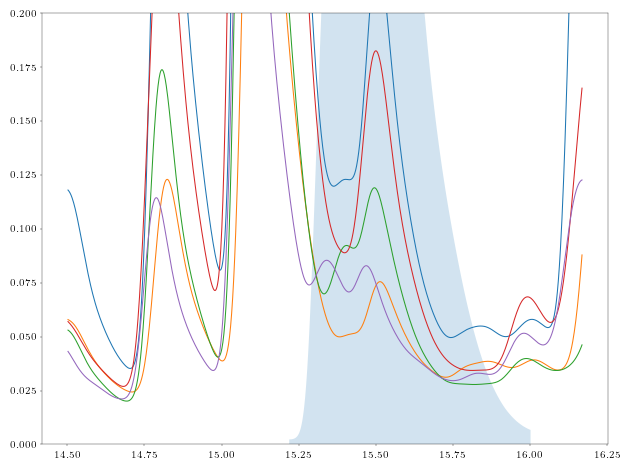

In [24]:
df_meja_CT = df_meja.loc[:, df_meja.columns.str.contains('FC684')]
df_meja_TR = df_meja.loc[:, df_meja.columns.str.contains('FMJ404')]

plt.fill_between(df_pad['time'][a:b],df_pad['Isomers'][a:b],color='C0',alpha=0.2,lw=0)
c = 7500#7680
d = 7950
integracao_isomero_meja_CT = []
for i in range(len(df_meja_CT.columns)):
#     plt.plot(df_pad['time'][c:d],df_meja_CT[df_meja_CT.columns[i]][c:d],label=df_meja_CT.columns[i])
    integracao_isomero_meja_CT.append( simpson(y=df_meja_CT[df_meja_CT.columns[i]][c:d], x=df_pad['time'][c:d]) )
   
c = 7200
d = 8200
integracao_isomero_meja_TR = []
for i in range(len(df_meja_TR.columns)):
    plt.plot(df_pad['time'][c:d],df_meja_TR[df_meja_TR.columns[i]][c:d],label=df_meja_TR.columns[i])
    integracao_isomero_meja_TR.append(simpson(y=df_meja_TR[df_meja_TR.columns[i]][c:d], x=df_pad['time'][c:d]) )
    
plt.ylim(0,0.2)

In [ ]:
from pybaselines import baseline

corrected_baseline, _ = als(df_meja_TR[df_meja_TR.columns[0]], lam=1e5, p=0.01, niter=10)

baseline_removed = data_y - corrected_baseline

In [ ]:
pip install latools

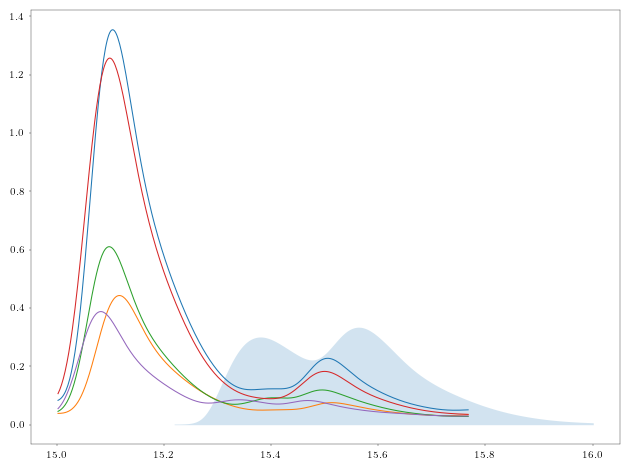

In [25]:
df_meja_CT = df_meja.loc[:, df_meja.columns.str.contains('FC684')]
df_meja_TR = df_meja.loc[:, df_meja.columns.str.contains('FMJ404')]

plt.fill_between(df_pad['time'][a:b],df_pad['Isomers'][a:b],color='C0',alpha=0.2,lw=0)
c = 7680#7680
d = 7950
integracao_isomero_meja_CT = []
for i in range(len(df_meja_CT.columns)):
#     plt.plot(df_pad['time'][c:d],df_meja_CT[df_meja_CT.columns[i]][c:d],label=df_meja_CT.columns[i])
    integracao_isomero_meja_CT.append( simpson(y=df_meja_CT[df_meja_CT.columns[i]][c:d], x=df_pad['time'][c:d]) )
   
c = 7500
d = 7960
integracao_isomero_meja_TR = []
for i in range(len(df_meja_TR.columns)):
    plt.plot(df_pad['time'][c:d],df_meja_TR[df_meja_TR.columns[i]][c:d],label=df_meja_TR.columns[i])
    integracao_isomero_meja_TR.append( simpson(y=df_meja_TR[df_meja_TR.columns[i]][c:d], x=df_pad['time'][c:d]) )
    

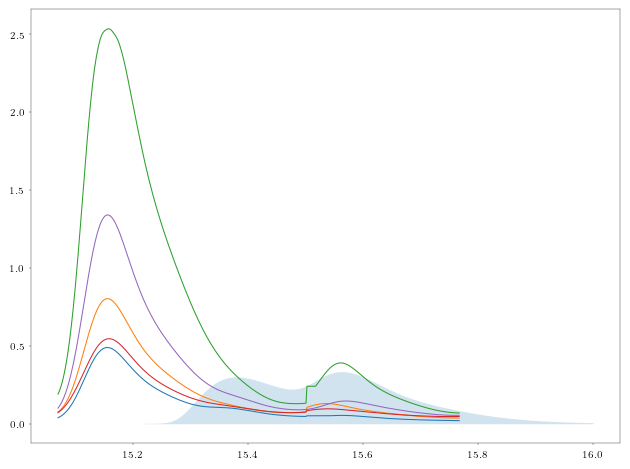

In [26]:
a = 7630
b = 8100
# a = c
# b = d
# plt.plot(df_pad['time'],df_pad['Isomers'])
plt.fill_between(df_pad['time'][a:b],df_pad['Isomers'][a:b],color='C0',alpha=0.2,lw=0)

df_snp
df_snp_CT = df_snp.loc[:, df_snp.columns.str.contains('FC684')]
df_snp_TR = df_snp.loc[:, df_snp.columns.str.contains('FSNP2004')]


c = 7680#7680
d = 7950
integracao_isomero_snp_CT = []
for i in range(len(df_snp_CT.columns)):
#     plt.plot(df_pad['time'][c:d],df_snp_CT[df_snp_CT.columns[i]][c:d],label=df_snp_CT.columns[i])
    integracao_isomero_snp_CT.append( simpson(y=df_snp_CT[df_snp_CT.columns[i]][c:d], x=df_pad['time'][c:d]) )
   
c = 7540
d = 7960
integracao_isomero_snp_TR = []
for i in range(len(df_snp_TR.columns)):
    plt.plot(df_snp['Time'][c:d],df_snp_TR[df_snp_TR.columns[i]][c:d],label=df_snp_TR.columns[i])
    integracao_isomero_meja_TR.append( simpson(y=df_snp_TR[df_snp_TR.columns[i]][c:d], x=df_snp['Time'][c:d]) )
   
    

In [92]:
df_temp = df_T.loc[:, (df_T.columns == 'Time') | df_T.columns.str.contains('FT24|FT50')]
df_temp
df_hidrico = df_h.loc[:, (df_h.columns == 'Time') | df_h.columns.str.contains('FCTH3|FTH3')]
df_hidrico
df_mj = df_meja.loc[:, (df_meja.columns == 'Time') | df_meja.columns.str.contains('FC684|FMJ404')]
df_mj
df_ssnp = df_snp.loc[:, (df_snp.columns == 'Time') | df_snp.columns.str.contains('FC684|FSNP2004')]
df_ssnp

df_ssnp_r = df_snp.loc[:, (df_snp.columns == 'Time') | df_snp.columns.str.contains('RC682|RSNP1002|RSNP2002')]
df_ssnp_r
df_uv_r = df_uv.loc[:, (df_uv.columns == 'Time') | df_uv.columns.str.contains('RCUV48|RUV48')]
df_uv_r
df_dm_r = df_dm.loc[:, (df_dm.columns == 'Time') | df_dm.columns.str.contains('RC242|RDM12|RDM32')]
df_dm_r
df_nacl_r = df_nacl.loc[:, (df_nacl.columns == 'Time') | df_nacl.columns.str.contains('RC242|RS252|RS502')]
df_nacl_r
df_as_r = df_as.loc[:, (df_as.columns == 'Time') | df_as.columns.str.contains('RC682|RAS12|RAS22')]
df_as_r

df_ppad = df_pad.loc[:, (df_pad.columns == 'time') | df_pad.columns.str.contains('Isomers|Erythraline|Quercetin')]
df_ppad

###Cria o arquivo Excel com várias planilhas
with pd.ExcelWriter('/mnt/usb-TOSHIBA_External_USB_3.0_20180211006384F-0:0-part1/Doc/Cap 2 - Tratadas_HPLC_Evelu/Analise_HPLC/RESULTADOS_PROCESSADOS/Manuscrito/Plant_Biology/Re-submission/3a-resubmission/dados_para_alinhar_com_padrao.xlsx', engine='openpyxl') as writer:
    df_ppad.to_excel(writer, sheet_name='Padroes', index=False)
    df_temp.to_excel(writer, sheet_name='Temperatura', index=False)
    df_hidrico.to_excel(writer, sheet_name='Hidrico', index=False)
    df_mj.to_excel(writer, sheet_name='MeJA', index=False)
    df_ssnp.to_excel(writer, sheet_name='SNP', index=False)
    df_ssnp_r.to_excel(writer, sheet_name='SNP_r', index=False)
    df_uv_r.to_excel(writer, sheet_name='UV_r', index=False)
    df_dm_r.to_excel(writer, sheet_name='DM_r', index=False)
    df_nacl_r.to_excel(writer, sheet_name='nacl_r', index=False)
    df_as_r.to_excel(writer, sheet_name='AS_r', index=False)
    
    